In [ ]:
!pip install yfinance
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install scikit-learn
!pip install tensorflow
!pip install bayesian-optimization
!pip install google-colab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.7 MB/s eta 0:00:00


In [ ]:
# Cek versi TensorFlow di Colab
import tensorflow as tf
print(tf.__version__)
import sys
print("Versi Python:", sys.version)



2.18.0
Versi Python: 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]


In [ ]:


# Create directories to save models, plots, and evaluation results
os.makedirs('models', exist_ok=True)
os.makedirs('plots', exist_ok=True)

# List of cryptocurrencies and model structures
cryptos = ['BTC-USD']
model_structures = [
    ['LSTM', 'LSTM', 'LSTM', 'LSTM'],
    ['GRU', 'GRU', 'GRU', 'GRU'],
    ['LSTM', 'LSTM', 'GRU', 'GRU'],
    ['GRU', 'GRU', 'LSTM', 'LSTM'],
    ['LSTM', 'GRU', 'LSTM', 'GRU'],
    ['GRU', 'LSTM', 'GRU', 'LSTM']
]

# Function to prepare the dataset
def prepare_data(crypto, time_step=120):
    data = yf.download(crypto, start='2014-01-01')
    data = data[['Close']]

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    X, y = [], []
    for i in range(len(scaled_data) - time_step - 1):
        X.append(scaled_data[i:(i + time_step), 0])
        y.append(scaled_data[i + time_step, 0])

    X = np.array(X).reshape(-1, time_step, 1)
    y = np.array(y)
    return data, X, y, scaler

# Function to build the model
def build_model(structure, time_step, lstm_units, dropout_rate):
    model = Sequential()
    for i, layer_type in enumerate(structure):
        if i == 0:
            if layer_type == 'LSTM':
                model.add(LSTM(lstm_units, return_sequences=True, input_shape=(time_step, 1)))
            elif layer_type == 'GRU':
                model.add(GRU(lstm_units, return_sequences=True, input_shape=(time_step, 1)))
        elif i == len(structure) - 1:
            if layer_type == 'LSTM':
                model.add(LSTM(lstm_units))
            elif layer_type == 'GRU':
                model.add(GRU(lstm_units))
        else:
            if layer_type == 'LSTM':
                model.add(LSTM(lstm_units, return_sequences=True))
            elif layer_type == 'GRU':
                model.add(GRU(lstm_units, return_sequences=True))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Dictionary to store evaluation results
evaluation_results = {}

# Bayesian Optimization function
def bayesian_optimization(structure, X_train, y_train, X_val, y_val):
    def model_evaluate(lstm_units, dropout_rate):
        model = build_model(structure, X_train.shape[1], int(lstm_units), dropout_rate)
        model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=0)
        val_predict = model.predict(X_val)
        val_rmse = np.sqrt(mean_squared_error(y_val, val_predict))
        return -val_rmse

    pbounds = {'lstm_units': (30, 80), 'dropout_rate': (0.1, 0.3)}
    optimizer = BayesianOptimization(f=model_evaluate, pbounds=pbounds, random_state=42)
    optimizer.maximize(init_points=5, n_iter=5)
    best_params = optimizer.max['params']
    return int(best_params['lstm_units']), best_params['dropout_rate']

# Train and evaluate the models for each cryptocurrency using K-Fold Cross-Validation
kf = KFold(n_splits=5)

for crypto in cryptos:
    data, X, y, scaler = prepare_data(crypto=crypto)

    for idx, structure in enumerate(model_structures):
        model_name = f'{crypto}_model_{idx + 1}'
        print(f"Training {model_name} with K-Fold Cross-Validation and Bayesian Optimization: {structure}")

        best_r2_score = -1  # Initialize with a very low value
        best_model = None

        fold_results = []  # List to store fold results
        all_predictions = []  # List to store predictions for plotting
        all_actual_values = []  # List to store actual values for plotting

        for fold, (train_index, val_index) in enumerate(kf.split(X)):
            print(f"Fold {fold + 1}")
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]

            # Bayesian Optimization for hyperparameters
            lstm_units, dropout_rate = bayesian_optimization(structure, X_train, y_train, X_val, y_val)

            # Build and train the model with optimized hyperparameters
            model = build_model(structure, X_train.shape[1], lstm_units, dropout_rate)
            model.fit(X_train, y_train, epochs=60, batch_size=64, verbose=1)

            # Predicting
            val_predict = model.predict(X_val)

            # Inverse transform to get actual values
            val_predict = scaler.inverse_transform(val_predict)
            y_val_actual = scaler.inverse_transform(y_val.reshape(-1, 1))

            # Append predictions and actual values to lists for plotting
            all_predictions.append(val_predict)
            all_actual_values.append(y_val_actual)

            # Evaluate the model on the validation set
            rmse = np.sqrt(mean_squared_error(y_val_actual, val_predict))
            mae = mean_absolute_error(y_val_actual, val_predict)
            r2 = r2_score(y_val_actual, val_predict)

            # Store fold results along with hyperparameters
            fold_results.append({
                'fold': fold + 1,
                'RMSE': rmse,
                'MAE': mae,
                'R²': r2,
                'LSTM Units': lstm_units,
                'Dropout Rate': dropout_rate
            })

            # Print fold results
            print(f"Fold {fold + 1} Results:")
            print(f"  RMSE: {rmse}")
            print(f"  MAE: {mae}")
            print(f"  R²: {r2}")
            print(f"  LSTM Units: {lstm_units}")
            print(f"  Dropout Rate: {dropout_rate}")
            print("-" * 20)  # Separator between folds

            # Check if current fold has the best R2 score
            if r2 > best_r2_score:
                best_r2_score = r2
                best_model = model

        # Save the best model
        if best_model is not None:
            model_filename = f'{model_name}_best.h5'
            model_path = os.path.join('models', model_filename)
            best_model.save(model_path)

        # Concatenate predictions and actual values from all folds for plotting
        all_predictions = np.concatenate(all_predictions)
        all_actual_values = np.concatenate(all_actual_values)

        # Create and save plot
        plt.figure(figsize=(16, 8))
        plt.plot(all_actual_values, label='Actual')
        plt.plot(all_predictions, label='Predictions')
        plt.legend()
        plt.title(f'{model_name} Predictions vs Actual')
        plt.xlabel('Time')
        plt.ylabel('Price')
        plot_filename = f'{model_name}_plot.png'
        plot_path = os.path.join('plots', plot_filename)
        plt.savefig(plot_path)  # Save the plot to a file
        plt.show()

        # Store all fold results and best R2 score in evaluation_results
        evaluation_results[model_name] = {
            'structure': structure,
            'fold_results': fold_results,
            'best_r2_score': best_r2_score  # Add best R2 score
        }

# Save evaluation results to JSON file
with open('evaluation_results_kfold.json', 'w') as f:
    json.dump(evaluation_results, f, indent=4)

print("All evaluation results have been saved and the models are stored in the 'models' directory.")

NameError: name 'os' is not defined

In [ ]:
from IPython import get_ipython
from IPython.display import display
# %%

# %%
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
import zipfile
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from google.colab import files
from bayes_opt import BayesianOptimization

In [ ]:


# Create directories to save models, plots, and evaluation results
os.makedirs('models', exist_ok=True)
os.makedirs('plots', exist_ok=True)

# List of cryptocurrencies and model structures
cryptos = ['ETH-USD']
model_structures = [
    ['LSTM', 'LSTM', 'LSTM', 'LSTM'],
    ['GRU', 'GRU', 'GRU', 'GRU'],
    ['LSTM', 'LSTM', 'GRU', 'GRU'],
    ['GRU', 'GRU', 'LSTM', 'LSTM'],
    ['LSTM', 'GRU', 'LSTM', 'GRU'],
    ['GRU', 'LSTM', 'GRU', 'LSTM']
]

# Function to prepare the dataset
def prepare_data(crypto, time_step=120):
    data = yf.download(crypto, start='2014-01-01')
    data = data[['Close']]

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    X, y = [], []
    for i in range(len(scaled_data) - time_step - 1):
        X.append(scaled_data[i:(i + time_step), 0])
        y.append(scaled_data[i + time_step, 0])

    X = np.array(X).reshape(-1, time_step, 1)
    y = np.array(y)
    return data, X, y, scaler

# Function to build the model
def build_model(structure, time_step, lstm_units, dropout_rate):
    model = Sequential()
    for i, layer_type in enumerate(structure):
        if i == 0:
            if layer_type == 'LSTM':
                model.add(LSTM(lstm_units, return_sequences=True, input_shape=(time_step, 1)))
            elif layer_type == 'GRU':
                model.add(GRU(lstm_units, return_sequences=True, input_shape=(time_step, 1)))
        elif i == len(structure) - 1:
            if layer_type == 'LSTM':
                model.add(LSTM(lstm_units))
            elif layer_type == 'GRU':
                model.add(GRU(lstm_units))
        else:
            if layer_type == 'LSTM':
                model.add(LSTM(lstm_units, return_sequences=True))
            elif layer_type == 'GRU':
                model.add(GRU(lstm_units, return_sequences=True))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Dictionary to store evaluation results
evaluation_results = {}

# Bayesian Optimization function
def bayesian_optimization(structure, X_train, y_train, X_val, y_val):
    def model_evaluate(lstm_units, dropout_rate):
        model = build_model(structure, X_train.shape[1], int(lstm_units), dropout_rate)
        model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=0)
        val_predict = model.predict(X_val)
        val_rmse = np.sqrt(mean_squared_error(y_val, val_predict))
        return -val_rmse

    pbounds = {'lstm_units': (30, 80), 'dropout_rate': (0.1, 0.3)}
    optimizer = BayesianOptimization(f=model_evaluate, pbounds=pbounds, random_state=42)
    optimizer.maximize(init_points=5, n_iter=5)
    best_params = optimizer.max['params']
    return int(best_params['lstm_units']), best_params['dropout_rate']

# Train and evaluate the models for each cryptocurrency using K-Fold Cross-Validation
kf = KFold(n_splits=5)

for crypto in cryptos:
    data, X, y, scaler = prepare_data(crypto=crypto)

    for idx, structure in enumerate(model_structures):
        model_name = f'{crypto}_model_{idx + 1}'
        print(f"Training {model_name} with K-Fold Cross-Validation and Bayesian Optimization: {structure}")

        best_r2_score = -1  # Initialize with a very low value
        best_model = None

        fold_results = []  # List to store fold results
        all_predictions = []  # List to store predictions for plotting
        all_actual_values = []  # List to store actual values for plotting

        for fold, (train_index, val_index) in enumerate(kf.split(X)):
            print(f"Fold {fold + 1}")
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]

            # Bayesian Optimization for hyperparameters
            lstm_units, dropout_rate = bayesian_optimization(structure, X_train, y_train, X_val, y_val)

            # Build and train the model with optimized hyperparameters
            model = build_model(structure, X_train.shape[1], lstm_units, dropout_rate)
            model.fit(X_train, y_train, epochs=60, batch_size=64, verbose=1)

            # Predicting
            val_predict = model.predict(X_val)

            # Inverse transform to get actual values
            val_predict = scaler.inverse_transform(val_predict)
            y_val_actual = scaler.inverse_transform(y_val.reshape(-1, 1))

            # Append predictions and actual values to lists for plotting
            all_predictions.append(val_predict)
            all_actual_values.append(y_val_actual)

            # Evaluate the model on the validation set
            rmse = np.sqrt(mean_squared_error(y_val_actual, val_predict))
            mae = mean_absolute_error(y_val_actual, val_predict)
            r2 = r2_score(y_val_actual, val_predict)

            # Store fold results along with hyperparameters
            fold_results.append({
                'fold': fold + 1,
                'RMSE': rmse,
                'MAE': mae,
                'R²': r2,
                'LSTM Units': lstm_units,
                'Dropout Rate': dropout_rate
            })

            # Print fold results
            print(f"Fold {fold + 1} Results:")
            print(f"  RMSE: {rmse}")
            print(f"  MAE: {mae}")
            print(f"  R²: {r2}")
            print(f"  LSTM Units: {lstm_units}")
            print(f"  Dropout Rate: {dropout_rate}")
            print("-" * 20)  # Separator between folds

            # Check if current fold has the best R2 score
            if r2 > best_r2_score:
                best_r2_score = r2
                best_model = model

        # Save the best model
        if best_model is not None:
            model_filename = f'{model_name}_best.h5'
            model_path = os.path.join('models', model_filename)
            best_model.save(model_path)

        # Concatenate predictions and actual values from all folds for plotting
        all_predictions = np.concatenate(all_predictions)
        all_actual_values = np.concatenate(all_actual_values)

        # Create and save plot
        plt.figure(figsize=(16, 8))
        plt.plot(all_actual_values, label='Actual')
        plt.plot(all_predictions, label='Predictions')
        plt.legend()
        plt.title(f'{model_name} Predictions vs Actual')
        plt.xlabel('Time')
        plt.ylabel('Price')
        plot_filename = f'{model_name}_plot.png'
        plot_path = os.path.join('plots', plot_filename)
        plt.savefig(plot_path)  # Save the plot to a file
        plt.show()

        # Store all fold results and best R2 score in evaluation_results
        evaluation_results[model_name] = {
            'structure': structure,
            'fold_results': fold_results,
            'best_r2_score': best_r2_score  # Add best R2 score
        }

# Save evaluation results to JSON file
with open('evaluation_results_kfold.json', 'w') as f:
    json.dump(evaluation_results, f, indent=4)

print("All evaluation results have been saved and the models are stored in the 'models' directory.")

[*********************100%***********************]  1 of 1 completed


Training ETH-USD_model_1 with K-Fold Cross-Validation and Bayesian Optimization: ['LSTM', 'LSTM', 'LSTM', 'LSTM']
Fold 1
|   iter    |  target   | dropou... | lstm_u... |
-------------------------------------------------


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
| 1         | -0.01936  | 0.1749    | 77.54     |


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


KeyboardInterrupt: 

[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training BNB-USD_model_1 with K-Fold Cross-Validation and Bayesian Optimization: ['LSTM', 'LSTM', 'LSTM', 'LSTM']
Fold 1
|   iter    |  target   | dropou... | lstm_u... |
-------------------------------------------------
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 1         | -0.01593  | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 2         | -0.003513 | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
| 3         | -0.003155 | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 4         | -0.003532 | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 5         | -0.004002 | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 6         | -0.006862 | 0.1941    | 37.87     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 7         | -0.003624 | 0.2657    | 45.01     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 8         | -0.006711 | 0.1203    | 56.08     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 9         | -0.00428  | 0.1011    | 53.19     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 10        | -0.007692 | 0.2335    | 62.11     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.1065
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0077
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0058
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0061
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0062
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0058
Epoch 7/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0046
Epoch 8/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0047
Epoch 9/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0050
Epoch 10/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0049
Epoch 11/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0041
Epoch 12/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0048
Epoch 13/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0040
Epoch 14/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0038
Epoch 15/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0040
Epoch 16/60
32/

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 1         | -0.006559 | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 2         | -0.005642 | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 3         | -0.003381 | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 4         | -0.007857 | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
| 5         | -0.008228 | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
| 6         | -0.008303 | 0.1897    | 44.66     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
| 7         | -0.003368 | 0.1935    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
| 8         | -0.004223 | 0.2988    | 33.44     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 9         | -0.01193  | 0.2859    | 54.23     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 10        | -0.00451  | 0.1699    | 30.01     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0926
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0086
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0064
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0067
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0057
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0060
Epoch 7/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0049
Epoch 8/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0047
Epoch 9/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0053
Epoch 10/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0042
Epoch 11/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0046
Epoch 12/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0046
Epoch 13/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0042
Epoch 14/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0045
Epoch 15/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0036
Epoch 16/60
32/

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 1         | -0.08655  | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 2         | -0.09483  | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
| 3         | -0.09196  | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 4         | -0.08224  | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 5         | -0.08763  | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 6         | -0.08941  | 0.2999    | 70.11     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 7         | -0.09075  | 0.1309    | 73.24     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 8         | -0.09427  | 0.1203    | 56.08     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 9         | -0.09008  | 0.1011    | 53.19     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
| 10        | -0.09013  | 0.2335    | 62.11     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0433
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0024
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0019
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0019
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0017
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0016
Epoch 7/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0018
Epoch 8/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0015
Epoch 9/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0018
Epoch 10/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0019
Epoch 11/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0018
Epoch 12/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0019
Epoch 13/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0013
Epoch 14/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0013
Epoch 15/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0013
Epoch 16/60
32/

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 1         | -0.04418  | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 2         | -0.03559  | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 3         | -0.0327   | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 4         | -0.05855  | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
| 5         | -0.03063  | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 6         | -0.06832  | 0.1576    | 41.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 7         | -0.07248  | 0.1284    | 65.39     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 8         | -0.05331  | 0.1203    | 56.08     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 9         | -0.04292  | 0.1011    | 53.19     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 10        | -0.04036  | 0.2335    | 62.11     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0512
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0048
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0051
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0048
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0044
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0039
Epoch 7/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0040
Epoch 8/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0040
Epoch 9/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0036
Epoch 10/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0036
Epoch 11/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0034
Epoch 12/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0034
Epoch 13/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0051
Epoch 14/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0034
Epoch 15/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0035
Epoch 16/60
32/

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 1         | -0.04635  | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 2         | -0.04817  | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 3         | -0.06851  | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 4         | -0.08895  | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 5         | -0.04954  | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step
| 6         | -0.05867  | 0.2272    | 77.47     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
| 7         | -0.04326  | 0.1109    | 77.64     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
| 8         | -0.07726  | 0.2992    | 77.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
| 9         | -0.1199   | 0.2216    | 60.14     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
| 10        | -0.0939   | 0.2398    | 59.8      |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0345
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0037
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0031
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0027
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0025
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0027
Epoch 7/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0025
Epoch 8/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0022
Epoch 9/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0020
Epoch 10/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0020
Epoch 11/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0021
Epoch 12/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0016
Epoch 13/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0018
Epoch 14/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0018
Epoch 15/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0017
Epoch 16/60
32/

Fold 5 Results:
  RMSE: 31.87374759162372
  MAE: 25.331598236083984
  R²: 0.964069411165354
  LSTM Units: 77
  Dropout Rate: 0.11093461439551092
--------------------


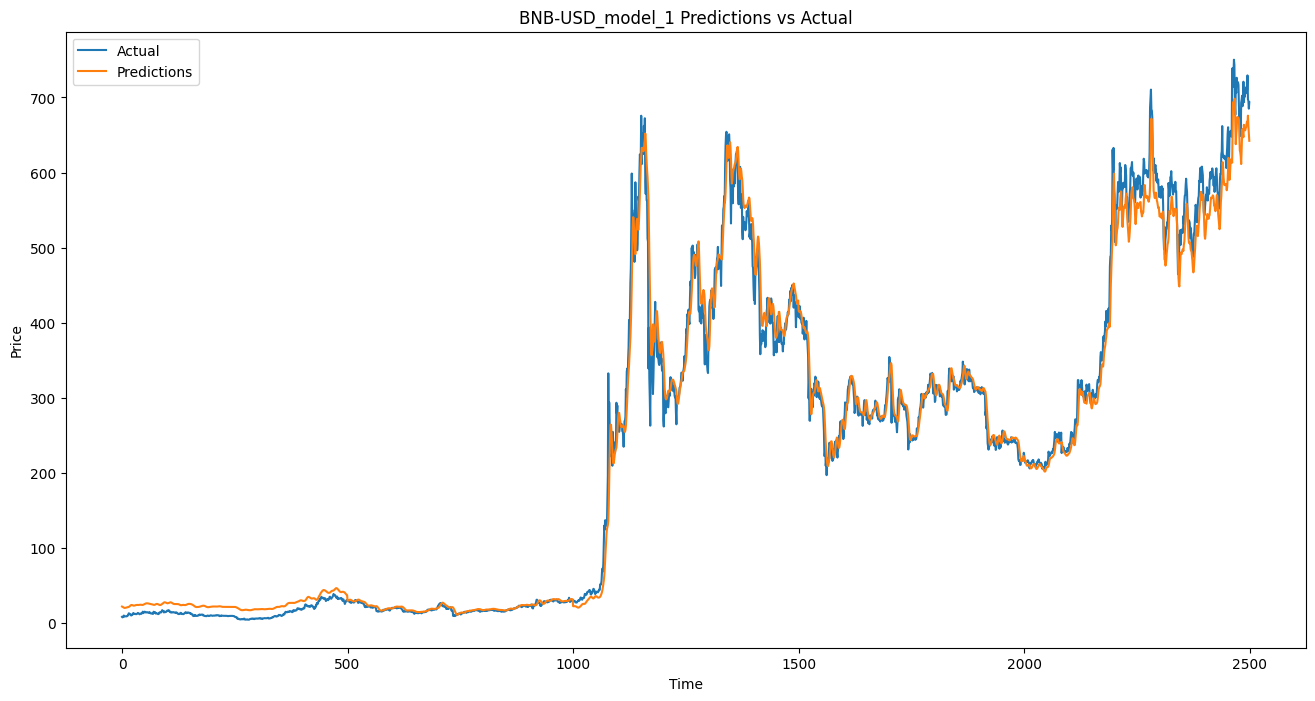

Training BNB-USD_model_2 with K-Fold Cross-Validation and Bayesian Optimization: ['GRU', 'GRU', 'GRU', 'GRU']
Fold 1
|   iter    |  target   | dropou... | lstm_u... |
-------------------------------------------------


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 1         | -0.007708 | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
| 2         | -0.00588  | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 3         | -0.005852 | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 4         | -0.003115 | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
| 5         | -0.009011 | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 6         | -0.005104 | 0.1517    | 73.35     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 7         | -0.004289 | 0.1309    | 73.24     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 8         | -0.002346 | 0.1203    | 56.08     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 9         | -0.007454 | 0.1941    | 56.08     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 10        | -0.01431  | 0.2335    | 62.11     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0590
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0042
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0032
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0034
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0023
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0025
Epoch 7/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0026
Epoch 8/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0026
Epoch 9/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0021
Epoch 10/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0022
Epoch 11/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0022
Epoch 12/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0023
Epoch 13/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0020
Epoch 14/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0021
Epoch 15/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0020
Epoch 16/60
32/

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 1         | -0.003438 | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 2         | -0.002923 | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 3         | -0.006248 | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 4         | -0.005427 | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
| 5         | -0.002257 | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 6         | -0.00879  | 0.2539    | 65.35     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
| 7         | -0.002722 | 0.2657    | 45.01     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 8         | -0.00715  | 0.1203    | 56.08     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
| 9         | -0.004514 | 0.1011    | 53.19     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 10        | -0.002907 | 0.2335    | 62.11     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0558
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0048
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0043
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0039
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0038
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0032
Epoch 7/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0035
Epoch 8/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0030
Epoch 9/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0028
Epoch 10/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0032
Epoch 11/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0028
Epoch 12/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0026
Epoch 13/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0027
Epoch 14/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0026
Epoch 15/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0026
Epoch 16/60
32/

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 1         | -0.05634  | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 2         | -0.05824  | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 3         | -0.05742  | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
| 4         | -0.05252  | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 5         | -0.05653  | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
| 6         | -0.05405  | 0.1506    | 73.28     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
| 7         | -0.05566  | 0.1107    | 73.39     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 8         | -0.05663  | 0.1203    | 56.08     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
| 9         | -0.05348  | 0.1094    | 73.28     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
| 10        | -0.05512  | 0.1761    | 73.35     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0368
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0021
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0014
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0014
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0012
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0012
Epoch 7/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0012
Epoch 8/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0013
Epoch 9/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0012
Epoch 10/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0013
Epoch 11/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0013
Epoch 12/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0013
Epoch 13/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 9.5251e-04
Epoch 14/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 8.6026e-04
Epoch 15/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0010
Epoch 1

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 1         | -0.03513  | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
| 2         | -0.02469  | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
| 3         | -0.0234   | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
| 4         | -0.01982  | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 5         | -0.02682  | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 6         | -0.02466  | 0.1674    | 73.27     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
| 7         | -0.02287  | 0.1107    | 73.39     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
| 8         | -0.02616  | 0.1203    | 56.08     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 9         | -0.03554  | 0.2576    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
| 10        | -0.02014  | 0.1761    | 73.35     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0572
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0032
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0023
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0022
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0022
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0019
Epoch 7/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0016
Epoch 8/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0018
Epoch 9/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0018
Epoch 10/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0015
Epoch 11/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0019
Epoch 12/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0014
Epoch 13/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0015
Epoch 14/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0014
Epoch 15/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0015
Epoch 16/60
32/

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
| 1         | -0.02962  | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
| 2         | -0.03982  | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
| 3         | -0.05738  | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
| 4         | -0.03994  | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
| 5         | -0.06197  | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
| 6         | -0.03128  | 0.2405    | 80.0      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
| 7         | -0.03727  | 0.2884    | 53.06     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
| 8         | -0.03491  | 0.1599    | 47.15     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
| 9         | -0.05393  | 0.1718    | 30.01     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 10        | -0.02876  | 0.1009    | 56.56     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0294
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0022
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0016
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0018
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0016
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0014
Epoch 7/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0014
Epoch 8/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0013
Epoch 9/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0014
Epoch 10/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0013
Epoch 11/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0015
Epoch 12/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0011
Epoch 13/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0013
Epoch 14/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0013
Epoch 15/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0015
Epoch 16/60
32/

Fold 5 Results:
  RMSE: 15.528397723062549
  MAE: 10.269181610107422
  R²: 0.9914719179886539
  LSTM Units: 56
  Dropout Rate: 0.10093772923657214
--------------------


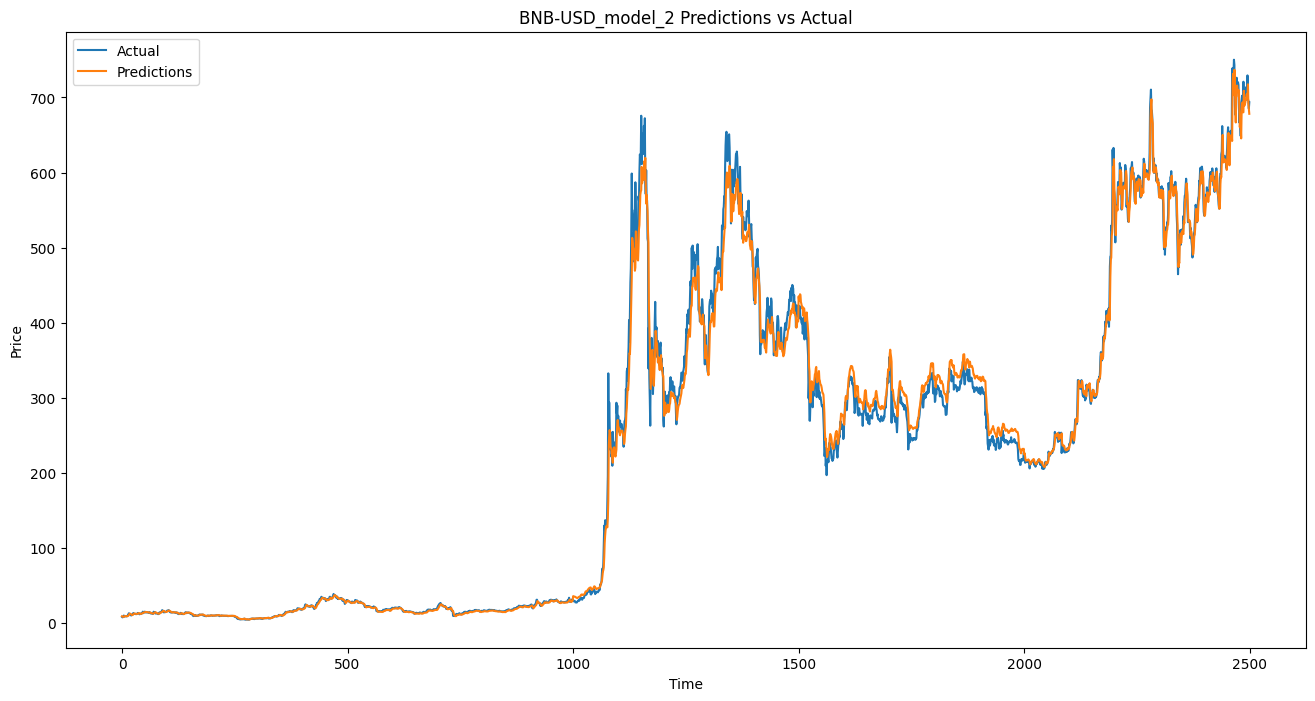

Training BNB-USD_model_3 with K-Fold Cross-Validation and Bayesian Optimization: ['LSTM', 'LSTM', 'GRU', 'GRU']
Fold 1
|   iter    |  target   | dropou... | lstm_u... |
-------------------------------------------------


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 1         | -0.005554 | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 2         | -0.003544 | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 3         | -0.006691 | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 4         | -0.003487 | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 5         | -0.004145 | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 6         | -0.008754 | 0.1813    | 73.29     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 7         | -0.005802 | 0.2657    | 45.01     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 8         | -0.006036 | 0.1203    | 56.08     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 9         | -0.008766 | 0.1011    | 53.19     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 10        | -0.007302 | 0.2335    | 62.11     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0614
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0038
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0035
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0035
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0033
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0030
Epoch 7/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0025
Epoch 8/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0029
Epoch 9/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0031
Epoch 10/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0025
Epoch 11/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0026
Epoch 12/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0023
Epoch 13/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0023
Epoch 14/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0022
Epoch 15/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0022
Epoch 16/60
32/

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 1         | -0.00323  | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 2         | -0.02312  | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 3         | -0.003514 | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 4         | -0.006578 | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 5         | -0.006403 | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 6         | -0.006295 | 0.119     | 79.94     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 7         | -0.01123  | 0.2281    | 33.13     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 8         | -0.008012 | 0.1919    | 41.34     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 9         | -0.01199  | 0.27      | 69.08     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 10        | -0.002718 | 0.1056    | 48.17     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0722
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0059
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0041
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0042
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0040
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0035
Epoch 7/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0034
Epoch 8/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0035
Epoch 9/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0030
Epoch 10/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0029
Epoch 11/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0030
Epoch 12/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0029
Epoch 13/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0031
Epoch 14/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0026
Epoch 15/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0023
Epoch 16/60
32/

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
| 1         | -0.07466  | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 2         | -0.08562  | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 3         | -0.07873  | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 4         | -0.06868  | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 5         | -0.07217  | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 6         | -0.07265  | 0.2663    | 74.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 7         | -0.07183  | 0.1302    | 70.32     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 8         | -0.08556  | 0.2723    | 48.14     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 9         | -0.08365  | 0.1718    | 30.01     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 10        | -0.07393  | 0.2958    | 67.66     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0424
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0020
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0016
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0017
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0015
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0016
Epoch 7/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0019
Epoch 8/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0015
Epoch 9/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0016
Epoch 10/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0014
Epoch 11/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0014
Epoch 12/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0017
Epoch 13/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0013
Epoch 14/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0014
Epoch 15/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0016
Epoch 16/60
32/

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 1         | -0.02594  | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 2         | -0.02764  | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 3         | -0.05778  | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 4         | -0.04403  | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 5         | -0.03099  | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 6         | -0.05328  | 0.2212    | 77.48     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 7         | -0.04928  | 0.2657    | 45.01     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 8         | -0.07131  | 0.1203    | 56.08     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 9         | -0.03648  | 0.1011    | 53.19     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 10        | -0.02601  | 0.2335    | 62.11     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0467
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0042
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0039
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0034
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0030
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0032
Epoch 7/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0031
Epoch 8/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0025
Epoch 9/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0026
Epoch 10/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0026
Epoch 11/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0025
Epoch 12/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0028
Epoch 13/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0025
Epoch 14/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0022
Epoch 15/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0022
Epoch 16/60
32/

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 1         | -0.08748  | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 2         | -0.04891  | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 3         | -0.04181  | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 4         | -0.06308  | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 5         | -0.04859  | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 6         | -0.05203  | 0.1367    | 42.64     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 7         | -0.06305  | 0.2439    | 32.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 8         | -0.0464   | 0.1013    | 54.72     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 9         | -0.05785  | 0.2511    | 49.78     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 10        | -0.05473  | 0.1067    | 68.91     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0423
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0050
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0035
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0034
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0031
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0028
Epoch 7/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0032
Epoch 8/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0025
Epoch 9/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0023
Epoch 10/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0026
Epoch 11/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0019
Epoch 12/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0019
Epoch 13/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0015
Epoch 14/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0017
Epoch 15/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0018
Epoch 16/60
32/

Fold 5 Results:
  RMSE: 22.602712519040114
  MAE: 16.705677978515624
  R²: 0.9819316206991758
  LSTM Units: 37
  Dropout Rate: 0.1312037280884873
--------------------


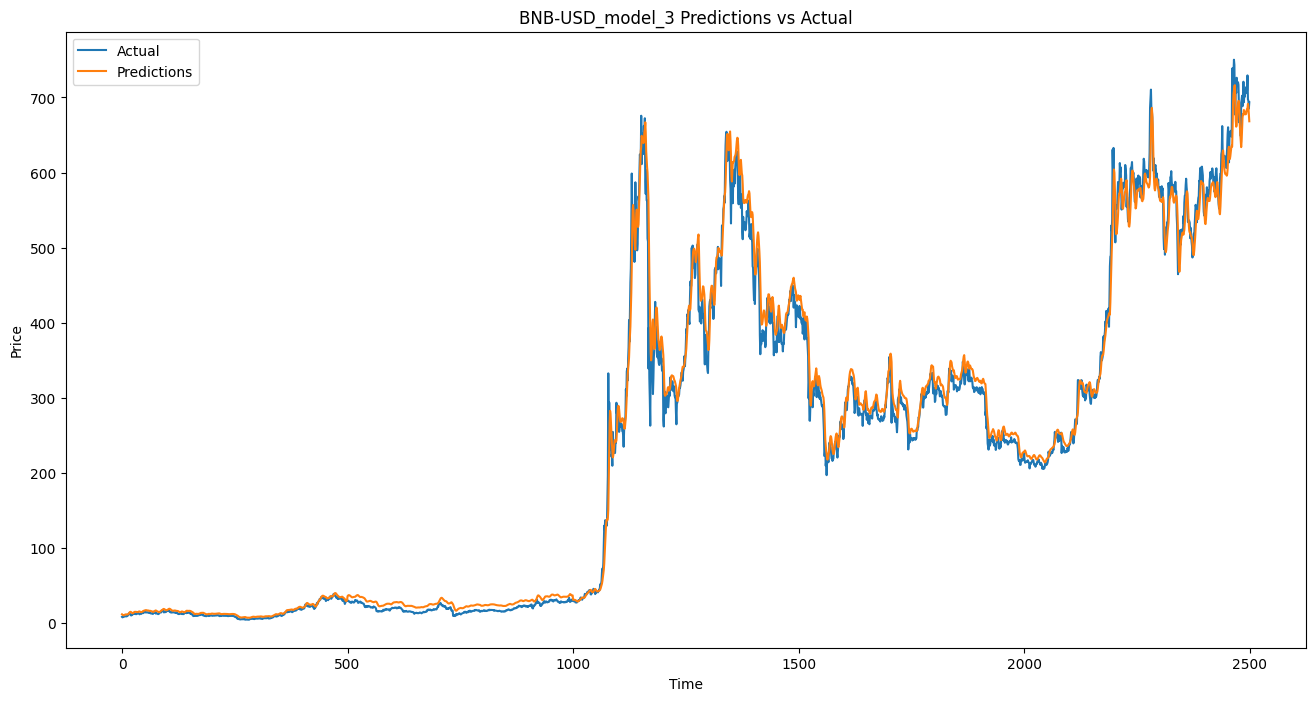

Training BNB-USD_model_4 with K-Fold Cross-Validation and Bayesian Optimization: ['GRU', 'GRU', 'LSTM', 'LSTM']
Fold 1
|   iter    |  target   | dropou... | lstm_u... |
-------------------------------------------------


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 1         | -0.002314 | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 2         | -0.003608 | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 3         | -0.005749 | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 4         | -0.002197 | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 5         | -0.003051 | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 6         | -0.003958 | 0.2991    | 74.86     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 7         | -0.01087  | 0.196     | 73.36     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 8         | -0.003727 | 0.1203    | 56.08     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 9         | -0.006115 | 0.1011    | 53.19     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 10        | -0.002819 | 0.2335    | 62.11     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - loss: 0.0468
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0038
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0035
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0030
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0031
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0027
Epoch 7/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0022
Epoch 8/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0029
Epoch 9/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0023
Epoch 10/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0021
Epoch 11/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0023
Epoch 12/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0020
Epoch 13/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0027
Epoch 14/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0018
Epoch 15/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0019
Epoch 16/60
32

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
| 1         | -0.002564 | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
| 2         | -0.002719 | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
| 3         | -0.004042 | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
| 4         | -0.004185 | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 5         | -0.003533 | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 6         | -0.004377 | 0.2266    | 77.57     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
| 7         | -0.0164   | 0.2657    | 45.01     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 8         | -0.003853 | 0.1168    | 77.28     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
| 9         | -0.003316 | 0.1336    | 60.25     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 10        | -0.003732 | 0.132     | 59.58     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0643
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0051
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0036
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0033
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0033
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0032
Epoch 7/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0028
Epoch 8/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0028
Epoch 9/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0027
Epoch 10/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0025
Epoch 11/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0023
Epoch 12/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0025
Epoch 13/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0024
Epoch 14/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0029
Epoch 15/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0021
Epoc

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
| 1         | -0.06626  | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 2         | -0.07628  | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 3         | -0.07176  | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
| 4         | -0.06538  | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 5         | -0.07574  | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 6         | -0.0794   | 0.2531    | 30.0      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
| 7         | -0.07199  | 0.1062    | 46.82     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 8         | -0.06928  | 0.2926    | 80.0      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 9         | -0.083    | 0.2888    | 75.07     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
| 10        | -0.07582  | 0.1694    | 73.22     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0367
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0018
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0016
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0016
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0013
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0018
Epoch 7/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0015
Epoch 8/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0013
Epoch 9/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0012
Epoch 10/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0010
Epoch 11/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0011
Epoch 12/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0012
Epoch 13/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0016
Epoch 14/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0014
Epoch 15/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0012
Epoch 16/60
32/

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 1         | -0.02828  | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
| 2         | -0.03101  | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 3         | -0.02534  | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 4         | -0.02598  | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 5         | -0.04845  | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 6         | -0.05337  | 0.2706    | 40.99     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
| 7         | -0.03661  | 0.2024    | 37.87     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 8         | -0.02493  | 0.1203    | 56.08     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 9         | -0.04141  | 0.1011    | 53.19     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 10        | -0.02538  | 0.2335    | 62.11     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0567
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0039
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0030
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0028
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0029
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0027
Epoch 7/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0028
Epoch 8/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0024
Epoch 9/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0023
Epoch 10/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0024
Epoch 11/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0023
Epoch 12/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0020
Epoch 13/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0022
Epoch 14/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0019
Epoch 15/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0027
Epoch 16/60
32/

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 1         | -0.0376   | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 2         | -0.04208  | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 3         | -0.06987  | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 4         | -0.04832  | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 5         | -0.0537   | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 6         | -0.04318  | 0.2094    | 54.04     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 7         | -0.03875  | 0.2972    | 80.0      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 8         | -0.04089  | 0.2953    | 48.19     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 9         | -0.03812  | 0.1718    | 30.01     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 10        | -0.05123  | 0.1181    | 44.75     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0235
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0032
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0022
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0022
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0022
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0019
Epoch 7/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0019
Epoch 8/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0017
Epoch 9/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0016
Epoch 10/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0019
Epoch 11/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0014
Epoch 12/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0013
Epoch 13/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0014
Epoch 14/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0016
Epoch 15/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0013
Epoch 16/60
32/

Fold 5 Results:
  RMSE: 15.547140878328557
  MAE: 10.213341766357422
  R²: 0.9914513183575245
  LSTM Units: 77
  Dropout Rate: 0.1749080237694725
--------------------


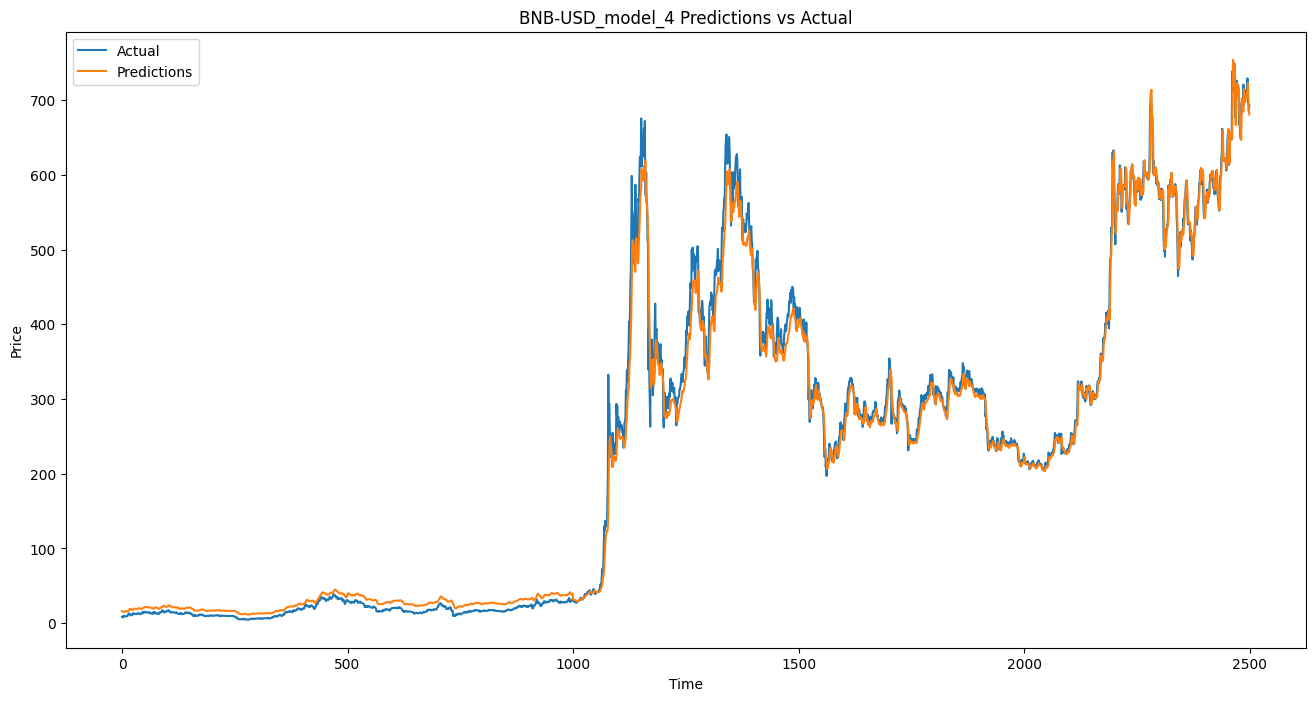

Training BNB-USD_model_5 with K-Fold Cross-Validation and Bayesian Optimization: ['LSTM', 'GRU', 'LSTM', 'GRU']
Fold 1
|   iter    |  target   | dropou... | lstm_u... |
-------------------------------------------------


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 1         | -0.005124 | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 2         | -0.003381 | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 3         | -0.01222  | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 4         | -0.006209 | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 5         | -0.005776 | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 6         | -0.006737 | 0.1218    | 52.96     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 7         | -0.002625 | 0.11      | 57.71     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 8         | -0.003988 | 0.1206    | 30.0      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 9         | -0.003743 | 0.2986    | 46.46     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 10        | -0.004121 | 0.1073    | 43.68     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0651
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0041
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0038
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0038
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0038
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0035
Epoch 7/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0030
Epoch 8/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0028
Epoch 9/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0026
Epoch 10/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0029
Epoch 11/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0027
Epoch 12/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0025
Epoch 13/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0024
Epoch 14/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0026
Epoch 15/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0025
Epoch 16/60
32/

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 1         | -0.02159  | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 2         | -0.004087 | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 3         | -0.004117 | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 4         | -0.01338  | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 5         | -0.004867 | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 6         | -0.005392 | 0.1049    | 48.13     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 7         | -0.0115   | 0.2381    | 30.0      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 8         | -0.01731  | 0.2992    | 42.7      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 9         | -0.004468 | 0.2224    | 62.46     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 10        | -0.004795 | 0.1224    | 52.63     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0686
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0074
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0057
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0048
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0050
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0044
Epoch 7/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0039
Epoch 8/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0040
Epoch 9/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0041
Epoch 10/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0042
Epoch 11/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0040
Epoch 12/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0038
Epoch 13/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0033
Epoch 14/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0039
Epoch 15/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0032
Epoch 16/60
32/

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 1         | -0.07236  | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 2         | -0.07621  | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 3         | -0.08182  | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 4         | -0.07128  | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 5         | -0.07517  | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 6         | -0.07715  | 0.2911    | 50.68     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 7         | -0.08463  | 0.2955    | 71.32     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
| 8         | -0.08424  | 0.1203    | 56.08     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 9         | -0.07357  | 0.1011    | 53.19     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 10        | -0.07254  | 0.2335    | 62.11     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0382
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0022
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0018
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0017
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0016
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0019
Epoch 7/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0017
Epoch 8/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0013
Epoch 9/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0013
Epoch 10/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0014
Epoch 11/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0013
Epoch 12/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0011
Epoch 13/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0012
Epoch 14/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0011
Epoch 15/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0011
Epoch 16/60
32/

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 1         | -0.02909  | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 2         | -0.03021  | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 3         | -0.02859  | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 4         | -0.06711  | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 5         | -0.02577  | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 6         | -0.02622  | 0.2202    | 65.49     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 7         | -0.04381  | 0.1205    | 42.23     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 8         | -0.02643  | 0.102     | 62.67     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 9         | -0.03037  | 0.1572    | 33.19     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 10        | -0.04805  | 0.2694    | 53.85     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0604
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0048
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0039
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0039
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0038
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0032
Epoch 7/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0030
Epoch 8/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0032
Epoch 9/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0034
Epoch 10/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0031
Epoch 11/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0028
Epoch 12/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0026
Epoch 13/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0027
Epoch 14/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0028
Epoch 15/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0025
Epoch 16/60
32/

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 1         | -0.03721  | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 2         | -0.08065  | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 3         | -0.04646  | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 4         | -0.04467  | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 5         | -0.03755  | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 6         | -0.03803  | 0.1452    | 75.9      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 7         | -0.05071  | 0.2381    | 30.0      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 8         | -0.04065  | 0.2943    | 68.6      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 9         | -0.05616  | 0.2938    | 45.82     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 10        | -0.0663   | 0.1047    | 51.73     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0352
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0025
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0024
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0026
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0024
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0020
Epoch 7/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0019
Epoch 8/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0020
Epoch 9/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0019
Epoch 10/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0024
Epoch 11/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0019
Epoch 12/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0017
Epoch 13/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0015
Epoch 14/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0017
Epoch 15/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0014
Epoch 16/60
32/

Fold 5 Results:
  RMSE: 25.610120807885863
  MAE: 19.118331939697267
  R²: 0.9768035604022781
  LSTM Units: 77
  Dropout Rate: 0.1749080237694725
--------------------


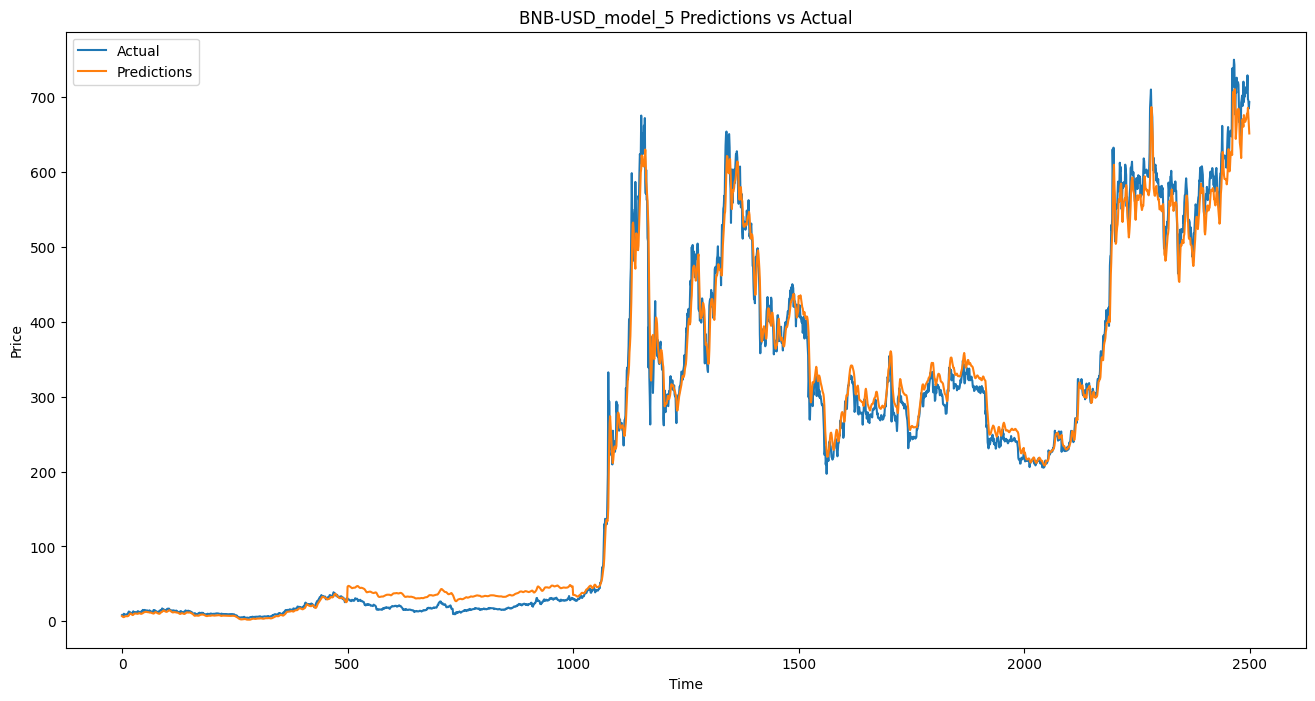

Training BNB-USD_model_6 with K-Fold Cross-Validation and Bayesian Optimization: ['GRU', 'LSTM', 'GRU', 'LSTM']
Fold 1
|   iter    |  target   | dropou... | lstm_u... |
-------------------------------------------------


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 1         | -0.005446 | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 2         | -0.009469 | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 3         | -0.005532 | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 4         | -0.009331 | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 5         | -0.004096 | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 6         | -0.004698 | 0.2091    | 65.34     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 7         | -0.003122 | 0.1605    | 65.77     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 8         | -0.002685 | 0.2935    | 66.42     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 9         | -0.00228  | 0.1048    | 67.05     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 10        | -0.002444 | 0.2772    | 67.78     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0784
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0039
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0031
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0030
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0030
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0025
Epoch 7/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0026
Epoch 8/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0024
Epoch 9/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0022
Epoch 10/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0022
Epoch 11/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0023
Epoch 12/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0021
Epoch 13/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0023
Epoch 14/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0018
Epoch 15/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0021
Epoch 16/60
32/

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 1         | -0.003496 | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 2         | -0.009142 | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 3         | -0.002759 | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 4         | -0.004138 | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 5         | -0.007687 | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 6         | -0.01217  | 0.2531    | 30.0      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 7         | -0.002859 | 0.1261    | 41.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 8         | -0.007237 | 0.2705    | 48.75     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 9         | -0.007055 | 0.2978    | 79.99     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 10        | -0.003508 | 0.2934    | 39.77     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0992
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0056
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0042
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0045
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0042
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0041
Epoch 7/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0035
Epoch 8/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0042
Epoch 9/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0037
Epoch 10/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0034
Epoch 11/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0032
Epoch 12/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0035
Epoch 13/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0035
Epoch 14/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0030
Epoch 15/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0028
Epoch 16/60
32/

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 1         | -0.06841  | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 2         | -0.07013  | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 3         | -0.07428  | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 4         | -0.06636  | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 5         | -0.07202  | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 6         | -0.07482  | 0.2973    | 52.08     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 7         | -0.07162  | 0.2925    | 70.62     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 8         | -0.07229  | 0.1203    | 56.08     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 9         | -0.06952  | 0.1011    | 53.19     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 10        | -0.0728   | 0.2335    | 62.11     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0519
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0020
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0017
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0017
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0014
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0016
Epoch 7/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0016
Epoch 8/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0015
Epoch 9/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0014
Epoch 10/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0013
Epoch 11/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0012
Epoch 12/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0012
Epoch 13/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0012
Epoch 14/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0012
Epoch 15/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0011
Epoch 16/60
32/

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 1         | -0.03476  | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 2         | -0.03569  | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 3         | -0.04783  | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 4         | -0.02391  | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 5         | -0.04258  | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 6         | -0.02718  | 0.2996    | 71.27     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 7         | -0.05171  | 0.1036    | 51.87     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 8         | -0.0478   | 0.1206    | 30.0      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 9         | -0.03306  | 0.2934    | 74.72     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 10        | -0.03285  | 0.2916    | 44.62     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0559
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0042
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0027
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0026
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0027
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0020
Epoch 7/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0021
Epoch 8/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0020
Epoch 9/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0024
Epoch 10/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0020
Epoch 11/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0016
Epoch 12/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0018
Epoch 13/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0017
Epoch 14/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0020
Epoch 15/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0017
Epoch 16/60
32/

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
| 1         | -0.07211  | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
| 2         | -0.04968  | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
| 3         | -0.03823  | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 4         | -0.05935  | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
| 5         | -0.06643  | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
| 6         | -0.04534  | 0.2147    | 39.51     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
| 7         | -0.07391  | 0.2984    | 34.42     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
| 8         | -0.05055  | 0.1911    | 57.6      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
| 9         | -0.07073  | 0.106     | 42.25     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
| 10        | -0.06973  | 0.2896    | 55.03     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0396
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0036
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0029
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0026
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0026
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0029
Epoch 7/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0027
Epoch 8/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0021
Epoch 9/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0026
Epoch 10/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0019
Epoch 11/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0016
Epoch 12/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0017
Epoch 13/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0019
Epoch 14/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0016
Epoch 15/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0018
Epoch 16/60
32/

Fold 5 Results:
  RMSE: 20.651130602050525
  MAE: 14.743655670166016
  R²: 0.9849170690515039
  LSTM Units: 37
  Dropout Rate: 0.1312037280884873
--------------------


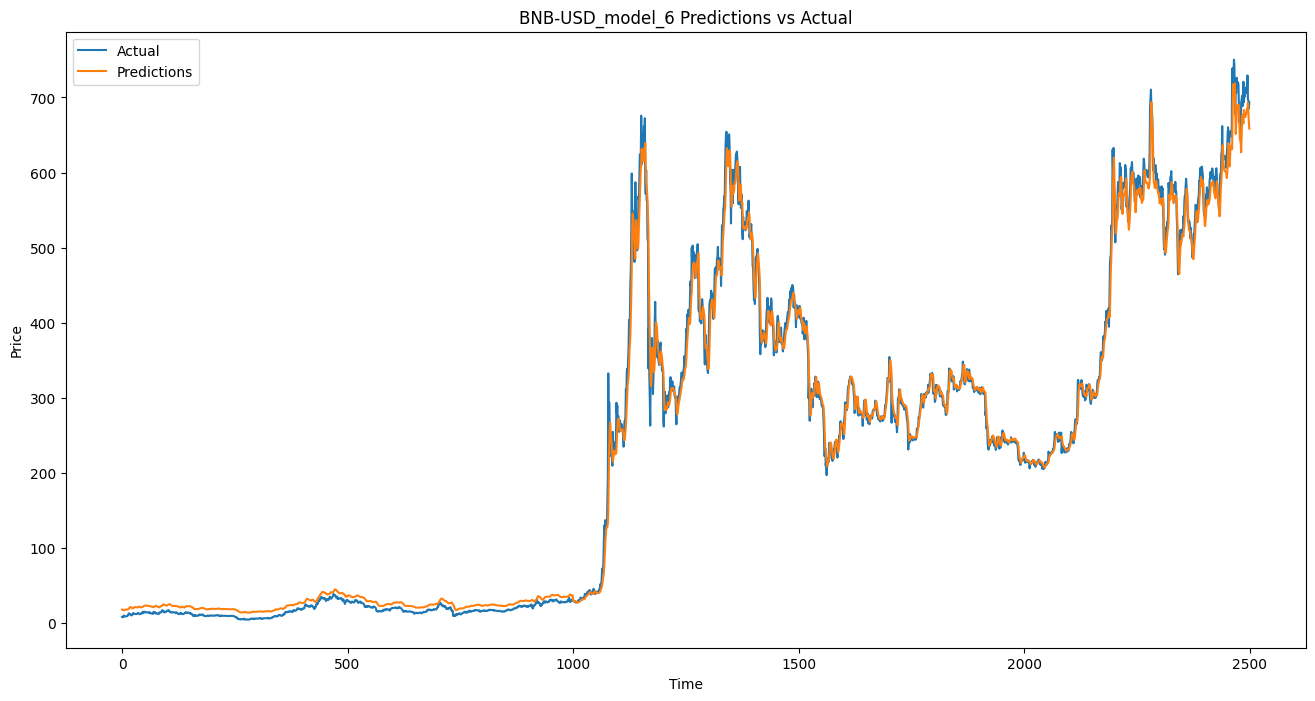

All evaluation results have been saved and the models are stored in the 'models' directory.


In [ ]:


# Create directories to save models, plots, and evaluation results
os.makedirs('models', exist_ok=True)
os.makedirs('plots', exist_ok=True)

# List of cryptocurrencies and model structures
cryptos = ['BNB-USD']
model_structures = [
    ['LSTM', 'LSTM', 'LSTM', 'LSTM'],
    ['GRU', 'GRU', 'GRU', 'GRU'],
    ['LSTM', 'LSTM', 'GRU', 'GRU'],
    ['GRU', 'GRU', 'LSTM', 'LSTM'],
    ['LSTM', 'GRU', 'LSTM', 'GRU'],
    ['GRU', 'LSTM', 'GRU', 'LSTM']
]

# Function to prepare the dataset
def prepare_data(crypto, time_step=120):
    data = yf.download(crypto, start='2014-01-01')
    data = data[['Close']]

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    X, y = [], []
    for i in range(len(scaled_data) - time_step - 1):
        X.append(scaled_data[i:(i + time_step), 0])
        y.append(scaled_data[i + time_step, 0])

    X = np.array(X).reshape(-1, time_step, 1)
    y = np.array(y)
    return data, X, y, scaler

# Function to build the model
def build_model(structure, time_step, lstm_units, dropout_rate):
    model = Sequential()
    for i, layer_type in enumerate(structure):
        if i == 0:
            if layer_type == 'LSTM':
                model.add(LSTM(lstm_units, return_sequences=True, input_shape=(time_step, 1)))
            elif layer_type == 'GRU':
                model.add(GRU(lstm_units, return_sequences=True, input_shape=(time_step, 1)))
        elif i == len(structure) - 1:
            if layer_type == 'LSTM':
                model.add(LSTM(lstm_units))
            elif layer_type == 'GRU':
                model.add(GRU(lstm_units))
        else:
            if layer_type == 'LSTM':
                model.add(LSTM(lstm_units, return_sequences=True))
            elif layer_type == 'GRU':
                model.add(GRU(lstm_units, return_sequences=True))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Dictionary to store evaluation results
evaluation_results = {}

# Bayesian Optimization function
def bayesian_optimization(structure, X_train, y_train, X_val, y_val):
    def model_evaluate(lstm_units, dropout_rate):
        model = build_model(structure, X_train.shape[1], int(lstm_units), dropout_rate)
        model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=0)
        val_predict = model.predict(X_val)
        val_rmse = np.sqrt(mean_squared_error(y_val, val_predict))
        return -val_rmse

    pbounds = {'lstm_units': (30, 80), 'dropout_rate': (0.1, 0.3)}
    optimizer = BayesianOptimization(f=model_evaluate, pbounds=pbounds, random_state=42)
    optimizer.maximize(init_points=5, n_iter=5)
    best_params = optimizer.max['params']
    return int(best_params['lstm_units']), best_params['dropout_rate']

# Train and evaluate the models for each cryptocurrency using K-Fold Cross-Validation
kf = KFold(n_splits=5)

for crypto in cryptos:
    data, X, y, scaler = prepare_data(crypto=crypto)

    for idx, structure in enumerate(model_structures):
        model_name = f'{crypto}_model_{idx + 1}'
        print(f"Training {model_name} with K-Fold Cross-Validation and Bayesian Optimization: {structure}")

        best_r2_score = -1  # Initialize with a very low value
        best_model = None

        fold_results = []  # List to store fold results
        all_predictions = []  # List to store predictions for plotting
        all_actual_values = []  # List to store actual values for plotting

        for fold, (train_index, val_index) in enumerate(kf.split(X)):
            print(f"Fold {fold + 1}")
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]

            # Bayesian Optimization for hyperparameters
            lstm_units, dropout_rate = bayesian_optimization(structure, X_train, y_train, X_val, y_val)

            # Build and train the model with optimized hyperparameters
            model = build_model(structure, X_train.shape[1], lstm_units, dropout_rate)
            model.fit(X_train, y_train, epochs=60, batch_size=64, verbose=1)

            # Predicting
            val_predict = model.predict(X_val)

            # Inverse transform to get actual values
            val_predict = scaler.inverse_transform(val_predict)
            y_val_actual = scaler.inverse_transform(y_val.reshape(-1, 1))

            # Append predictions and actual values to lists for plotting
            all_predictions.append(val_predict)
            all_actual_values.append(y_val_actual)

            # Evaluate the model on the validation set
            rmse = np.sqrt(mean_squared_error(y_val_actual, val_predict))
            mae = mean_absolute_error(y_val_actual, val_predict)
            r2 = r2_score(y_val_actual, val_predict)

            # Store fold results along with hyperparameters
            fold_results.append({
                'fold': fold + 1,
                'RMSE': rmse,
                'MAE': mae,
                'R²': r2,
                'LSTM Units': lstm_units,
                'Dropout Rate': dropout_rate
            })

            # Print fold results
            print(f"Fold {fold + 1} Results:")
            print(f"  RMSE: {rmse}")
            print(f"  MAE: {mae}")
            print(f"  R²: {r2}")
            print(f"  LSTM Units: {lstm_units}")
            print(f"  Dropout Rate: {dropout_rate}")
            print("-" * 20)  # Separator between folds

            # Check if current fold has the best R2 score
            if r2 > best_r2_score:
                best_r2_score = r2
                best_model = model

        # Save the best model
        if best_model is not None:
            model_filename = f'{model_name}_best.h5'
            model_path = os.path.join('models', model_filename)
            best_model.save(model_path)

        # Concatenate predictions and actual values from all folds for plotting
        all_predictions = np.concatenate(all_predictions)
        all_actual_values = np.concatenate(all_actual_values)

        # Create and save plot
        plt.figure(figsize=(16, 8))
        plt.plot(all_actual_values, label='Actual')
        plt.plot(all_predictions, label='Predictions')
        plt.legend()
        plt.title(f'{model_name} Predictions vs Actual')
        plt.xlabel('Time')
        plt.ylabel('Price')
        plot_filename = f'{model_name}_plot.png'
        plot_path = os.path.join('plots', plot_filename)
        plt.savefig(plot_path)  # Save the plot to a file
        plt.show()

        # Store all fold results and best R2 score in evaluation_results
        evaluation_results[model_name] = {
            'structure': structure,
            'fold_results': fold_results,
            'best_r2_score': best_r2_score  # Add best R2 score
        }

# Save evaluation results to JSON file
with open('evaluation_results_kfold.json', 'w') as f:
    json.dump(evaluation_results, f, indent=4)

print("All evaluation results have been saved and the models are stored in the 'models' directory.")

[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training SOL-USD_model_1 with K-Fold Cross-Validation and Bayesian Optimization: ['LSTM', 'LSTM', 'LSTM', 'LSTM']
Fold 1
|   iter    |  target   | dropou... | lstm_u... |
-------------------------------------------------
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
| 1         | -0.02001  | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
| 2         | -0.02003  | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
| 3         | -0.01903  | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
| 4         | -0.01667  | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
| 5         | -0.01873  | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
| 6         | -0.01726  | 0.1506    | 73.28     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
| 7         | -0.0164   | 0.1002    | 73.46     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
| 8         | -0.02121  | 0.1099    | 73.79     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
| 9         | -0.0171   | 0.2868    | 73.45     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
| 10        | -0.02031  | 0.1437    | 42.33     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0681
Epoch 2/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0081
Epoch 3/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0063
Epoch 4/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0063
Epoch 5/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0045
Epoch 6/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0059
Epoch 7/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0040
Epoch 8/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0043
Epoch 9/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0037
Epoch 10/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0038
Epoch 11/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0041
Epoch 12/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0031
Epoch 13/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0035
Epoch 14/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0031
Epoch 15/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0030
Epoch 16/60
21/

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
| 1         | -0.0858   | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
| 2         | -0.08691  | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
| 3         | -0.1024   | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
| 4         | -0.08513  | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
| 5         | -0.08774  | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
| 6         | -0.08611  | 0.105     | 52.41     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
| 7         | -0.09352  | 0.2872    | 55.59     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
| 8         | -0.08406  | 0.1203    | 56.08     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
| 9         | -0.08546  | 0.1108    | 52.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
| 10        | -0.09344  | 0.2225    | 52.3      |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0332
Epoch 2/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0048
Epoch 3/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0042
Epoch 4/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0029
Epoch 5/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0031
Epoch 6/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0032
Epoch 7/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0023
Epoch 8/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0024
Epoch 9/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0028
Epoch 10/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0022
Epoch 11/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0020
Epoch 12/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0023
Epoch 13/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0017
Epoch 14/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0018
Epoch 15/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0022
Epoch 16/60
21/

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
| 1         | -0.02116  | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
| 2         | -0.05049  | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
| 3         | -0.03546  | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
| 4         | -0.02449  | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
| 5         | -0.0244   | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
| 6         | -0.02519  | 0.2405    | 80.0      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
| 7         | -0.02456  | 0.2993    | 69.04     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
| 8         | -0.02368  | 0.2972    | 47.42     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
| 9         | -0.02185  | 0.1718    | 30.01     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
| 10        | -0.0215   | 0.1282    | 51.54     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0750
Epoch 2/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0092
Epoch 3/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0076
Epoch 4/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0070
Epoch 5/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0058
Epoch 6/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0054
Epoch 7/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0051
Epoch 8/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0048
Epoch 9/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0046
Epoch 10/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0041
Epoch 11/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0048
Epoch 12/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0043
Epoch 13/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0041
Epoch 14/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0039
Epoch 15/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0040
Epoch 16/60
21/

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
| 1         | -0.02614  | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
| 2         | -0.02993  | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
| 3         | -0.02738  | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
| 4         | -0.03195  | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
| 5         | -0.02569  | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
| 6         | -0.02826  | 0.2352    | 65.33     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
| 7         | -0.02925  | 0.2657    | 45.01     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
| 8         | -0.02825  | 0.1203    | 56.08     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
| 9         | -0.02518  | 0.2455    | 65.43     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
| 10        | -0.02704  | 0.1795    | 65.5      |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0993
Epoch 2/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0097
Epoch 3/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0082
Epoch 4/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0064
Epoch 5/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0067
Epoch 6/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0059
Epoch 7/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0060
Epoch 8/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0062
Epoch 9/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0050
Epoch 10/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0053
Epoch 11/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0056
Epoch 12/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0042
Epoch 13/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0057
Epoch 14/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0054
Epoch 15/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0046
Epoch 16/60
21/

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
| 1         | -0.06363  | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
| 2         | -0.07189  | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
| 3         | -0.06538  | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
| 4         | -0.07376  | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
| 5         | -0.06476  | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
| 6         | -0.06848  | 0.1162    | 77.57     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
| 7         | -0.07266  | 0.2657    | 45.01     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
| 8         | -0.0664   | 0.1203    | 56.08     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
| 9         | -0.06578  | 0.1011    | 53.19     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
| 10        | -0.07537  | 0.2335    | 62.11     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0323
Epoch 2/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0057
Epoch 3/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0045
Epoch 4/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0033
Epoch 5/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0030
Epoch 6/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0034
Epoch 7/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0029
Epoch 8/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0030
Epoch 9/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0027
Epoch 10/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0025
Epoch 11/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0025
Epoch 12/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0022
Epoch 13/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0021
Epoch 14/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0026
Epoch 15/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0030
Epoch 16/60
21/

Fold 5 Results:
  RMSE: 9.399970141412373
  MAE: 7.29494195235403
  R²: 0.9133882344932155
  LSTM Units: 77
  Dropout Rate: 0.1749080237694725
--------------------


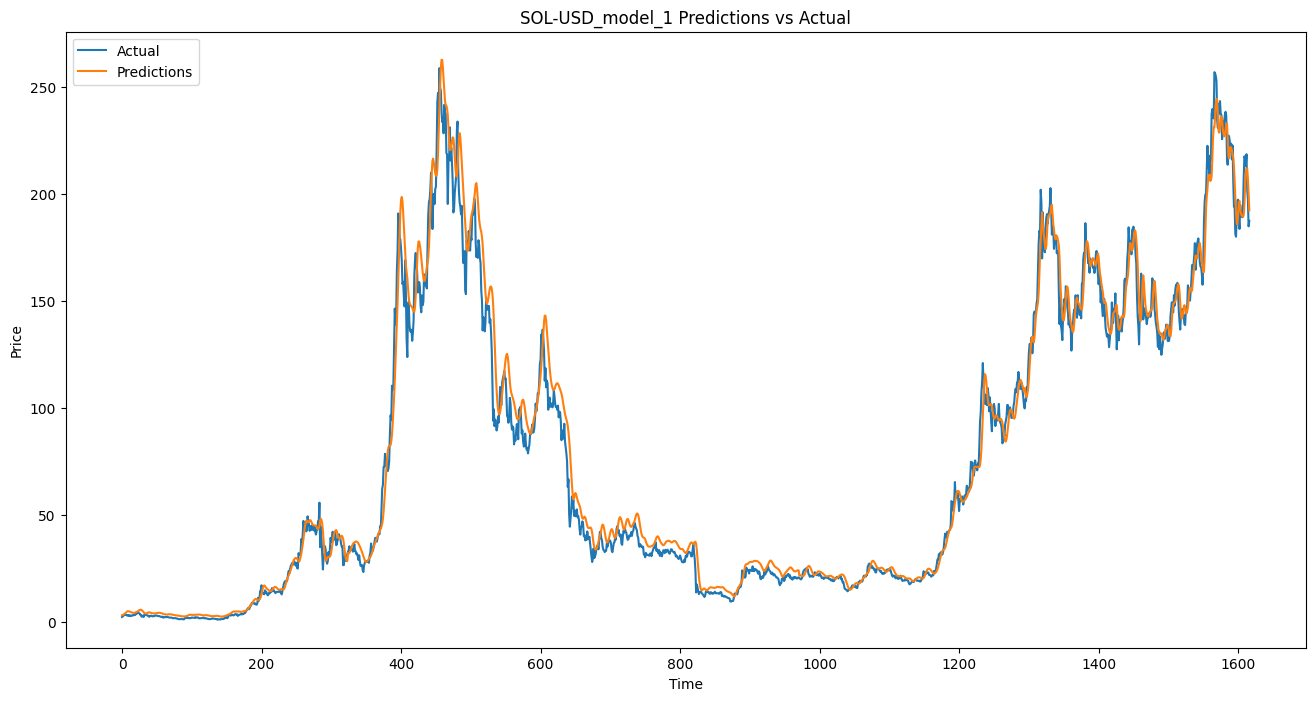

Training SOL-USD_model_2 with K-Fold Cross-Validation and Bayesian Optimization: ['GRU', 'GRU', 'GRU', 'GRU']
Fold 1
|   iter    |  target   | dropou... | lstm_u... |
-------------------------------------------------


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
| 1         | -0.01189  | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
| 2         | -0.01481  | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
| 3         | -0.01377  | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
| 4         | -0.01269  | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
| 5         | -0.0117   | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
| 6         | -0.01535  | 0.2386    | 66.66     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
| 7         | -0.01342  | 0.2196    | 65.41     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
| 8         | -0.01198  | 0.1203    | 56.08     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
| 9         | -0.0177   | 0.1011    | 53.19     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
| 10        | -0.01177  | 0.2335    | 62.11     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0519
Epoch 2/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0064
Epoch 3/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0042
Epoch 4/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0041
Epoch 5/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0044
Epoch 6/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0043
Epoch 7/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0040
Epoch 8/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0033
Epoch 9/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0033
Epoch 10/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0034
Epoch 11/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0037
Epoch 12/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0032
Epoch 13/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0027
Epoch 14/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0030
Epoch 15/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0029
Epoch 16/60
21/

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
| 1         | -0.07022  | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
| 2         | -0.06272  | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
| 3         | -0.063    | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
| 4         | -0.05637  | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
| 5         | -0.05684  | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
| 6         | -0.05563  | 0.1777    | 73.29     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
| 7         | -0.05843  | 0.2829    | 72.56     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
| 8         | -0.06153  | 0.298     | 74.11     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
| 9         | -0.05936  | 0.1304    | 64.58     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
| 10        | -0.06006  | 0.1572    | 66.24     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0417
Epoch 2/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0040
Epoch 3/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0024
Epoch 4/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0022
Epoch 5/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0020
Epoch 6/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0022
Epoch 7/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0022
Epoch 8/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0023
Epoch 9/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0021
Epoch 10/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0015
Epoch 11/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0018
Epoch 12/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0019
Epoch 13/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0017
Epoch 14/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0016
Epoch 15/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0015
Epoch 16/60
21/

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
| 1         | -0.02188  | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
| 2         | -0.01332  | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
| 3         | -0.01656  | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
| 4         | -0.01203  | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
| 5         | -0.01377  | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
| 6         | -0.01314  | 0.1813    | 73.29     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
| 7         | -0.01111  | 0.1014    | 73.63     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
| 8         | -0.01183  | 0.1282    | 74.17     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
| 9         | -0.01254  | 0.1229    | 74.9      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
| 10        | -0.01158  | 0.2276    | 75.65     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0659
Epoch 2/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0040
Epoch 3/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0032
Epoch 4/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0031
Epoch 5/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0025
Epoch 6/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0024
Epoch 7/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0024
Epoch 8/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0024
Epoch 9/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0022
Epoch 10/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0024
Epoch 11/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0020
Epoch 12/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0021
Epoch 13/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0021
Epoch 14/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0020
Epoch 15/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0017
Epoch 16/60
21/

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
| 1         | -0.01935  | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
| 2         | -0.01895  | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
| 3         | -0.02585  | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
| 4         | -0.02069  | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
| 5         | -0.02086  | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
| 6         | -0.01837  | 0.1107    | 52.74     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
| 7         | -0.01937  | 0.202     | 52.78     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
| 8         | -0.01827  | 0.1035    | 52.35     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
| 9         | -0.01951  | 0.2226    | 60.59     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
| 10        | -0.01873  | 0.1034    | 51.69     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0669
Epoch 2/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0062
Epoch 3/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0033
Epoch 4/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0029
Epoch 5/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0031
Epoch 6/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0031
Epoch 7/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0031
Epoch 8/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0021
Epoch 9/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0024
Epoch 10/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0026
Epoch 11/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0024
Epoch 12/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0023
Epoch 13/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0021
Epoch 14/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0022
Epoch 15/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0021
Epoch 16/60
21/

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
| 1         | -0.04295  | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
| 2         | -0.08178  | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
| 3         | -0.0494   | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
| 4         | -0.04805  | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
| 5         | -0.06803  | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
| 6         | -0.05286  | 0.2531    | 30.0      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
| 7         | -0.04509  | 0.2972    | 80.0      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
| 8         | -0.06691  | 0.2907    | 44.72     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
| 9         | -0.04952  | 0.2972    | 76.37     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
| 10        | -0.04891  | 0.1005    | 34.13     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0192
Epoch 2/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0034
Epoch 3/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0024
Epoch 4/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0027
Epoch 5/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0015
Epoch 6/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0018
Epoch 7/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0013
Epoch 8/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0015
Epoch 9/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0017
Epoch 10/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0015
Epoch 11/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0033
Epoch 12/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0017
Epoch 13/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0013
Epoch 14/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0013
Epoch 15/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0013
Epoch 16/60
21/

Fold 5 Results:
  RMSE: 12.870349801683185
  MAE: 10.95645143963604
  R²: 0.8376304284680316
  LSTM Units: 77
  Dropout Rate: 0.1749080237694725
--------------------


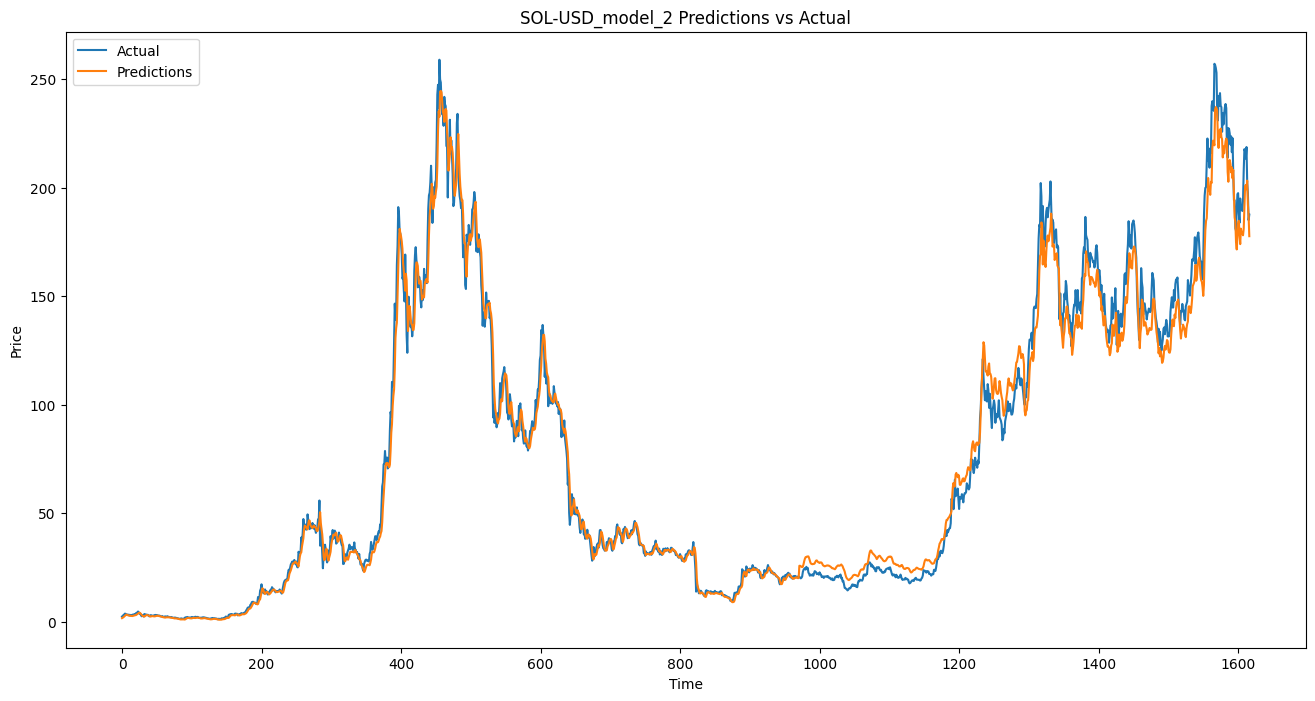

Training SOL-USD_model_3 with K-Fold Cross-Validation and Bayesian Optimization: ['LSTM', 'LSTM', 'GRU', 'GRU']
Fold 1
|   iter    |  target   | dropou... | lstm_u... |
-------------------------------------------------


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 1         | -0.01776  | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
| 2         | -0.02102  | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
| 3         | -0.01553  | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 4         | -0.01568  | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 5         | -0.01823  | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 6         | -0.01571  | 0.1895    | 33.62     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 7         | -0.01691  | 0.2858    | 44.79     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 8         | -0.01536  | 0.1206    | 30.0      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
| 9         | -0.01501  | 0.2946    | 70.23     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
| 10        | -0.01502  | 0.2954    | 40.76     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0758
Epoch 2/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0085
Epoch 3/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0079
Epoch 4/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0072
Epoch 5/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0057
Epoch 6/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0058
Epoch 7/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0059
Epoch 8/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0055
Epoch 9/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0054
Epoch 10/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0051
Epoch 11/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0041
Epoch 12/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0045
Epoch 13/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0047
Epoch 14/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0041
Epoch 15/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0049
Epoch 16/60
21/

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 1         | -0.08614  | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
| 2         | -0.0826   | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
| 3         | -0.08093  | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
| 4         | -0.07253  | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
| 5         | -0.09903  | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 6         | -0.07575  | 0.1597    | 73.35     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 7         | -0.07494  | 0.1176    | 73.07     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
| 8         | -0.07189  | 0.119     | 72.59     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
| 9         | -0.07575  | 0.2226    | 72.29     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 10        | -0.07577  | 0.1013    | 71.76     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0435
Epoch 2/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0054
Epoch 3/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0028
Epoch 4/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0027
Epoch 5/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0024
Epoch 6/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0019
Epoch 7/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0021
Epoch 8/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0017
Epoch 9/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0017
Epoch 10/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0020
Epoch 11/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0021
Epoch 12/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0020
Epoch 13/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0018
Epoch 14/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0015
Epoch 15/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0020
Epoch 16/60
21/

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
| 1         | -0.01405  | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
| 2         | -0.01728  | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 3         | -0.02191  | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 4         | -0.01982  | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
| 5         | -0.03171  | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 6         | -0.02199  | 0.1402    | 76.12     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 7         | -0.01941  | 0.1558    | 77.46     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 8         | -0.01573  | 0.1203    | 56.08     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
| 9         | -0.01365  | 0.1991    | 77.6      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 10        | -0.02043  | 0.1095    | 77.75     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0584
Epoch 2/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0073
Epoch 3/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0061
Epoch 4/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0047
Epoch 5/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0048
Epoch 6/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0040
Epoch 7/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0040
Epoch 8/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0044
Epoch 9/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0038
Epoch 10/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0036
Epoch 11/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0038
Epoch 12/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0037
Epoch 13/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0035
Epoch 14/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0038
Epoch 15/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0031
Epoch 16/60
21/

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
| 1         | -0.02227  | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 2         | -0.0241   | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 3         | -0.02381  | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
| 4         | -0.02276  | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 5         | -0.02289  | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 6         | -0.0221   | 0.2405    | 80.0      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 7         | -0.03056  | 0.2381    | 30.0      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 8         | -0.02372  | 0.1463    | 46.72     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
| 9         | -0.02482  | 0.2953    | 42.1      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 10        | -0.02688  | 0.1217    | 52.8      |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0632
Epoch 2/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0064
Epoch 3/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0060
Epoch 4/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0061
Epoch 5/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0053
Epoch 6/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0045
Epoch 7/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0046
Epoch 8/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0036
Epoch 9/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0045
Epoch 10/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0040
Epoch 11/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0038
Epoch 12/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0039
Epoch 13/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0033
Epoch 14/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0036
Epoch 15/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0035
Epoch 16/60
21/

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
| 1         | -0.05685  | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 2         | -0.06037  | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
| 3         | -0.09552  | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
| 4         | -0.05236  | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
| 5         | -0.08528  | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
| 6         | -0.05734  | 0.2882    | 55.35     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
| 7         | -0.05526  | 0.1008    | 49.45     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
| 8         | -0.1069   | 0.1206    | 30.0      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
| 9         | -0.06886  | 0.295     | 45.18     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
| 10        | -0.09807  | 0.2992    | 79.99     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0409
Epoch 2/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0061
Epoch 3/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0034
Epoch 4/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0032
Epoch 5/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0024
Epoch 6/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0020
Epoch 7/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0025
Epoch 8/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0019
Epoch 9/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0026
Epoch 10/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0018
Epoch 11/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0018
Epoch 12/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0017
Epoch 13/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0018
Epoch 14/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0015
Epoch 15/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0014
Epoch 16/60
21/

Fold 5 Results:
  RMSE: 8.301209078493585
  MAE: 6.359708591142306
  R²: 0.9324529093671319
  LSTM Units: 73
  Dropout Rate: 0.1116167224336399
--------------------


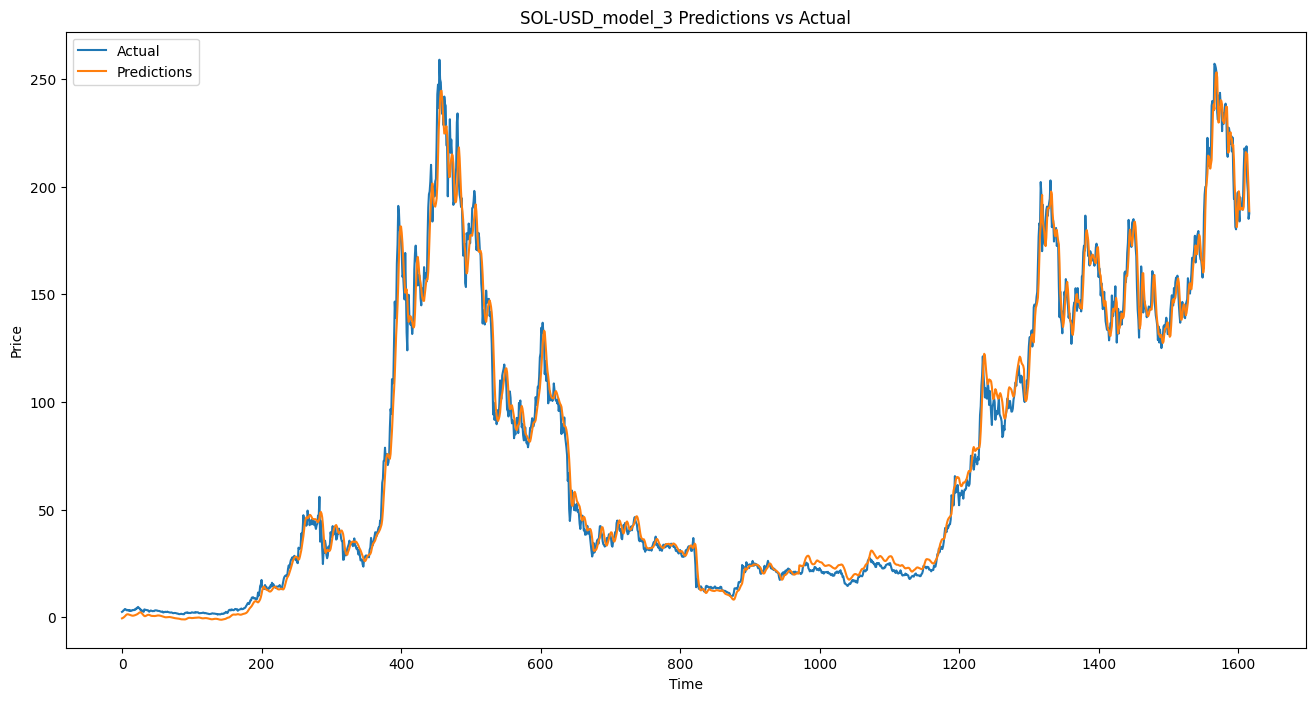

Training SOL-USD_model_4 with K-Fold Cross-Validation and Bayesian Optimization: ['GRU', 'GRU', 'LSTM', 'LSTM']
Fold 1
|   iter    |  target   | dropou... | lstm_u... |
-------------------------------------------------


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
| 1         | -0.01495  | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
| 2         | -0.01765  | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
| 3         | -0.01614  | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
| 4         | -0.01414  | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
| 5         | -0.01896  | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
| 6         | -0.01503  | 0.2733    | 46.97     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
| 7         | -0.01448  | 0.1041    | 51.95     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
| 8         | -0.01435  | 0.1206    | 30.0      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
| 9         | -0.01946  | 0.2874    | 33.09     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
| 10        | -0.01947  | 0.2335    | 62.11     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0635
Epoch 2/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0077
Epoch 3/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0045
Epoch 4/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0036
Epoch 5/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0032
Epoch 6/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0030
Epoch 7/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0032
Epoch 8/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0030
Epoch 9/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0030
Epoch 10/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0027
Epoch 11/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0028
Epoch 12/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0025
Epoch 13/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0024
Epoch 14/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0023
Epoch 15/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0029
Epoch 16/60
21/

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
| 1         | -0.07016  | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
| 2         | -0.07771  | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
| 3         | -0.07693  | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
| 4         | -0.07097  | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
| 5         | -0.07286  | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
| 6         | -0.07123  | 0.2405    | 80.0      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
| 7         | -0.08747  | 0.2381    | 30.0      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 8         | -0.07652  | 0.1008    | 46.89     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
| 9         | -0.08454  | 0.2998    | 69.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
| 10        | -0.07817  | 0.2962    | 75.41     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0451
Epoch 2/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0062
Epoch 3/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0028
Epoch 4/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0022
Epoch 5/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0020
Epoch 6/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0020
Epoch 7/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0020
Epoch 8/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0019
Epoch 9/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0021
Epoch 10/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0020
Epoch 11/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0023
Epoch 12/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0019
Epoch 13/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0020
Epoch 14/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0020
Epoch 15/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0020
Epoch 16/60
21/

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
| 1         | -0.01607  | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
| 2         | -0.02595  | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
| 3         | -0.01706  | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
| 4         | -0.01554  | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
| 5         | -0.01588  | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 6         | -0.01411  | 0.2759    | 75.35     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
| 7         | -0.01861  | 0.2381    | 30.0      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
| 8         | -0.02176  | 0.1008    | 44.78     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
| 9         | -0.02832  | 0.2976    | 68.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
| 10        | -0.02555  | 0.1776    | 34.91     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0674
Epoch 2/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0075
Epoch 3/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0055
Epoch 4/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0048
Epoch 5/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0054
Epoch 6/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0050
Epoch 7/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0048
Epoch 8/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0058
Epoch 9/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0041
Epoch 10/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0037
Epoch 11/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0038
Epoch 12/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0047
Epoch 13/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0040
Epoch 14/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0034
Epoch 15/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0040
Epoch 16/60
21/

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
| 1         | -0.02389  | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 2         | -0.03117  | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 3         | -0.02307  | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
| 4         | -0.02214  | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
| 5         | -0.02175  | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 6         | -0.0237   | 0.238     | 66.6      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
| 7         | -0.02143  | 0.281     | 70.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
| 8         | -0.0247   | 0.275     | 41.71     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 9         | -0.02453  | 0.1963    | 34.29     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
| 10        | -0.02157  | 0.1105    | 49.81     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0773
Epoch 2/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0066
Epoch 3/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0064
Epoch 4/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0060
Epoch 5/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0054
Epoch 6/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0042
Epoch 7/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0045
Epoch 8/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0045
Epoch 9/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0038
Epoch 10/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0054
Epoch 11/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0043
Epoch 12/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0038
Epoch 13/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0036
Epoch 14/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0036
Epoch 15/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0035
Epoch 16/60
21/

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
| 1         | -0.05046  | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
| 2         | -0.05774  | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 3         | -0.06381  | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 4         | -0.05161  | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 5         | -0.05345  | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 6         | -0.08572  | 0.2405    | 80.0      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
| 7         | -0.06008  | 0.2309    | 77.62     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 8         | -0.05741  | 0.157     | 77.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 9         | -0.05432  | 0.2055    | 77.53     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
| 10        | -0.0587   | 0.299     | 73.32     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0296
Epoch 2/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0044
Epoch 3/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0028
Epoch 4/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0020
Epoch 5/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0022
Epoch 6/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0023
Epoch 7/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0019
Epoch 8/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0032
Epoch 9/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0020
Epoch 10/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0023
Epoch 11/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0017
Epoch 12/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0018
Epoch 13/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0020
Epoch 14/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0015
Epoch 15/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0015
Epoch 16/60
21/

Fold 5 Results:
  RMSE: 7.730598729309687
  MAE: 5.896243092445397
  R²: 0.9414198869754229
  LSTM Units: 77
  Dropout Rate: 0.1749080237694725
--------------------


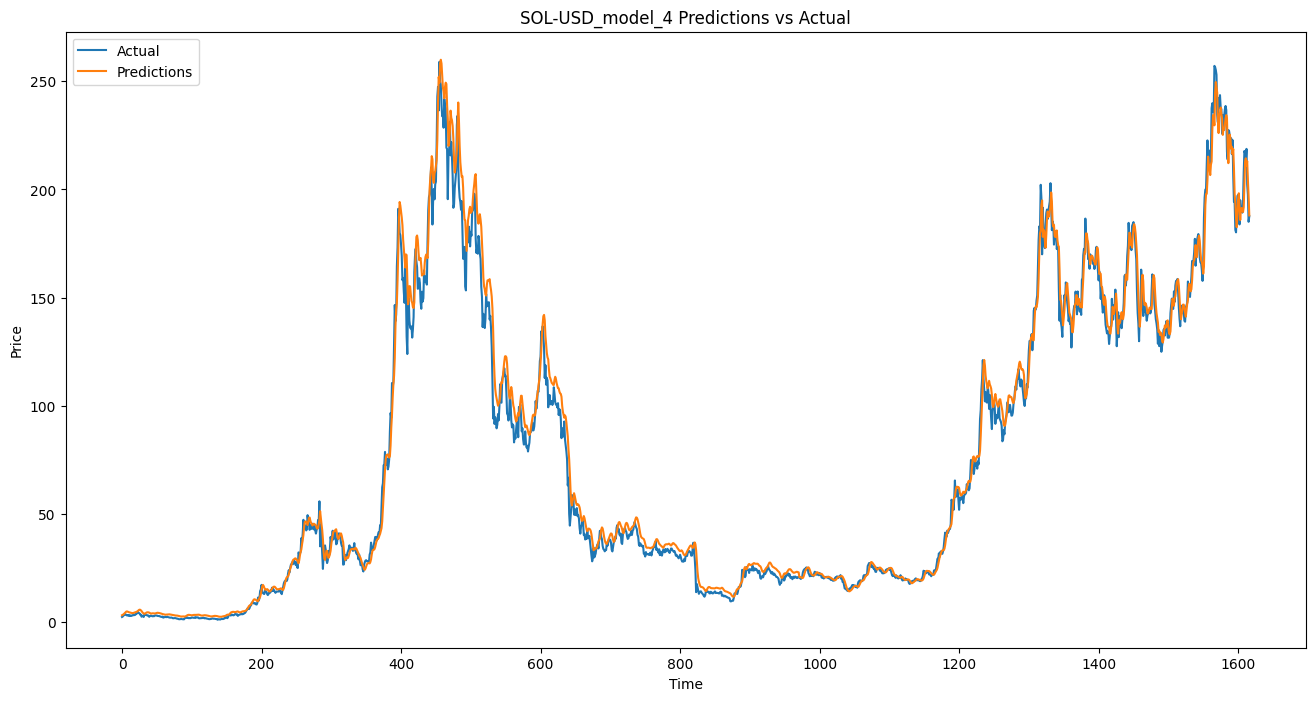

Training SOL-USD_model_5 with K-Fold Cross-Validation and Bayesian Optimization: ['LSTM', 'GRU', 'LSTM', 'GRU']
Fold 1
|   iter    |  target   | dropou... | lstm_u... |
-------------------------------------------------


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 1         | -0.01449  | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
| 2         | -0.01756  | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 3         | -0.01449  | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
| 4         | -0.0176   | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
| 5         | -0.01706  | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 6         | -0.0149   | 0.1849    | 37.84     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 7         | -0.01618  | 0.1091    | 37.48     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 8         | -0.01418  | 0.2498    | 77.3      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 9         | -0.01735  | 0.1086    | 77.03     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 10        | -0.01356  | 0.1047    | 77.38     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0657
Epoch 2/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0058
Epoch 3/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0045
Epoch 4/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0045
Epoch 5/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0039
Epoch 6/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0032
Epoch 7/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0036
Epoch 8/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0035
Epoch 9/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0028
Epoch 10/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0031
Epoch 11/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0029
Epoch 12/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0025
Epoch 13/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0024
Epoch 14/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0026
Epoch 15/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0027
Epoch 16/60
21/

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
| 1         | -0.08586  | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 2         | -0.07783  | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
| 3         | -0.07723  | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 4         | -0.07399  | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 5         | -0.07347  | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 6         | -0.07089  | 0.1518    | 65.43     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 7         | -0.07663  | 0.1046    | 65.61     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 8         | -0.07066  | 0.1203    | 56.08     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 9         | -0.07482  | 0.1036    | 55.94     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 10        | -0.07402  | 0.1612    | 56.21     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0419
Epoch 2/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0037
Epoch 3/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0026
Epoch 4/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0025
Epoch 5/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0023
Epoch 6/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0021
Epoch 7/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0022
Epoch 8/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0020
Epoch 9/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0020
Epoch 10/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0020
Epoch 11/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0017
Epoch 12/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0017
Epoch 13/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0016
Epoch 14/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0019
Epoch 15/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0019
Epoch 16/60
21/

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
| 1         | -0.03238  | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 2         | -0.01624  | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
| 3         | -0.01508  | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
| 4         | -0.01711  | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 5         | -0.01803  | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
| 6         | -0.01623  | 0.1088    | 37.88     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 7         | -0.02348  | 0.262     | 36.98     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 8         | -0.01931  | 0.1217    | 60.55     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 9         | -0.01588  | 0.102     | 59.33     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
| 10        | -0.02378  | 0.2576    | 58.68     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0953
Epoch 2/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0082
Epoch 3/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0056
Epoch 4/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0062
Epoch 5/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0058
Epoch 6/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0053
Epoch 7/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0049
Epoch 8/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0049
Epoch 9/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0049
Epoch 10/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0044
Epoch 11/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0041
Epoch 12/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0040
Epoch 13/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0036
Epoch 14/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0041
Epoch 15/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0060
Epoch 16/60
21/

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
| 1         | -0.02219  | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 2         | -0.02588  | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
| 3         | -0.02371  | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 4         | -0.02152  | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 5         | -0.02245  | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 6         | -0.02219  | 0.2319    | 69.81     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 7         | -0.02493  | 0.2984    | 47.43     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
| 8         | -0.0262   | 0.1206    | 30.0      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
| 9         | -0.02332  | 0.2978    | 79.99     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 10        | -0.02308  | 0.2991    | 75.06     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0642
Epoch 2/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0079
Epoch 3/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0046
Epoch 4/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0046
Epoch 5/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0038
Epoch 6/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0042
Epoch 7/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0032
Epoch 8/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0031
Epoch 9/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0036
Epoch 10/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0030
Epoch 11/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0034
Epoch 12/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0024
Epoch 13/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0027
Epoch 14/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0032
Epoch 15/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0024
Epoch 16/60
21/

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 1         | -0.05155  | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 2         | -0.06858  | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 3         | -0.06619  | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 4         | -0.0564   | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 5         | -0.058    | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
| 6         | -0.07876  | 0.2405    | 80.0      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 7         | -0.05232  | 0.1558    | 77.46     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
| 8         | -0.05404  | 0.2729    | 74.69     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 9         | -0.05563  | 0.2818    | 75.87     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
| 10        | -0.09693  | 0.295     | 71.35     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0183
Epoch 2/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0042
Epoch 3/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0029
Epoch 4/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0023
Epoch 5/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0024
Epoch 6/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0032
Epoch 7/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0025
Epoch 8/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0021
Epoch 9/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0024
Epoch 10/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0021
Epoch 11/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0018
Epoch 12/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0026
Epoch 13/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0018
Epoch 14/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0015
Epoch 15/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0019
Epoch 16/60
21/

Fold 5 Results:
  RMSE: 9.079713087223961
  MAE: 7.096085917469887
  R²: 0.919189425569713
  LSTM Units: 77
  Dropout Rate: 0.1749080237694725
--------------------


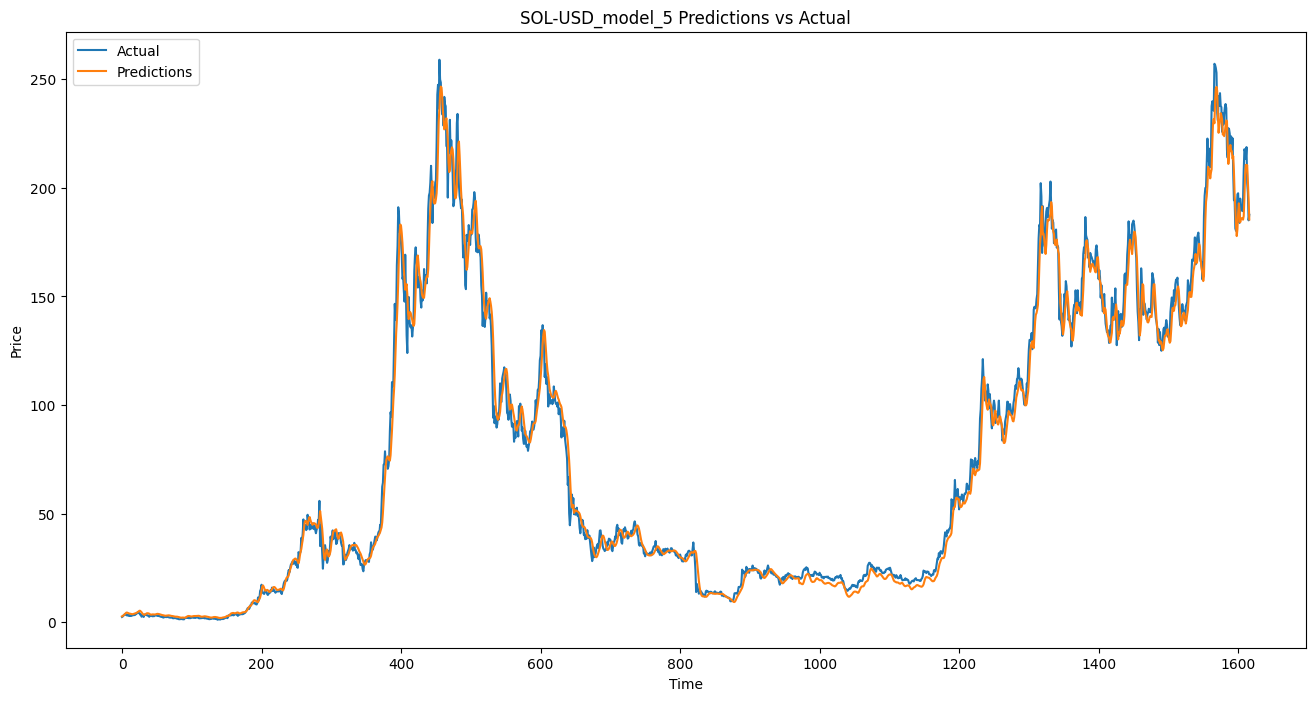

Training SOL-USD_model_6 with K-Fold Cross-Validation and Bayesian Optimization: ['GRU', 'LSTM', 'GRU', 'LSTM']
Fold 1
|   iter    |  target   | dropou... | lstm_u... |
-------------------------------------------------


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 1         | -0.0161   | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 2         | -0.0213   | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
| 3         | -0.01476  | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 4         | -0.01411  | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
| 5         | -0.01506  | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 6         | -0.01304  | 0.1259    | 74.44     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
| 7         | -0.01621  | 0.1266    | 33.61     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 8         | -0.01494  | 0.1968    | 41.55     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
| 9         | -0.0164   | 0.1423    | 45.85     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 10        | -0.01488  | 0.2607    | 68.86     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0513
Epoch 2/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0062
Epoch 3/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0046
Epoch 4/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0048
Epoch 5/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0038
Epoch 6/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0043
Epoch 7/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0037
Epoch 8/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0028
Epoch 9/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0036
Epoch 10/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0030
Epoch 11/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0027
Epoch 12/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0025
Epoch 13/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0026
Epoch 14/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0024
Epoch 15/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0026
Epoch 16/60
21/

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
| 1         | -0.08528  | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 2         | -0.07583  | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 3         | -0.0788   | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 4         | -0.06866  | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
| 5         | -0.07823  | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
| 6         | -0.08873  | 0.1517    | 73.35     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
| 7         | -0.07869  | 0.2657    | 45.01     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
| 8         | -0.08008  | 0.1203    | 56.08     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
| 9         | -0.06984  | 0.1011    | 53.19     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
| 10        | -0.0801   | 0.2335    | 62.11     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0491
Epoch 2/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0041
Epoch 3/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0027
Epoch 4/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0023
Epoch 5/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0022
Epoch 6/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0018
Epoch 7/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0022
Epoch 8/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0017
Epoch 9/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0013
Epoch 10/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0016
Epoch 11/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0014
Epoch 12/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0013
Epoch 13/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0014
Epoch 14/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0013
Epoch 15/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0015
Epoch 16/60
21/

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
| 1         | -0.01525  | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 2         | -0.01545  | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 3         | -0.01543  | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 4         | -0.01731  | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 5         | -0.01376  | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
| 6         | -0.02322  | 0.2703    | 65.43     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 7         | -0.01819  | 0.2657    | 45.01     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 8         | -0.01587  | 0.1203    | 56.08     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
| 9         | -0.01993  | 0.1011    | 53.19     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
| 10        | -0.0195   | 0.2335    | 62.11     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0618
Epoch 2/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0088
Epoch 3/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0061
Epoch 4/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0047
Epoch 5/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0049
Epoch 6/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0043
Epoch 7/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0043
Epoch 8/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0043
Epoch 9/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0035
Epoch 10/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0033
Epoch 11/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0035
Epoch 12/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0039
Epoch 13/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0033
Epoch 14/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0031
Epoch 15/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0033
Epoch 16/60
21/

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
| 1         | -0.02301  | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
| 2         | -0.0264   | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 3         | -0.02242  | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
| 4         | -0.02095  | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 5         | -0.02409  | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
| 6         | -0.02568  | 0.2966    | 70.42     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
| 7         | -0.02113  | 0.1747    | 73.35     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 8         | -0.02128  | 0.1192    | 72.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 9         | -0.02348  | 0.104     | 40.12     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 10        | -0.02345  | 0.1048    | 35.69     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0732
Epoch 2/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0066
Epoch 3/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0043
Epoch 4/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0048
Epoch 5/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0035
Epoch 6/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0028
Epoch 7/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0033
Epoch 8/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0027
Epoch 9/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0035
Epoch 10/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0028
Epoch 11/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0026
Epoch 12/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0025
Epoch 13/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0031
Epoch 14/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0023
Epoch 15/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0028
Epoch 16/60
21/

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
| 1         | -0.05066  | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
| 2         | -0.07608  | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 3         | -0.05177  | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
| 4         | -0.0487   | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 5         | -0.06018  | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 6         | -0.05997  | 0.2531    | 30.0      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 7         | -0.05706  | 0.2892    | 44.83     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
| 8         | -0.07178  | 0.2879    | 70.09     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 9         | -0.05753  | 0.1011    | 53.19     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 10        | -0.05471  | 0.2335    | 62.11     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0376
Epoch 2/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0037
Epoch 3/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0026
Epoch 4/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0024
Epoch 5/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0022
Epoch 6/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0023
Epoch 7/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0021
Epoch 8/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0019
Epoch 9/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0017
Epoch 10/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0016
Epoch 11/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0020
Epoch 12/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0015
Epoch 13/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0014
Epoch 14/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0014
Epoch 15/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0016
Epoch 16/60
21/

Fold 5 Results:
  RMSE: 9.978858502209492
  MAE: 7.905888064357887
  R²: 0.9023919419951731
  LSTM Units: 73
  Dropout Rate: 0.1116167224336399
--------------------


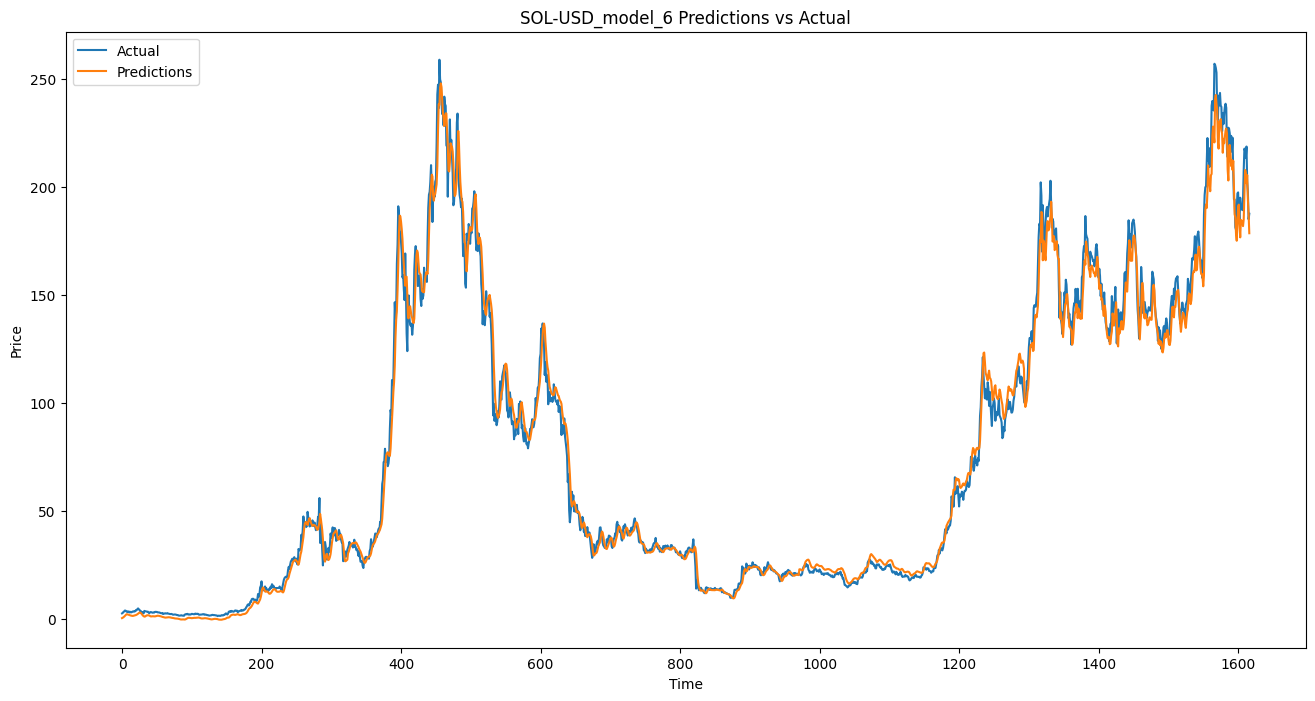

All evaluation results have been saved and the models are stored in the 'models' directory.


In [ ]:


# Create directories to save models, plots, and evaluation results
os.makedirs('models', exist_ok=True)
os.makedirs('plots', exist_ok=True)

# List of cryptocurrencies and model structures
cryptos = ['SOL-USD']
model_structures = [
    ['LSTM', 'LSTM', 'LSTM', 'LSTM'],
    ['GRU', 'GRU', 'GRU', 'GRU'],
    ['LSTM', 'LSTM', 'GRU', 'GRU'],
    ['GRU', 'GRU', 'LSTM', 'LSTM'],
    ['LSTM', 'GRU', 'LSTM', 'GRU'],
    ['GRU', 'LSTM', 'GRU', 'LSTM']
]

# Function to prepare the dataset
def prepare_data(crypto, time_step=120):
    data = yf.download(crypto, start='2014-01-01')
    data = data[['Close']]

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    X, y = [], []
    for i in range(len(scaled_data) - time_step - 1):
        X.append(scaled_data[i:(i + time_step), 0])
        y.append(scaled_data[i + time_step, 0])

    X = np.array(X).reshape(-1, time_step, 1)
    y = np.array(y)
    return data, X, y, scaler

# Function to build the model
def build_model(structure, time_step, lstm_units, dropout_rate):
    model = Sequential()
    for i, layer_type in enumerate(structure):
        if i == 0:
            if layer_type == 'LSTM':
                model.add(LSTM(lstm_units, return_sequences=True, input_shape=(time_step, 1)))
            elif layer_type == 'GRU':
                model.add(GRU(lstm_units, return_sequences=True, input_shape=(time_step, 1)))
        elif i == len(structure) - 1:
            if layer_type == 'LSTM':
                model.add(LSTM(lstm_units))
            elif layer_type == 'GRU':
                model.add(GRU(lstm_units))
        else:
            if layer_type == 'LSTM':
                model.add(LSTM(lstm_units, return_sequences=True))
            elif layer_type == 'GRU':
                model.add(GRU(lstm_units, return_sequences=True))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Dictionary to store evaluation results
evaluation_results = {}

# Bayesian Optimization function
def bayesian_optimization(structure, X_train, y_train, X_val, y_val):
    def model_evaluate(lstm_units, dropout_rate):
        model = build_model(structure, X_train.shape[1], int(lstm_units), dropout_rate)
        model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=0)
        val_predict = model.predict(X_val)
        val_rmse = np.sqrt(mean_squared_error(y_val, val_predict))
        return -val_rmse

    pbounds = {'lstm_units': (30, 80), 'dropout_rate': (0.1, 0.3)}
    optimizer = BayesianOptimization(f=model_evaluate, pbounds=pbounds, random_state=42)
    optimizer.maximize(init_points=5, n_iter=5)
    best_params = optimizer.max['params']
    return int(best_params['lstm_units']), best_params['dropout_rate']

# Train and evaluate the models for each cryptocurrency using K-Fold Cross-Validation
kf = KFold(n_splits=5)

for crypto in cryptos:
    data, X, y, scaler = prepare_data(crypto=crypto)

    for idx, structure in enumerate(model_structures):
        model_name = f'{crypto}_model_{idx + 1}'
        print(f"Training {model_name} with K-Fold Cross-Validation and Bayesian Optimization: {structure}")

        best_r2_score = -1  # Initialize with a very low value
        best_model = None

        fold_results = []  # List to store fold results
        all_predictions = []  # List to store predictions for plotting
        all_actual_values = []  # List to store actual values for plotting

        for fold, (train_index, val_index) in enumerate(kf.split(X)):
            print(f"Fold {fold + 1}")
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]

            # Bayesian Optimization for hyperparameters
            lstm_units, dropout_rate = bayesian_optimization(structure, X_train, y_train, X_val, y_val)

            # Build and train the model with optimized hyperparameters
            model = build_model(structure, X_train.shape[1], lstm_units, dropout_rate)
            model.fit(X_train, y_train, epochs=60, batch_size=64, verbose=1)

            # Predicting
            val_predict = model.predict(X_val)

            # Inverse transform to get actual values
            val_predict = scaler.inverse_transform(val_predict)
            y_val_actual = scaler.inverse_transform(y_val.reshape(-1, 1))

            # Append predictions and actual values to lists for plotting
            all_predictions.append(val_predict)
            all_actual_values.append(y_val_actual)

            # Evaluate the model on the validation set
            rmse = np.sqrt(mean_squared_error(y_val_actual, val_predict))
            mae = mean_absolute_error(y_val_actual, val_predict)
            r2 = r2_score(y_val_actual, val_predict)

            # Store fold results along with hyperparameters
            fold_results.append({
                'fold': fold + 1,
                'RMSE': rmse,
                'MAE': mae,
                'R²': r2,
                'LSTM Units': lstm_units,
                'Dropout Rate': dropout_rate
            })

            # Print fold results
            print(f"Fold {fold + 1} Results:")
            print(f"  RMSE: {rmse}")
            print(f"  MAE: {mae}")
            print(f"  R²: {r2}")
            print(f"  LSTM Units: {lstm_units}")
            print(f"  Dropout Rate: {dropout_rate}")
            print("-" * 20)  # Separator between folds

            # Check if current fold has the best R2 score
            if r2 > best_r2_score:
                best_r2_score = r2
                best_model = model

        # Save the best model
        if best_model is not None:
            model_filename = f'{model_name}_best.h5'
            model_path = os.path.join('models', model_filename)
            best_model.save(model_path)

        # Concatenate predictions and actual values from all folds for plotting
        all_predictions = np.concatenate(all_predictions)
        all_actual_values = np.concatenate(all_actual_values)

        # Create and save plot
        plt.figure(figsize=(16, 8))
        plt.plot(all_actual_values, label='Actual')
        plt.plot(all_predictions, label='Predictions')
        plt.legend()
        plt.title(f'{model_name} Predictions vs Actual')
        plt.xlabel('Time')
        plt.ylabel('Price')
        plot_filename = f'{model_name}_plot.png'
        plot_path = os.path.join('plots', plot_filename)
        plt.savefig(plot_path)  # Save the plot to a file
        plt.show()

        # Store all fold results and best R2 score in evaluation_results
        evaluation_results[model_name] = {
            'structure': structure,
            'fold_results': fold_results,
            'best_r2_score': best_r2_score  # Add best R2 score
        }

# Save evaluation results to JSON file
with open('evaluation_results_kfold.json', 'w') as f:
    json.dump(evaluation_results, f, indent=4)

print("All evaluation results have been saved and the models are stored in the 'models' directory.")

[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training XRP-USD_model_1 with K-Fold Cross-Validation and Bayesian Optimization: ['LSTM', 'LSTM', 'LSTM', 'LSTM']
Fold 1
|   iter    |  target   | dropou... | lstm_u... |
-------------------------------------------------
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 1         | -0.01752  | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 2         | -0.01692  | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 3         | -0.01923  | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 4         | -0.01605  | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 5         | -0.01875  | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 6         | -0.01872  | 0.2861    | 71.85     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 7         | -0.01907  | 0.1478    | 73.37     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 8         | -0.02037  | 0.1203    | 56.08     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 9         | -0.01966  | 0.1011    | 53.19     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 10        | -0.02446  | 0.2335    | 62.11     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0109
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0019
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0013
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0014
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0017
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0014
Epoch 7/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0012
Epoch 8/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0013
Epoch 9/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0010
Epoch 10/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0014
Epoch 11/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 9.8639e-04
Epoch 12/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 7.6001e-04
Epoch 13/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 9.7829e-04
Epoch 14/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 8.6051e-04
Epoch 15/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 6.8118

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 1         | -0.009814 | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 2         | -0.0113   | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 3         | -0.01211  | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 4         | -0.01191  | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 5         | -0.01051  | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 6         | -0.01304  | 0.2321    | 77.53     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 7         | -0.01225  | 0.2657    | 45.01     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 8         | -0.01072  | 0.1203    | 56.08     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 9         | -0.02472  | 0.1011    | 53.19     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 10        | -0.009722 | 0.1048    | 77.48     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0094
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0021
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0018
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0015
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0013
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0011
Epoch 7/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0011
Epoch 8/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0012
Epoch 9/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0011
Epoch 10/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0010
Epoch 11/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 8.3746e-04
Epoch 12/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 9.9912e-04
Epoch 13/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 7.8862e-04
Epoch 14/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 8.7522e-04
Epoch 15/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 7.5781

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 1         | -0.04639  | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 2         | -0.04918  | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
| 3         | -0.05104  | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
| 4         | -0.05262  | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
| 5         | -0.05282  | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
| 6         | -0.05062  | 0.1274    | 77.51     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
| 7         | -0.05004  | 0.2657    | 45.01     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
| 8         | -0.05381  | 0.1203    | 56.08     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
| 9         | -0.06747  | 0.1604    | 77.55     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 10        | -0.04977  | 0.2335    | 62.11     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0090
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0014
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0012
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 7.7368e-04
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 9.3277e-04
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 7.9614e-04
Epoch 7/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 6.8232e-04
Epoch 8/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 8.9926e-04
Epoch 9/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 5.5944e-04
Epoch 10/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 7.0306e-04
Epoch 11/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 4.5413e-04
Epoch 12/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 5.1660e-04
Epoch 13/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 7.5518e-04
Epoch 14/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 7.7170e-04
Epoch 15/60
32/32 ━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
| 1         | -0.01399  | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
| 2         | -0.01787  | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
| 3         | -0.02079  | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
| 4         | -0.01493  | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
| 5         | -0.01594  | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
| 6         | -0.02047  | 0.2405    | 80.0      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
| 7         | -0.01578  | 0.1558    | 77.46     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
| 8         | -0.01291  | 0.1924    | 77.68     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
| 9         | -0.01555  | 0.1034    | 77.99     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
| 10        | -0.01525  | 0.2311    | 72.93     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0109
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0028
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0020
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0016
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0012
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0010
Epoch 7/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0012
Epoch 8/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0013
Epoch 9/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0012
Epoch 10/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0011
Epoch 11/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 8.4307e-04
Epoch 12/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 9.8901e-04
Epoch 13/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 8.8954e-04
Epoch 14/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 9.9070e-04
Epoch 15/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 8.8518

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
| 1         | -0.04424  | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
| 2         | -0.03641  | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
| 3         | -0.04936  | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
| 4         | -0.04336  | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
| 5         | -0.04577  | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
| 6         | -0.06004  | 0.2931    | 59.96     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
| 7         | -0.06097  | 0.2657    | 45.01     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
| 8         | -0.04839  | 0.1203    | 56.08     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
| 9         | -0.05636  | 0.1011    | 53.19     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
| 10        | -0.05095  | 0.2335    | 62.11     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0065
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0016
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0013
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0011
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0011
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0011
Epoch 7/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 8.3034e-04
Epoch 8/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 9.4276e-04
Epoch 9/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 9.9562e-04
Epoch 10/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 9.8308e-04
Epoch 11/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 7.0834e-04
Epoch 12/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 7.3093e-04
Epoch 13/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 6.7453e-04
Epoch 14/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 6.3961e-04
Epoch 15/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/ste

Fold 5 Results:
  RMSE: 0.05875195325005535
  MAE: 0.027315814971923827
  R²: 0.9866600124249967
  LSTM Units: 59
  Dropout Rate: 0.24639878836228102
--------------------


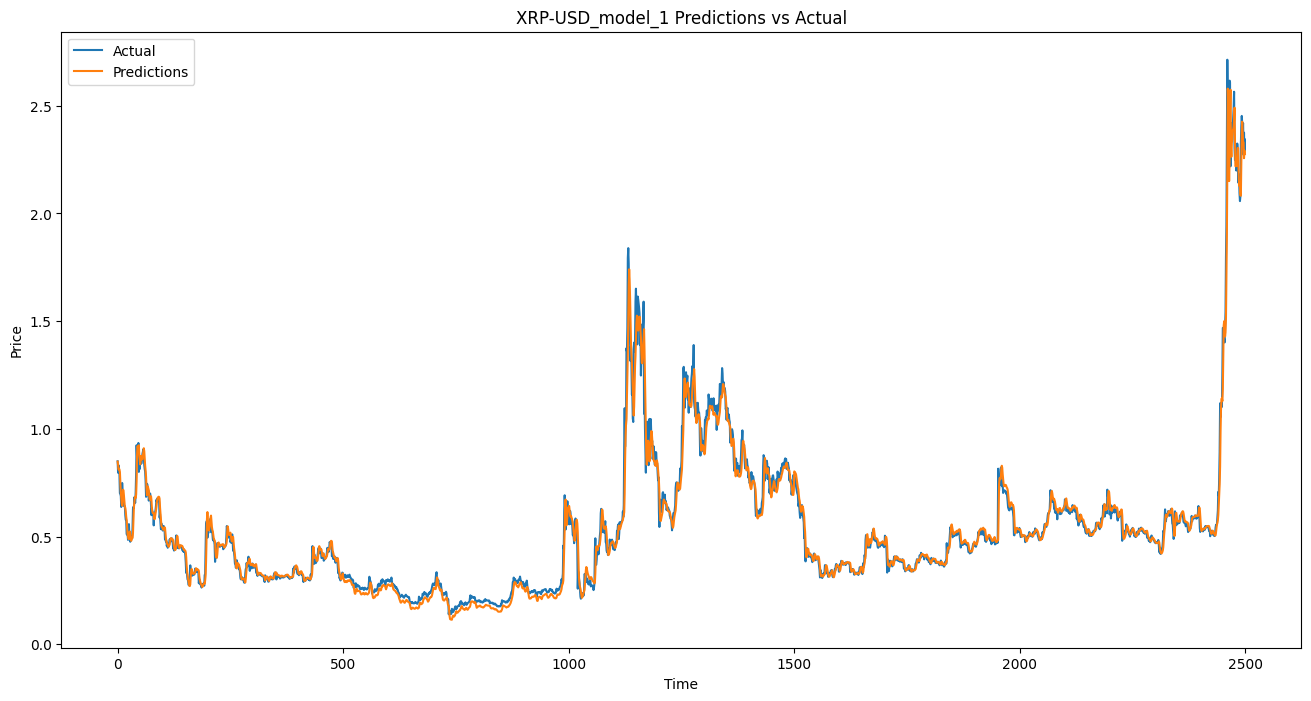

Training XRP-USD_model_2 with K-Fold Cross-Validation and Bayesian Optimization: ['GRU', 'GRU', 'GRU', 'GRU']
Fold 1
|   iter    |  target   | dropou... | lstm_u... |
-------------------------------------------------


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 1         | -0.01673  | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
| 2         | -0.01316  | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 3         | -0.01603  | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
| 4         | -0.01311  | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
| 5         | -0.01273  | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 6         | -0.01221  | 0.2631    | 65.34     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 7         | -0.01752  | 0.2904    | 64.95     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 8         | -0.01174  | 0.1878    | 73.07     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 9         | -0.01076  | 0.128     | 72.85     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 10        | -0.01406  | 0.2821    | 72.65     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0084
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0010
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 9.0096e-04
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 6.7649e-04
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 7.8467e-04
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 7.8553e-04
Epoch 7/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 7.2085e-04
Epoch 8/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 7.4064e-04
Epoch 9/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 5.6491e-04
Epoch 10/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 5.2671e-04
Epoch 11/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 4.7033e-04
Epoch 12/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 5.3639e-04
Epoch 13/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 6.6753e-04
Epoch 14/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4.4739e-04
Epoch 15/60
32/32 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 1         | -0.009978 | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 2         | -0.009015 | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 3         | -0.007343 | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 4         | -0.007032 | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
| 5         | -0.01537  | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 6         | -0.007295 | 0.1813    | 73.29     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 7         | -0.01329  | 0.1031    | 74.59     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 8         | -0.01036  | 0.1192    | 72.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 9         | -0.008009 | 0.131     | 37.02     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 10        | -0.03564  | 0.258     | 38.74     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0094
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 9.7760e-04
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 8.3411e-04
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 7.7141e-04
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 9.6916e-04
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 6.4373e-04
Epoch 7/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 6.1520e-04
Epoch 8/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 6.2537e-04
Epoch 9/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 7.5388e-04
Epoch 10/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 5.7022e-04
Epoch 11/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 6.5508e-04
Epoch 12/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 6.3633e-04
Epoch 13/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 5.0908e-04
Epoch 14/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 9.1453e-04
Epoch 15/60
32/32 ━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 1         | -0.03016  | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
| 2         | -0.03225  | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 3         | -0.03191  | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 4         | -0.02851  | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 5         | -0.03562  | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
| 6         | -0.03208  | 0.2964    | 49.55     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
| 7         | -0.04001  | 0.2979    | 71.07     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 8         | -0.03028  | 0.1203    | 56.08     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 9         | -0.03091  | 0.1011    | 53.19     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
| 10        | -0.04346  | 0.2335    | 62.11     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0051
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 7.6177e-04
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 5.2537e-04
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.4850e-04
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 5.8681e-04
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 4.4013e-04
Epoch 7/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 4.4267e-04
Epoch 8/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 3.7144e-04
Epoch 9/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 3.7108e-04
Epoch 10/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 3.4956e-04
Epoch 11/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 3.9894e-04
Epoch 12/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.9390e-04
Epoch 13/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 4.1700e-04
Epoch 14/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2.5238e-04
Epoch 15/60
32/32 ━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 1         | -0.01072  | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
| 2         | -0.01093  | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 3         | -0.0104   | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
| 4         | -0.009316 | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 5         | -0.009351 | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
| 6         | -0.009146 | 0.1674    | 73.27     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 7         | -0.01329  | 0.286     | 72.83     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
| 8         | -0.01188  | 0.2976    | 73.45     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 9         | -0.01568  | 0.1127    | 73.16     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
| 10        | -0.0126   | 0.171     | 73.26     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0104
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0012
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0012
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0011
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 7.8896e-04
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 9.5270e-04
Epoch 7/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 6.5248e-04
Epoch 8/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 6.8635e-04
Epoch 9/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 8.7671e-04
Epoch 10/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 5.9536e-04
Epoch 11/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 5.0449e-04
Epoch 12/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 7.7817e-04
Epoch 13/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 5.9300e-04
Epoch 14/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 5.8620e-04
Epoch 15/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
| 1         | -0.02377  | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 2         | -0.0264   | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 3         | -0.02828  | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 4         | -0.02316  | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
| 5         | -0.02764  | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
| 6         | -0.03017  | 0.2924    | 50.79     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 7         | -0.03719  | 0.2381    | 30.0      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
| 8         | -0.02185  | 0.1099    | 43.47     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
| 9         | -0.03282  | 0.2866    | 45.87     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
| 10        | -0.03007  | 0.2335    | 62.11     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0057
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 7.9233e-04
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 5.9877e-04
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 5.6458e-04
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 5.4242e-04
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 5.4049e-04
Epoch 7/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 4.8029e-04
Epoch 8/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 4.1841e-04
Epoch 9/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 3.9773e-04
Epoch 10/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 3.9261e-04
Epoch 11/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 3.1119e-04
Epoch 12/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 3.2132e-04
Epoch 13/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 4.2433e-04
Epoch 14/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.3681e-04
Epoch 15/60
32/32 ━━━━━━━━━━━━

Fold 5 Results:
  RMSE: 0.059755823869028384
  MAE: 0.03290277850627899
  R²: 0.9862002479603293
  LSTM Units: 43
  Dropout Rate: 0.10989007906390441
--------------------


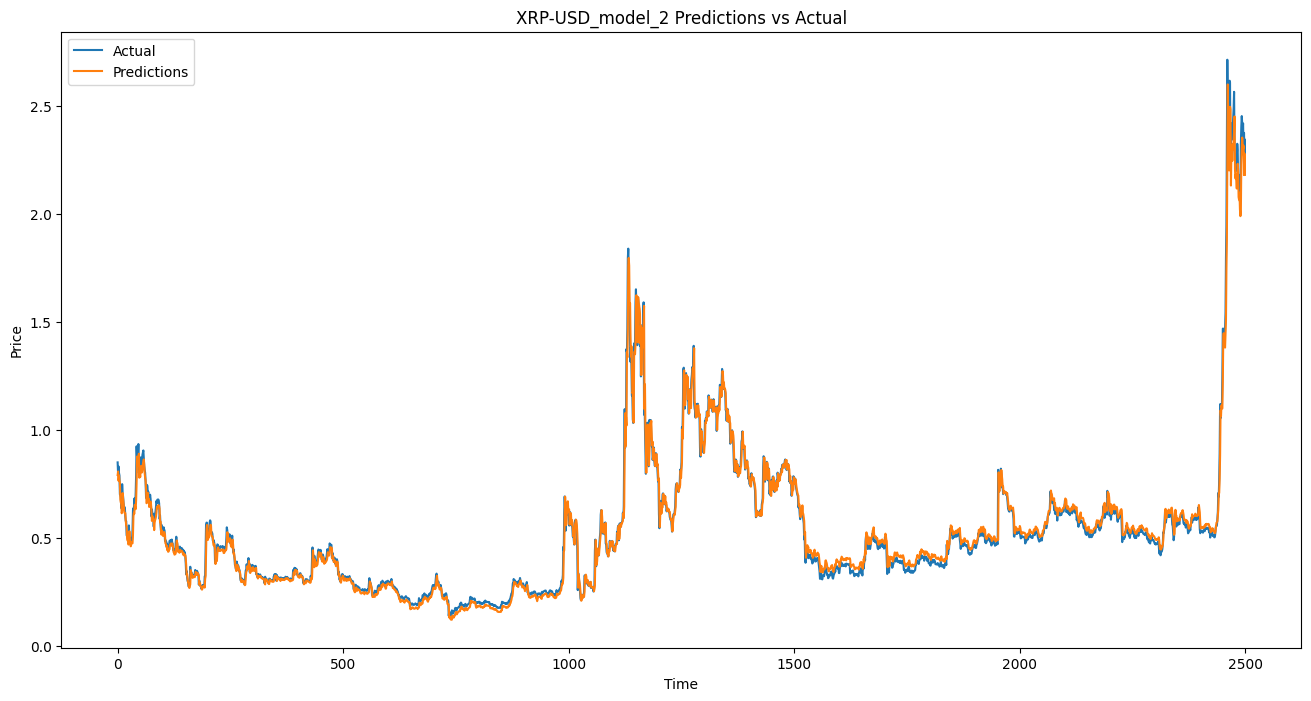

Training XRP-USD_model_3 with K-Fold Cross-Validation and Bayesian Optimization: ['LSTM', 'LSTM', 'GRU', 'GRU']
Fold 1
|   iter    |  target   | dropou... | lstm_u... |
-------------------------------------------------


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 1         | -0.0145   | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 2         | -0.0168   | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 3         | -0.01488  | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 4         | -0.01546  | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 5         | -0.01359  | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 6         | -0.01476  | 0.2662    | 65.44     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 7         | -0.01536  | 0.206     | 65.35     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 8         | -0.01771  | 0.1203    | 56.08     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 9         | -0.0158   | 0.1964    | 65.42     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 10        | -0.01559  | 0.2335    | 62.11     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0087
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0018
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0014
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0014
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0012
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0012
Epoch 7/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0013
Epoch 8/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0013
Epoch 9/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0014
Epoch 10/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0012
Epoch 11/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 8.8127e-04
Epoch 12/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 9.1445e-04
Epoch 13/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 7.2928e-04
Epoch 14/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 8.2420e-04
Epoch 15/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0010

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 1         | -0.01017  | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 2         | -0.009176 | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 3         | -0.009709 | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 4         | -0.009834 | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 5         | -0.00979  | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 6         | -0.01089  | 0.2386    | 57.79     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 7         | -0.009899 | 0.2692    | 59.86     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 8         | -0.009015 | 0.1203    | 56.08     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 9         | -0.02736  | 0.1011    | 53.19     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 10        | -0.008356 | 0.1143    | 61.1      |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0113
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0016
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0015
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0012
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 9.4898e-04
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0012
Epoch 7/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 9.5332e-04
Epoch 8/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 9.3139e-04
Epoch 9/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0011
Epoch 10/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0011
Epoch 11/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 7.1652e-04
Epoch 12/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 6.2417e-04
Epoch 13/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 7.4541e-04
Epoch 14/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 7.5083e-04
Epoch 15/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 1         | -0.03817  | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 2         | -0.05078  | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 3         | -0.04194  | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 4         | -0.0395   | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 5         | -0.04596  | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 6         | -0.04418  | 0.2531    | 30.0      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 7         | -0.03783  | 0.2972    | 80.0      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 8         | -0.0358   | 0.1089    | 79.95     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 9         | -0.03973  | 0.1072    | 79.34     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 10        | -0.03833  | 0.2492    | 76.73     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0058
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0011
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 7.3421e-04
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 7.0933e-04
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 6.0494e-04
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 6.3728e-04
Epoch 7/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 5.9884e-04
Epoch 8/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 5.8215e-04
Epoch 9/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 5.7522e-04
Epoch 10/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 6.0096e-04
Epoch 11/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 4.1536e-04
Epoch 12/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.3000e-04
Epoch 13/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.3314e-04
Epoch 14/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.9930e-04
Epoch 15/60
32/32 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 1         | -0.01108  | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 2         | -0.02004  | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 3         | -0.01266  | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 4         | -0.01127  | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 5         | -0.0122   | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 6         | -0.01167  | 0.2312    | 69.55     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
| 7         | -0.01609  | 0.2381    | 30.0      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 8         | -0.01233  | 0.2455    | 44.83     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 9         | -0.01496  | 0.1077    | 50.04     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 10        | -0.01139  | 0.2992    | 79.99     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0080
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0016
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0013
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0013
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0010
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0014
Epoch 7/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0012
Epoch 8/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 9.3848e-04
Epoch 9/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0012
Epoch 10/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 8.6944e-04
Epoch 11/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 8.6898e-04
Epoch 12/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 7.2508e-04
Epoch 13/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 6.6310e-04
Epoch 14/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 7.7902e-04
Epoch 15/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 1         | -0.0344   | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 2         | -0.02894  | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 3         | -0.03095  | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 4         | -0.03169  | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 5         | -0.03784  | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 6         | -0.02993  | 0.1886    | 59.96     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 7         | -0.03647  | 0.2975    | 59.64     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 8         | -0.03266  | 0.2872    | 60.1      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 9         | -0.03584  | 0.1788    | 59.84     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 10        | -0.03885  | 0.281     | 59.98     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0072
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0013
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0013
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0011
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 7.8558e-04
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 8.3059e-04
Epoch 7/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 9.3051e-04
Epoch 8/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 6.6398e-04
Epoch 9/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 7.3259e-04
Epoch 10/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 7.4611e-04
Epoch 11/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 7.4839e-04
Epoch 12/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 5.7316e-04
Epoch 13/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 7.8663e-04
Epoch 14/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 4.7434e-04
Epoch 15/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 

Fold 5 Results:
  RMSE: 0.07027105147069512
  MAE: 0.03558938997983933
  R²: 0.9809162503874018
  LSTM Units: 59
  Dropout Rate: 0.24639878836228102
--------------------


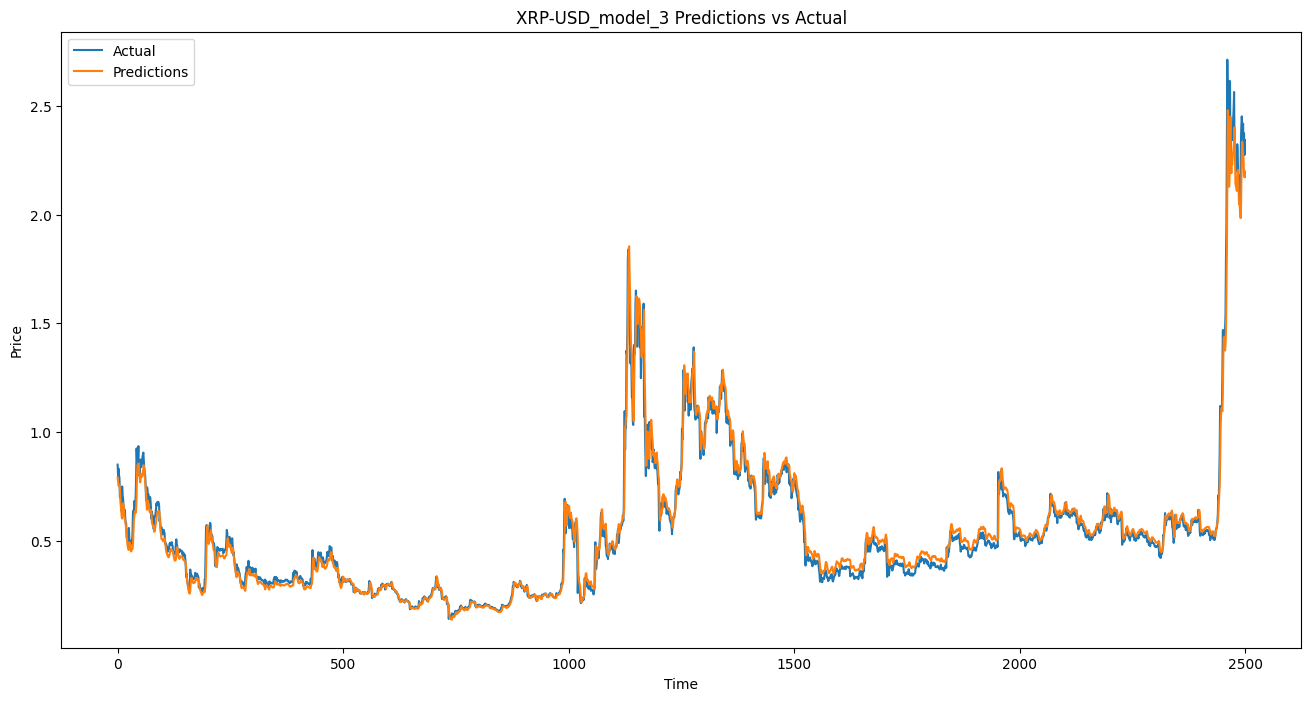

Training XRP-USD_model_4 with K-Fold Cross-Validation and Bayesian Optimization: ['GRU', 'GRU', 'LSTM', 'LSTM']
Fold 1
|   iter    |  target   | dropou... | lstm_u... |
-------------------------------------------------


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 1         | -0.01268  | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 2         | -0.01824  | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 3         | -0.02011  | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 4         | -0.01741  | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 5         | -0.01736  | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 6         | -0.02399  | 0.1394    | 77.57     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 7         | -0.01619  | 0.2657    | 45.01     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 8         | -0.01678  | 0.1203    | 56.08     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 9         | -0.01493  | 0.1011    | 53.19     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 10        | -0.01665  | 0.2335    | 62.11     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0071
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0013
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0012
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0010    
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0011
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 9.1608e-04
Epoch 7/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0010
Epoch 8/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 7.9775e-04
Epoch 9/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0011
Epoch 10/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 6.9026e-04
Epoch 11/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 6.8132e-04
Epoch 12/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 7.6561e-04
Epoch 13/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 6.2972e-04
Epoch 14/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 6.2734e-04
Epoch 15/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/ste

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 1         | -0.0082   | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 2         | -0.009631 | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 3         | -0.008795 | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 4         | -0.01095  | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 5         | -0.008949 | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 6         | -0.02241  | 0.1678    | 77.6      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 7         | -0.01383  | 0.2657    | 45.01     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 8         | -0.01702  | 0.1203    | 56.08     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 9         | -0.01309  | 0.1011    | 53.19     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 10        | -0.01122  | 0.2335    | 62.11     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0144
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0021
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0013
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0011
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0011
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0010
Epoch 7/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 9.0635e-04
Epoch 8/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0010
Epoch 9/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0011
Epoch 10/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 8.8680e-04
Epoch 11/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 9.2353e-04
Epoch 12/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 7.0307e-04
Epoch 13/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 6.9010e-04
Epoch 14/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 6.5338e-04
Epoch 15/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 1         | -0.0442   | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 2         | -0.04621  | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 3         | -0.04311  | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 4         | -0.03637  | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 5         | -0.03728  | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 6         | -0.0368   | 0.1597    | 73.35     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 7         | -0.03951  | 0.1343    | 72.43     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 8         | -0.03645  | 0.2125    | 66.32     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 9         | -0.03935  | 0.1643    | 67.36     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 10        | -0.03702  | 0.1552    | 64.17     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0071
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 9.2707e-04
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 9.0315e-04
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 5.9251e-04
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 7.1223e-04
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 7.9264e-04
Epoch 7/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 5.4582e-04
Epoch 8/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 4.0599e-04
Epoch 9/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 5.0160e-04
Epoch 10/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 4.0477e-04
Epoch 11/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 3.5676e-04
Epoch 12/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 5.3995e-04
Epoch 13/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.5592e-04
Epoch 14/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 4.5677e-04
Epoch 15/60
32/32 ━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 1         | -0.01172  | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 2         | -0.01451  | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 3         | -0.01793  | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 4         | -0.01336  | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 5         | -0.01117  | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 6         | -0.0175   | 0.1411    | 67.76     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 7         | -0.01554  | 0.2308    | 65.32     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 8         | -0.01282  | 0.1203    | 56.08     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 9         | -0.01306  | 0.1011    | 53.19     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 10        | -0.01433  | 0.2335    | 62.11     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0091
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0018
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0014
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0014
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0012
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0012
Epoch 7/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 9.0569e-04
Epoch 8/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0011
Epoch 9/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0011
Epoch 10/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0010
Epoch 11/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 9.7483e-04
Epoch 12/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 6.8572e-04
Epoch 13/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 8.5462e-04
Epoch 14/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 8.2957e-04
Epoch 15/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 6.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 1         | -0.03226  | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 2         | -0.04015  | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 3         | -0.03848  | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 4         | -0.03604  | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 5         | -0.04013  | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 6         | -0.04785  | 0.2405    | 80.0      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 7         | -0.04745  | 0.2315    | 77.58     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 8         | -0.0357   | 0.1203    | 56.08     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 9         | -0.03079  | 0.1011    | 53.19     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 10        | -0.03376  | 0.2335    | 62.11     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0065
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0010
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 7.5125e-04
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 7.6811e-04
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 7.4814e-04
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 7.4917e-04
Epoch 7/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 6.6925e-04
Epoch 8/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 5.3068e-04
Epoch 9/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 4.7705e-04
Epoch 10/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 5.2785e-04
Epoch 11/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 5.4035e-04
Epoch 12/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.0228e-04
Epoch 13/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.9319e-04
Epoch 14/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 4.4880e-04
Epoch 15/60
32/32 ━━━━━━━━━━━━━━━━

Fold 5 Results:
  RMSE: 0.059111508613904955
  MAE: 0.03029041701555252
  R²: 0.9864962343467801
  LSTM Units: 53
  Dropout Rate: 0.1011287073837295
--------------------


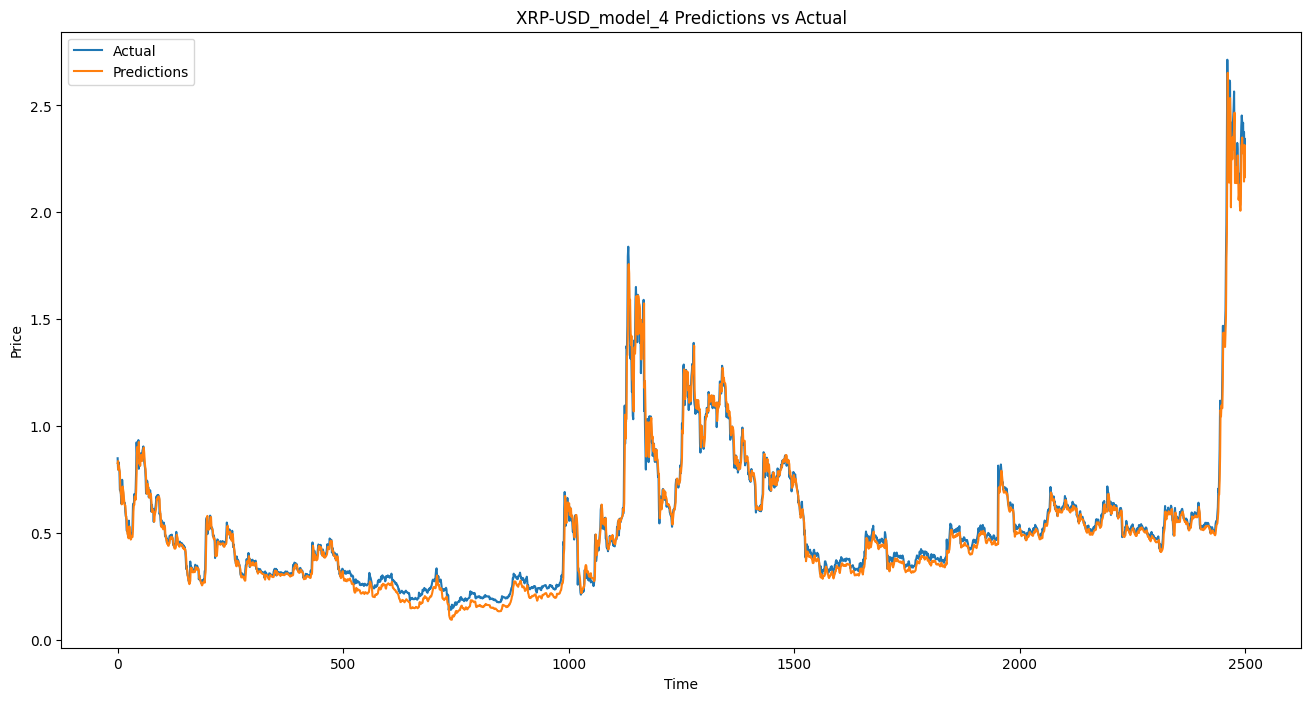

Training XRP-USD_model_5 with K-Fold Cross-Validation and Bayesian Optimization: ['LSTM', 'GRU', 'LSTM', 'GRU']
Fold 1
|   iter    |  target   | dropou... | lstm_u... |
-------------------------------------------------


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 1         | -0.02355  | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 2         | -0.01399  | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 3         | -0.02185  | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 4         | -0.02187  | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 5         | -0.02496  | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 6         | -0.02045  | 0.2611    | 59.27     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 7         | -0.01606  | 0.1874    | 59.94     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 8         | -0.01769  | 0.2978    | 59.83     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 9         | -0.01529  | 0.2905    | 60.02     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 10        | -0.0143   | 0.2325    | 60.25     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0103
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0020
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0015
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0013
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0012
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0010
Epoch 7/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0011
Epoch 8/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0011
Epoch 9/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0010
Epoch 10/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0011
Epoch 11/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 9.4313e-04
Epoch 12/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 7.9247e-04
Epoch 13/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 9.9389e-04
Epoch 14/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 9.2933e-04
Epoch 15/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 9.0304

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 1         | -0.00862  | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 2         | -0.01294  | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 3         | -0.01265  | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 4         | -0.01385  | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 5         | -0.01739  | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 6         | -0.01146  | 0.2304    | 77.53     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 7         | -0.008354 | 0.1439    | 77.5      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 8         | -0.01176  | 0.1203    | 56.08     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 9         | -0.01066  | 0.1144    | 77.67     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 10        | -0.00815  | 0.1037    | 77.56     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0101
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0021
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0016
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0012
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 8.1548e-04
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 8.2102e-04
Epoch 7/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0011
Epoch 8/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 8.8713e-04
Epoch 9/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 7.0249e-04
Epoch 10/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0010
Epoch 11/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 8.1394e-04
Epoch 12/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 7.8601e-04
Epoch 13/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 6.1270e-04
Epoch 14/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 5.6646e-04
Epoch 15/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/ste

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 1         | -0.04557  | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 2         | -0.04403  | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 3         | -0.05736  | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 4         | -0.04477  | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 5         | -0.05042  | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 6         | -0.03903  | 0.1963    | 55.07     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 7         | -0.04366  | 0.2947    | 49.97     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 8         | -0.04118  | 0.1012    | 53.24     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 9         | -0.04089  | 0.1718    | 30.01     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
| 10        | -0.03929  | 0.1097    | 57.07     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0061
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0018
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0010
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 8.7108e-04
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 7.5918e-04
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 8.9392e-04
Epoch 7/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 5.7045e-04
Epoch 8/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0019
Epoch 9/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 7.4765e-04
Epoch 10/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 5.7696e-04
Epoch 11/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 6.3187e-04
Epoch 12/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 6.2471e-04
Epoch 13/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 7.0665e-04
Epoch 14/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 5.3064e-04
Epoch 15/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 1         | -0.01197  | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 2         | -0.01261  | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
| 3         | -0.01283  | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
| 4         | -0.01425  | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
| 5         | -0.01378  | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
| 6         | -0.02044  | 0.2266    | 77.57     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
| 7         | -0.01445  | 0.2657    | 45.01     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
| 8         | -0.01156  | 0.1203    | 56.08     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
| 9         | -0.01256  | 0.1011    | 53.19     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
| 10        | -0.01242  | 0.2335    | 62.11     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0104
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0022
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0014
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0013
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0011
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 8.8845e-04
Epoch 7/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0011
Epoch 8/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0010
Epoch 9/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0010
Epoch 10/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 8.1249e-04
Epoch 11/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 9.1492e-04
Epoch 12/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 6.9944e-04
Epoch 13/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 9.3527e-04
Epoch 14/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 8.2237e-04
Epoch 15/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
| 1         | -0.03132  | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 2         | -0.03428  | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
| 3         | -0.03941  | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
| 4         | -0.02827  | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 5         | -0.03497  | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
| 6         | -0.04078  | 0.1042    | 50.95     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
| 7         | -0.03633  | 0.2925    | 70.62     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 8         | -0.03302  | 0.1203    | 56.08     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 9         | -0.02765  | 0.1011    | 53.19     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
| 10        | -0.02917  | 0.2335    | 62.11     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0057
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0010
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 7.4089e-04
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 8.5403e-04
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 6.6080e-04
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 7.8108e-04
Epoch 7/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 5.1426e-04
Epoch 8/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 6.3847e-04
Epoch 9/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 6.1779e-04
Epoch 10/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 4.8668e-04
Epoch 11/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 4.6897e-04
Epoch 12/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 4.4899e-04
Epoch 13/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 4.4976e-04
Epoch 14/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.2374e-04
Epoch 15/60
32/32 ━━━━━━━━━━━━━━━━

Fold 5 Results:
  RMSE: 0.07811621715842626
  MAE: 0.04587239372730255
  R²: 0.9764173169589153
  LSTM Units: 53
  Dropout Rate: 0.1011287073837295
--------------------


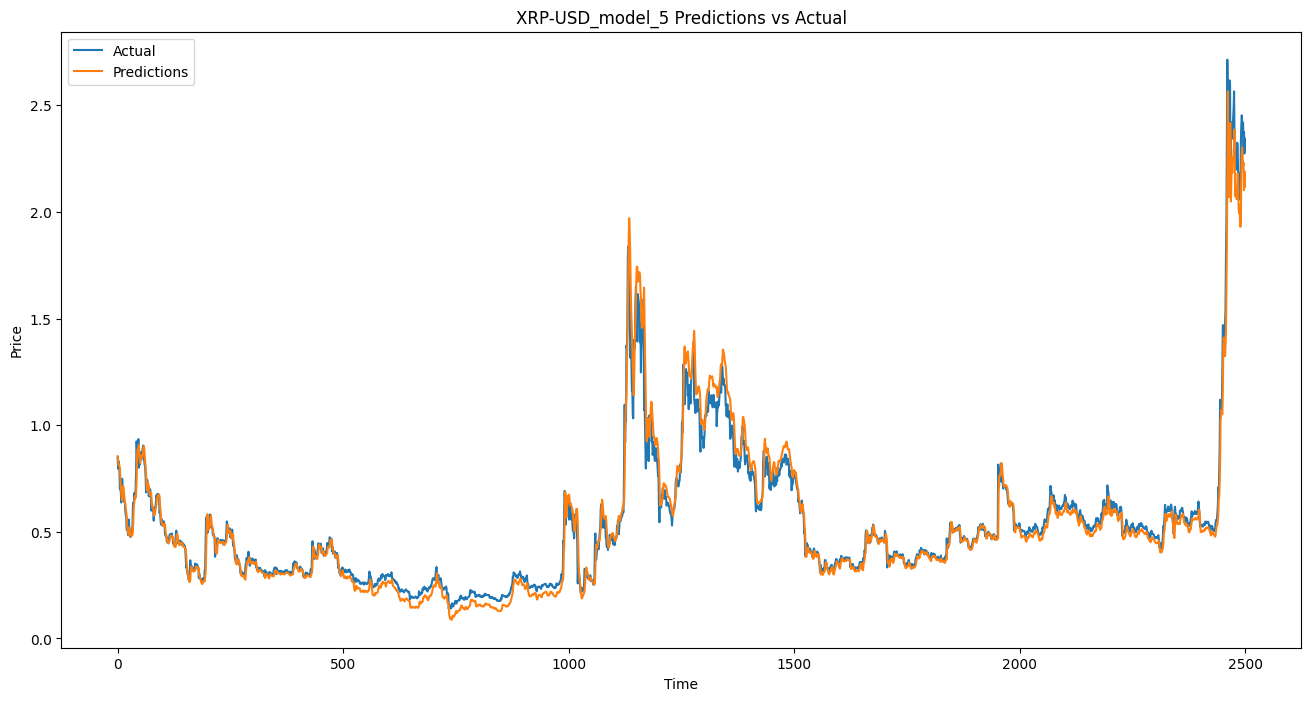

Training XRP-USD_model_6 with K-Fold Cross-Validation and Bayesian Optimization: ['GRU', 'LSTM', 'GRU', 'LSTM']
Fold 1
|   iter    |  target   | dropou... | lstm_u... |
-------------------------------------------------


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 1         | -0.01326  | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 2         | -0.0173   | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 3         | -0.01796  | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
| 4         | -0.01726  | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 5         | -0.01432  | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 6         | -0.01567  | 0.2321    | 77.53     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
| 7         | -0.01512  | 0.1746    | 77.57     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 8         | -0.01412  | 0.1203    | 56.08     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 9         | -0.02109  | 0.1914    | 77.52     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
| 10        | -0.01367  | 0.2335    | 62.11     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0091
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0015
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0011
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0012
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0013
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0010
Epoch 7/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 6.9845e-04
Epoch 8/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 7.2968e-04
Epoch 9/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 8.7622e-04
Epoch 10/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 8.3670e-04
Epoch 11/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 8.0204e-04
Epoch 12/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 7.3114e-04
Epoch 13/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 6.6817e-04
Epoch 14/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 6.2482e-04
Epoch 15/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/ste

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 1         | -0.01473  | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
| 2         | -0.009405 | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
| 3         | -0.01133  | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 4         | -0.008904 | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
| 5         | -0.01202  | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 6         | -0.00843  | 0.1674    | 73.27     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 7         | -0.008393 | 0.2947    | 72.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
| 8         | -0.0107   | 0.2072    | 58.97     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 9         | -0.01637  | 0.2919    | 60.81     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
| 10        | -0.01371  | 0.102     | 71.99     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0124
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0021
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0014
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0015
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0014
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0012
Epoch 7/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0012
Epoch 8/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 9.7067e-04
Epoch 9/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 9.9601e-04
Epoch 10/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 9.8020e-04
Epoch 11/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0010
Epoch 12/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 7.9744e-04
Epoch 13/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 8.7349e-04
Epoch 14/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 8.8991e-04
Epoch 15/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 1         | -0.04274  | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
| 2         | -0.04262  | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 3         | -0.0417   | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 4         | -0.04306  | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
| 5         | -0.03893  | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 6         | -0.03689  | 0.1029    | 66.89     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 7         | -0.05629  | 0.2998    | 68.7      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
| 8         | -0.03824  | 0.1715    | 66.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 9         | -0.03929  | 0.1074    | 64.03     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 10        | -0.0508   | 0.2866    | 62.55     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0092
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 8.7445e-04
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0010
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 6.9459e-04
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 8.0575e-04
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.7761e-04
Epoch 7/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 4.4401e-04
Epoch 8/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 5.2689e-04
Epoch 9/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.1782e-04
Epoch 10/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 5.4038e-04
Epoch 11/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.7217e-04
Epoch 12/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.1326e-04
Epoch 13/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.9228e-04
Epoch 14/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 9.6923e-04
Epoch 15/60
32/32 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 1         | -0.01657  | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 2         | -0.01636  | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
| 3         | -0.01518  | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 4         | -0.01264  | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 5         | -0.01422  | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 6         | -0.01072  | 0.1517    | 73.35     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 7         | -0.0106   | 0.2185    | 73.36     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
| 8         | -0.0122   | 0.1203    | 56.08     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 9         | -0.01337  | 0.1812    | 73.48     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 10        | -0.01167  | 0.2812    | 73.27     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0097
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0016
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0013
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0011
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 9.5708e-04
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0012
Epoch 7/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 8.6327e-04
Epoch 8/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 9.3474e-04
Epoch 9/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0011
Epoch 10/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0010
Epoch 11/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0010
Epoch 12/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 6.9686e-04
Epoch 13/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 7.6906e-04
Epoch 14/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 9.9266e-04
Epoch 15/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 1         | -0.02853  | 0.1749    | 77.54     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 2         | -0.03739  | 0.2464    | 59.93     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
| 3         | -0.04651  | 0.1312    | 37.8      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 4         | -0.03406  | 0.1116    | 73.31     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 5         | -0.03171  | 0.2202    | 65.4      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
| 6         | -0.0355   | 0.2405    | 80.0      |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 7         | -0.0432   | 0.1124    | 76.14     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 8         | -0.03904  | 0.1203    | 56.08     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
| 9         | -0.04347  | 0.1011    | 53.19     |


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
| 10        | -0.03479  | 0.2335    | 62.11     |
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0044
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0012
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 7.9945e-04
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 7.2109e-04
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 7.6913e-04
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 6.7387e-04
Epoch 7/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 7.7599e-04
Epoch 8/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.7498e-04
Epoch 9/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 5.0291e-04
Epoch 10/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 5.1640e-04
Epoch 11/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 4.5477e-04
Epoch 12/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.3482e-04
Epoch 13/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.2149e-04
Epoch 14/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.3396e-04
Epoch 15/60
32/32 ━━━━━━━━━━━━━━━━

Fold 5 Results:
  RMSE: 0.051412726085863704
  MAE: 0.027071960508823396
  R²: 0.9897846777697247
  LSTM Units: 77
  Dropout Rate: 0.1749080237694725
--------------------


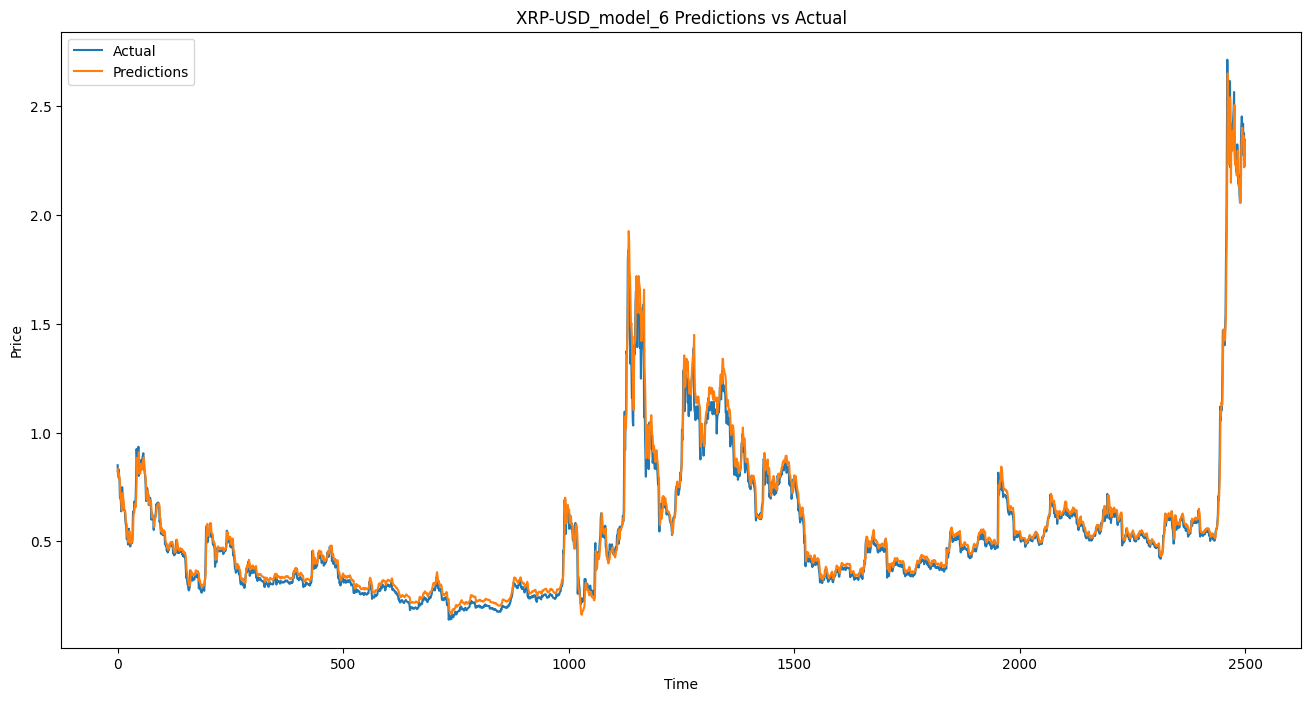

All evaluation results have been saved and the models are stored in the 'models' directory.


In [ ]:


# Create directories to save models, plots, and evaluation results
os.makedirs('models', exist_ok=True)
os.makedirs('plots', exist_ok=True)

# List of cryptocurrencies and model structures
cryptos = ['XRP-USD']
model_structures = [
    ['LSTM', 'LSTM', 'LSTM', 'LSTM'],
    ['GRU', 'GRU', 'GRU', 'GRU'],
    ['LSTM', 'LSTM', 'GRU', 'GRU'],
    ['GRU', 'GRU', 'LSTM', 'LSTM'],
    ['LSTM', 'GRU', 'LSTM', 'GRU'],
    ['GRU', 'LSTM', 'GRU', 'LSTM']
]

# Function to prepare the dataset
def prepare_data(crypto, time_step=120):
    data = yf.download(crypto, start='2014-01-01')
    data = data[['Close']]

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    X, y = [], []
    for i in range(len(scaled_data) - time_step - 1):
        X.append(scaled_data[i:(i + time_step), 0])
        y.append(scaled_data[i + time_step, 0])

    X = np.array(X).reshape(-1, time_step, 1)
    y = np.array(y)
    return data, X, y, scaler

# Function to build the model
def build_model(structure, time_step, lstm_units, dropout_rate):
    model = Sequential()
    for i, layer_type in enumerate(structure):
        if i == 0:
            if layer_type == 'LSTM':
                model.add(LSTM(lstm_units, return_sequences=True, input_shape=(time_step, 1)))
            elif layer_type == 'GRU':
                model.add(GRU(lstm_units, return_sequences=True, input_shape=(time_step, 1)))
        elif i == len(structure) - 1:
            if layer_type == 'LSTM':
                model.add(LSTM(lstm_units))
            elif layer_type == 'GRU':
                model.add(GRU(lstm_units))
        else:
            if layer_type == 'LSTM':
                model.add(LSTM(lstm_units, return_sequences=True))
            elif layer_type == 'GRU':
                model.add(GRU(lstm_units, return_sequences=True))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Dictionary to store evaluation results
evaluation_results = {}

# Bayesian Optimization function
def bayesian_optimization(structure, X_train, y_train, X_val, y_val):
    def model_evaluate(lstm_units, dropout_rate):
        model = build_model(structure, X_train.shape[1], int(lstm_units), dropout_rate)
        model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=0)
        val_predict = model.predict(X_val)
        val_rmse = np.sqrt(mean_squared_error(y_val, val_predict))
        return -val_rmse

    pbounds = {'lstm_units': (30, 80), 'dropout_rate': (0.1, 0.3)}
    optimizer = BayesianOptimization(f=model_evaluate, pbounds=pbounds, random_state=42)
    optimizer.maximize(init_points=5, n_iter=5)
    best_params = optimizer.max['params']
    return int(best_params['lstm_units']), best_params['dropout_rate']

# Train and evaluate the models for each cryptocurrency using K-Fold Cross-Validation
kf = KFold(n_splits=5)

for crypto in cryptos:
    data, X, y, scaler = prepare_data(crypto=crypto)

    for idx, structure in enumerate(model_structures):
        model_name = f'{crypto}_model_{idx + 1}'
        print(f"Training {model_name} with K-Fold Cross-Validation and Bayesian Optimization: {structure}")

        best_r2_score = -1  # Initialize with a very low value
        best_model = None

        fold_results = []  # List to store fold results
        all_predictions = []  # List to store predictions for plotting
        all_actual_values = []  # List to store actual values for plotting

        for fold, (train_index, val_index) in enumerate(kf.split(X)):
            print(f"Fold {fold + 1}")
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]

            # Bayesian Optimization for hyperparameters
            lstm_units, dropout_rate = bayesian_optimization(structure, X_train, y_train, X_val, y_val)

            # Build and train the model with optimized hyperparameters
            model = build_model(structure, X_train.shape[1], lstm_units, dropout_rate)
            model.fit(X_train, y_train, epochs=60, batch_size=64, verbose=1)

            # Predicting
            val_predict = model.predict(X_val)

            # Inverse transform to get actual values
            val_predict = scaler.inverse_transform(val_predict)
            y_val_actual = scaler.inverse_transform(y_val.reshape(-1, 1))

            # Append predictions and actual values to lists for plotting
            all_predictions.append(val_predict)
            all_actual_values.append(y_val_actual)

            # Evaluate the model on the validation set
            rmse = np.sqrt(mean_squared_error(y_val_actual, val_predict))
            mae = mean_absolute_error(y_val_actual, val_predict)
            r2 = r2_score(y_val_actual, val_predict)

            # Store fold results along with hyperparameters
            fold_results.append({
                'fold': fold + 1,
                'RMSE': rmse,
                'MAE': mae,
                'R²': r2,
                'LSTM Units': lstm_units,
                'Dropout Rate': dropout_rate
            })

            # Print fold results
            print(f"Fold {fold + 1} Results:")
            print(f"  RMSE: {rmse}")
            print(f"  MAE: {mae}")
            print(f"  R²: {r2}")
            print(f"  LSTM Units: {lstm_units}")
            print(f"  Dropout Rate: {dropout_rate}")
            print("-" * 20)  # Separator between folds

            # Check if current fold has the best R2 score
            if r2 > best_r2_score:
                best_r2_score = r2
                best_model = model

        # Save the best model
        if best_model is not None:
            model_filename = f'{model_name}_best.h5'
            model_path = os.path.join('models', model_filename)
            best_model.save(model_path)

        # Concatenate predictions and actual values from all folds for plotting
        all_predictions = np.concatenate(all_predictions)
        all_actual_values = np.concatenate(all_actual_values)

        # Create and save plot
        plt.figure(figsize=(16, 8))
        plt.plot(all_actual_values, label='Actual')
        plt.plot(all_predictions, label='Predictions')
        plt.legend()
        plt.title(f'{model_name} Predictions vs Actual')
        plt.xlabel('Time')
        plt.ylabel('Price')
        plot_filename = f'{model_name}_plot.png'
        plot_path = os.path.join('plots', plot_filename)
        plt.savefig(plot_path)  # Save the plot to a file
        plt.show()

        # Store all fold results and best R2 score in evaluation_results
        evaluation_results[model_name] = {
            'structure': structure,
            'fold_results': fold_results,
            'best_r2_score': best_r2_score  # Add best R2 score
        }

# Save evaluation results to JSON file
with open('evaluation_results_kfold.json', 'w') as f:
    json.dump(evaluation_results, f, indent=4)

print("All evaluation results have been saved and the models are stored in the 'models' directory.")

[*********************100%***********************]  1 of 1 completed


115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


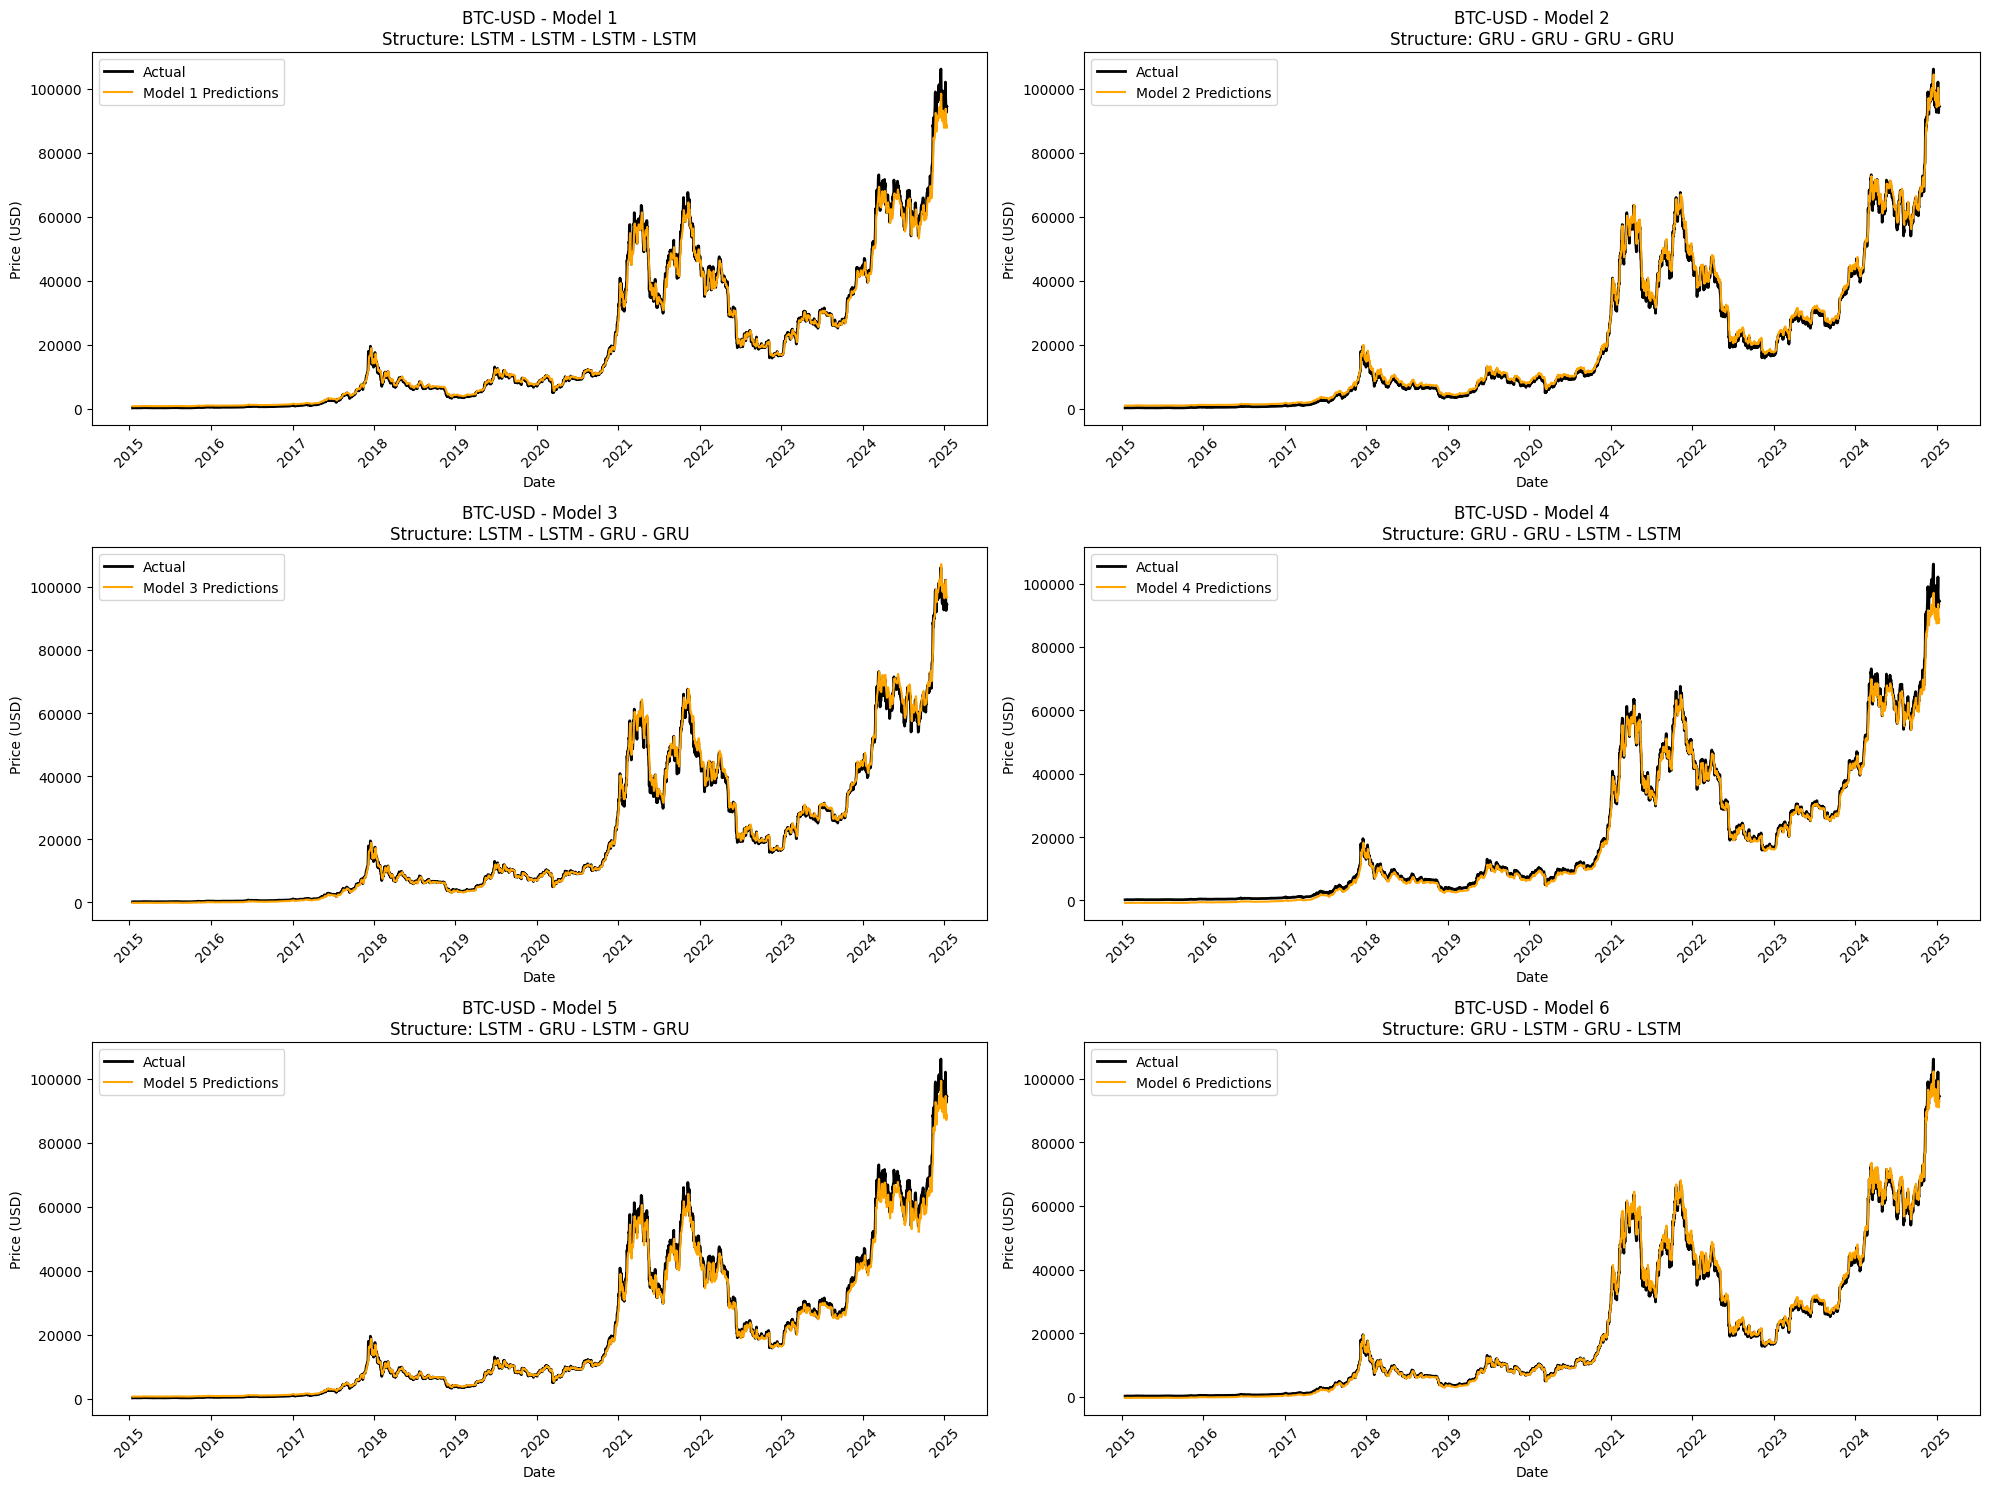

[*********************100%***********************]  1 of 1 completed


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


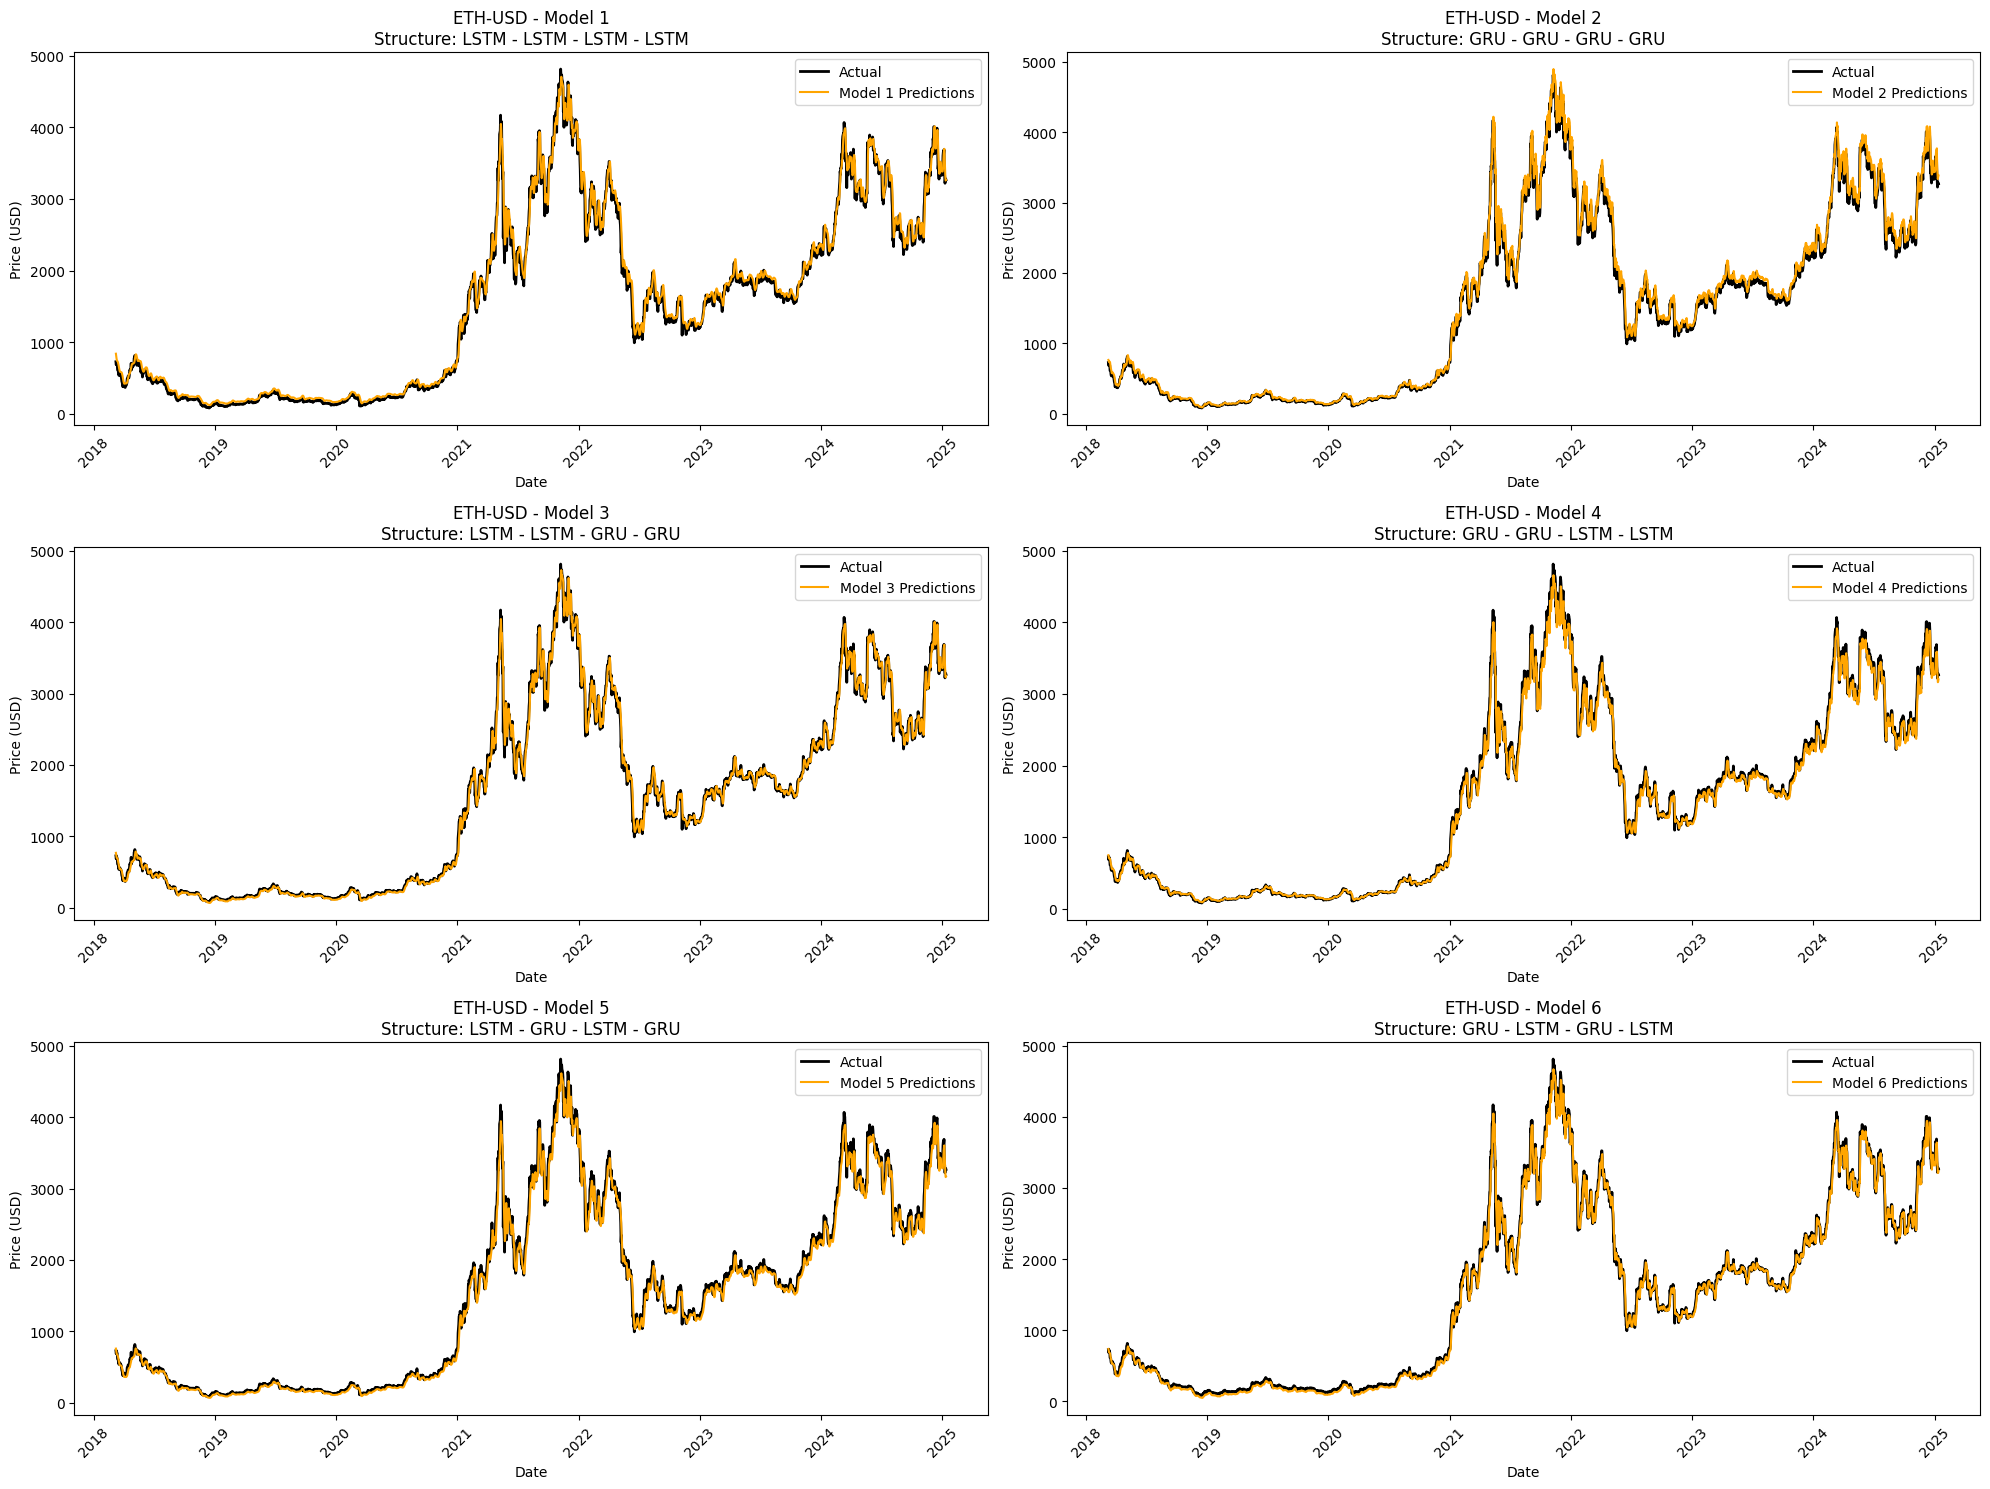

[*********************100%***********************]  1 of 1 completed


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


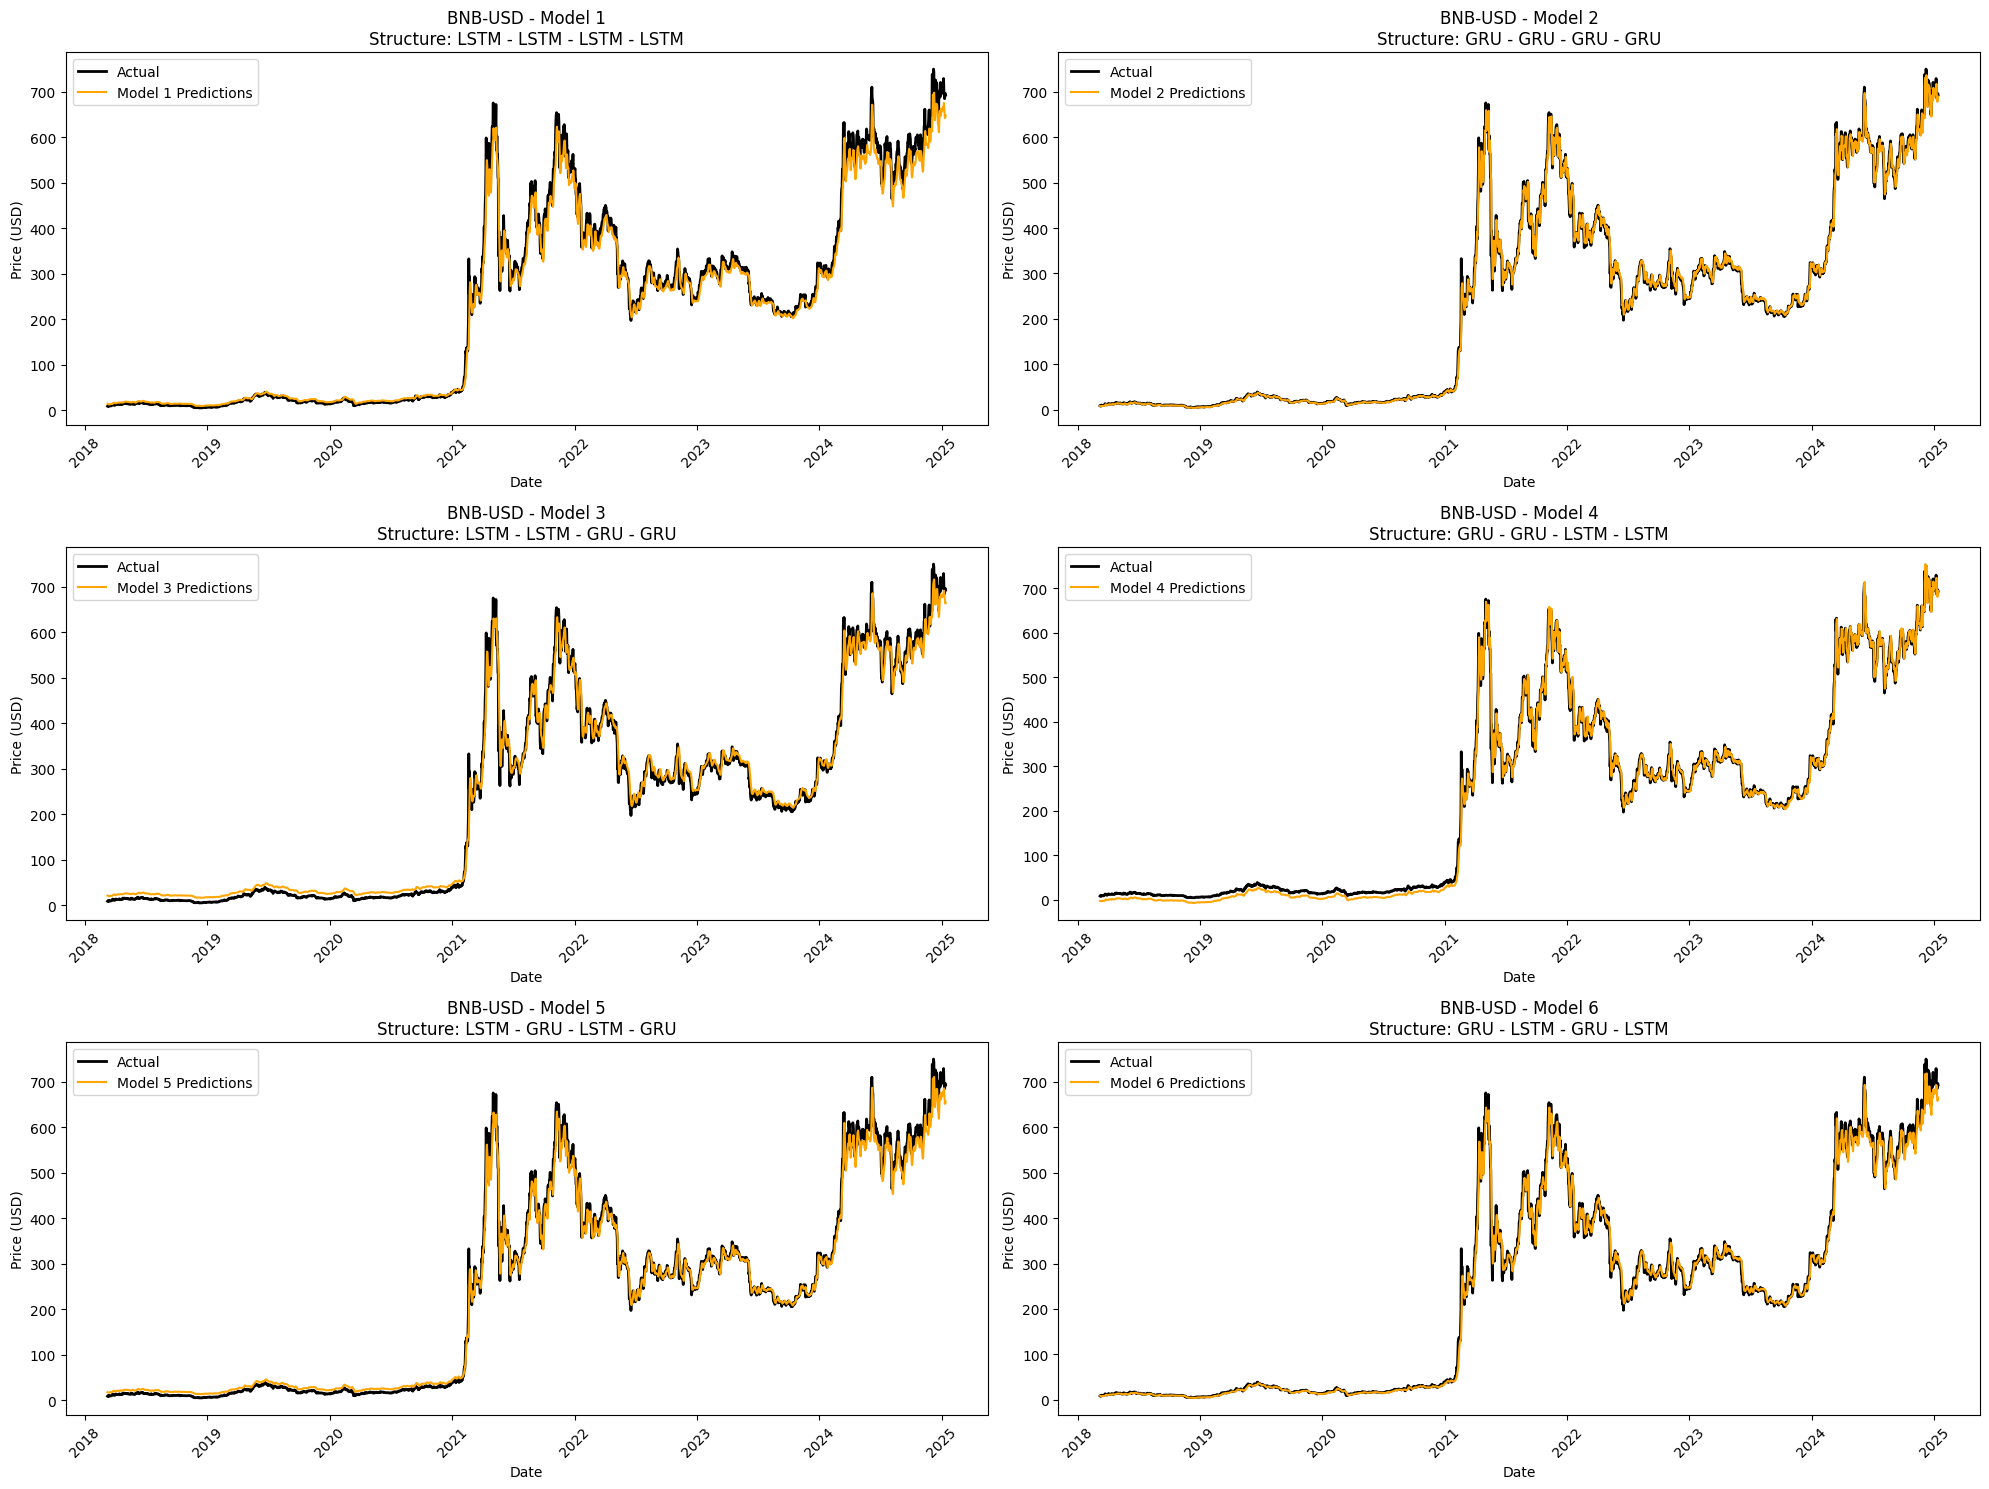

[*********************100%***********************]  1 of 1 completed


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


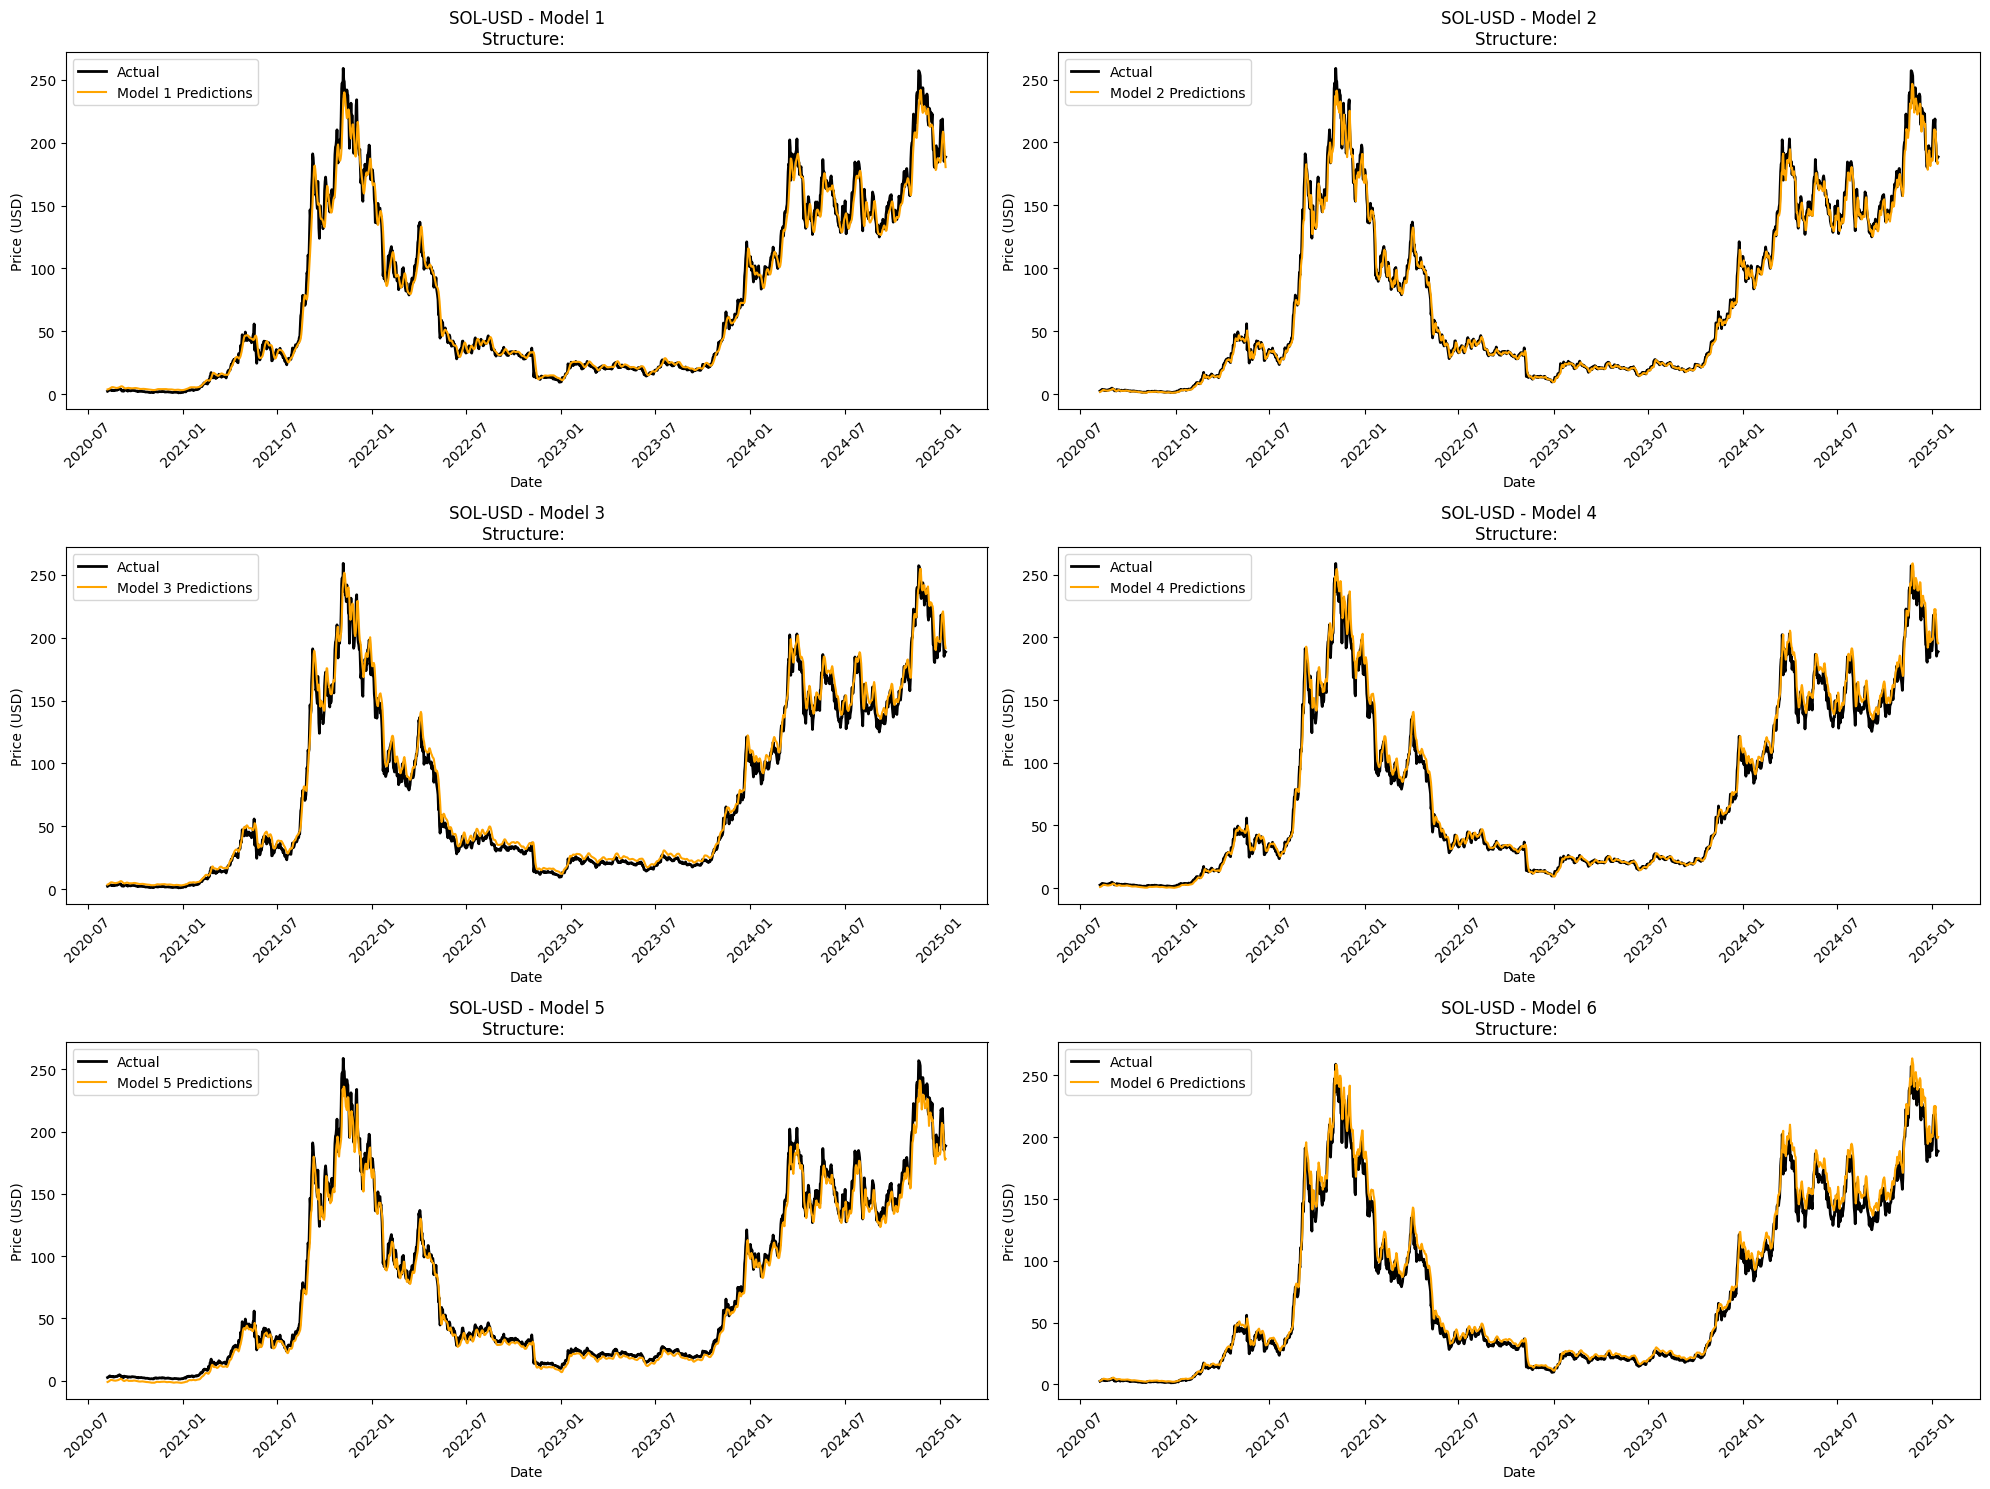

[*********************100%***********************]  1 of 1 completed


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


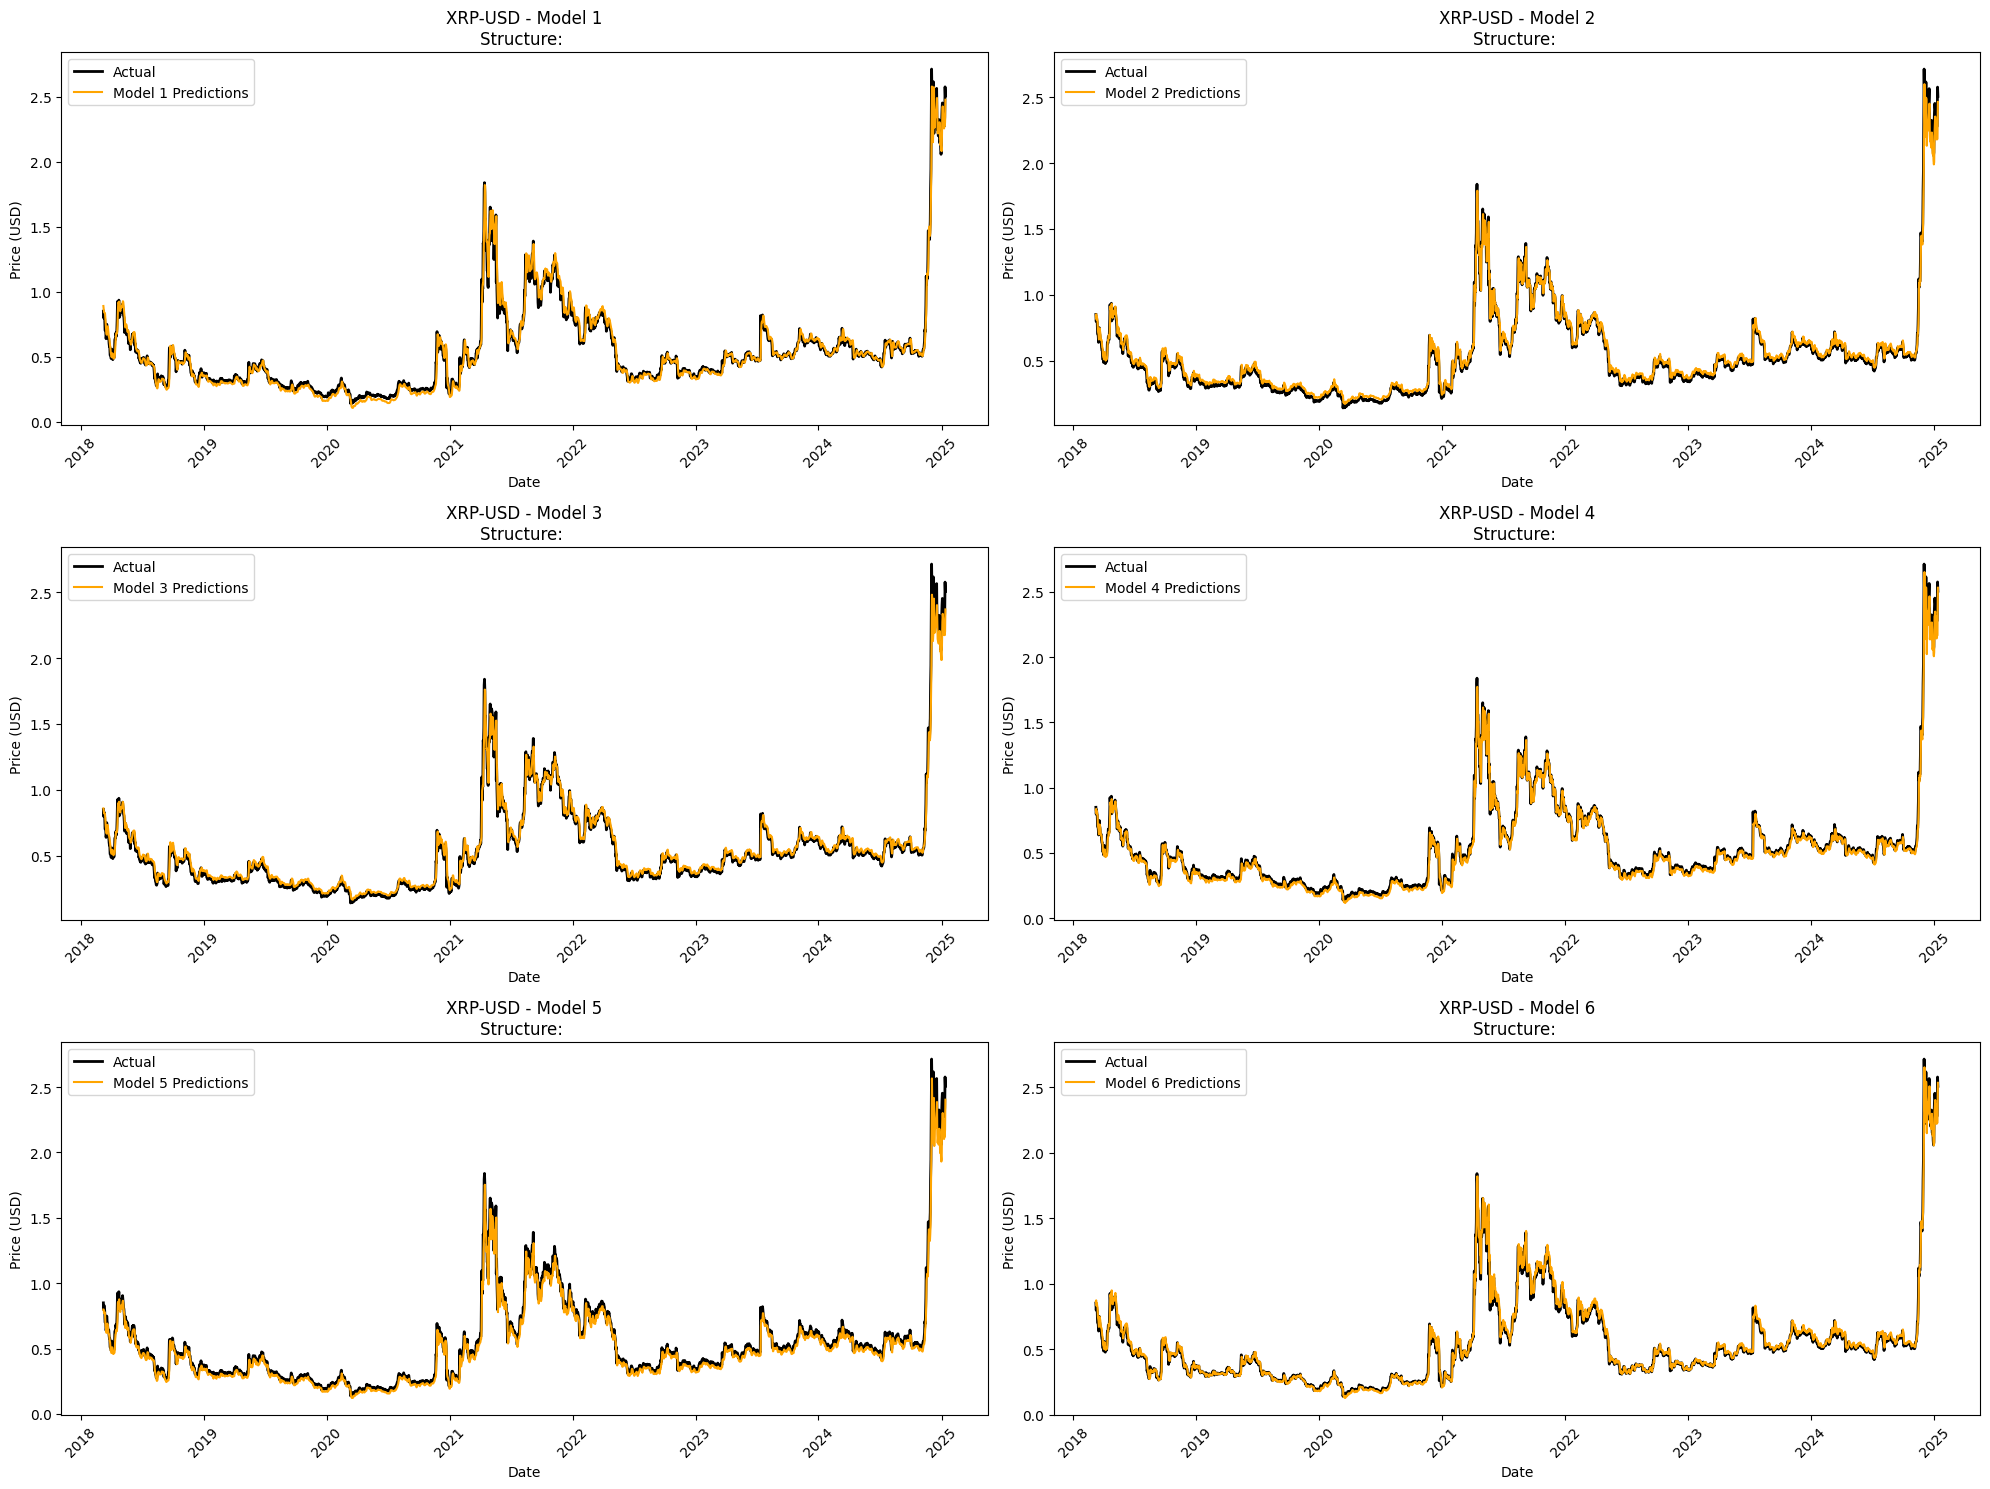

In [ ]:
# Import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import json
import yfinance as yf  # Import yfinance

# Load evaluation results from JSON file
with open('modeling_results.json', 'r') as f:
    evaluation_results = json.load(f)

# Prepare directories
models_dir = 'models'
plots_dir = 'plots'
os.makedirs(plots_dir, exist_ok=True)

# Function to prepare data for the plot
def prepare_data_for_plot(data, time_step=120):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data[['Close']])
    X, y, dates = [], [], []
    for i in range(len(scaled_data) - time_step - 1):
        X.append(scaled_data[i:(i + time_step), 0])
        y.append(scaled_data[i + time_step, 0])
        dates.append(data.index[i + time_step])  # Save corresponding dates
    X = np.array(X).reshape(-1, time_step, 1)
    y = np.array(y)
    return scaler, X, y, dates

# List of cryptocurrencies
cryptos = ['BTC-USD', 'ETH-USD', 'BNB-USD', 'SOL-USD', 'XRP-USD']

# Iterate through each cryptocurrency
for crypto in cryptos:
    # Load the dataset for the cryptocurrency
    crypto_data = yf.download(crypto, start='2014-01-01')
    crypto_data = crypto_data[['Close']]

    # Prepare data for the model
    scaler, X, y, dates = prepare_data_for_plot(crypto_data)

    # Initialize lists to store predictions and labels
    crypto_predictions = []
    model_structures = []  # To store model structures for titles

    # Iterate through 6 models for this cryptocurrency
    for i in range(6):
        model_name = f'{crypto}_model_{i + 1}'
        model_path = os.path.join(models_dir, f"{model_name}_best.h5")

        if os.path.exists(model_path):
            # Load the model
            model = load_model(model_path)

            # Get the model structure from evaluation results
            structure = evaluation_results.get(model_name, {}).get('structure', [])
            model_structures.append(structure)

            # Make predictions
            predictions = model.predict(X)

            # Inverse transform the predictions
            predictions = scaler.inverse_transform(predictions)
            crypto_predictions.append(predictions)

    # Inverse transform the actual values
    actual_values = scaler.inverse_transform(y.reshape(-1, 1))

    # Create subplots for the cryptocurrency
    fig, axes = plt.subplots(3, 2, figsize=(20, 15))
    axes = axes.flatten()

    for i, predictions in enumerate(crypto_predictions):
        axes[i].plot(dates, actual_values, label='Actual', color='black', linewidth=2)
        axes[i].plot(dates, predictions, label=f'Model {i + 1} Predictions', color='orange')
        structure_str = ' - '.join(model_structures[i]) if i < len(model_structures) else 'Unknown Structure'
        axes[i].set_title(f'{crypto} - Model {i + 1}\nStructure: {structure_str}')
        axes[i].set_xlabel('Date')
        axes[i].set_ylabel('Price (USD)')
        axes[i].legend()
        axes[i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability

    # Remove unused subplots if less than 6 models
    for j in range(len(crypto_predictions), len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout
    plt.tight_layout()

    # Save the combined plot for this cryptocurrency
    plot_path = os.path.join(plots_dir, f'{crypto}_models_subplot.png')
    plt.savefig(plot_path)
    plt.show()


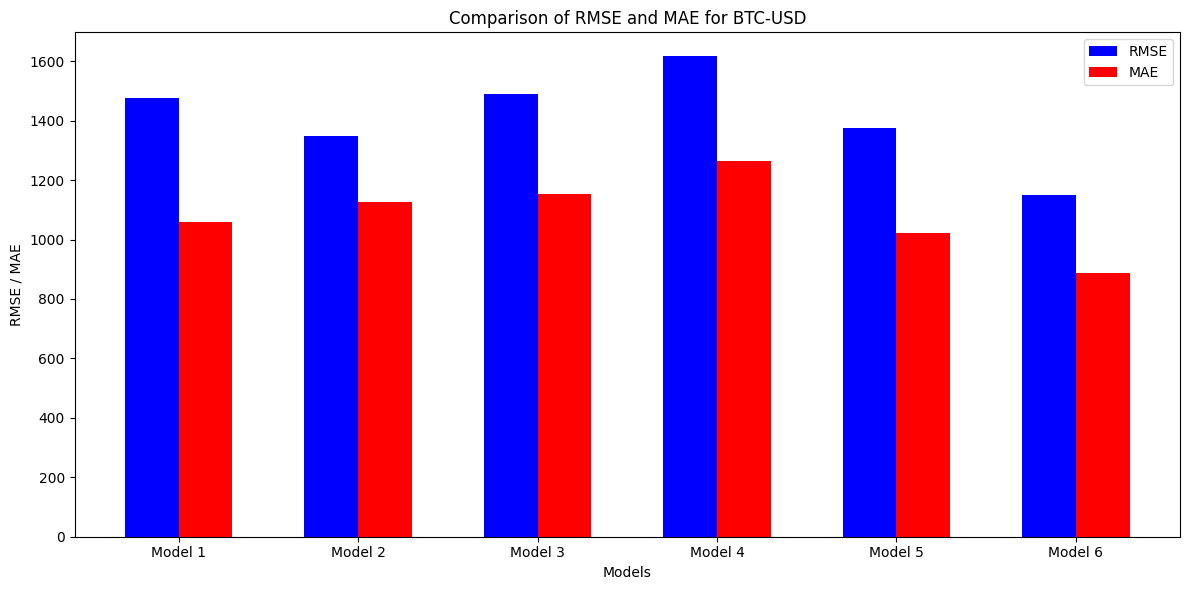

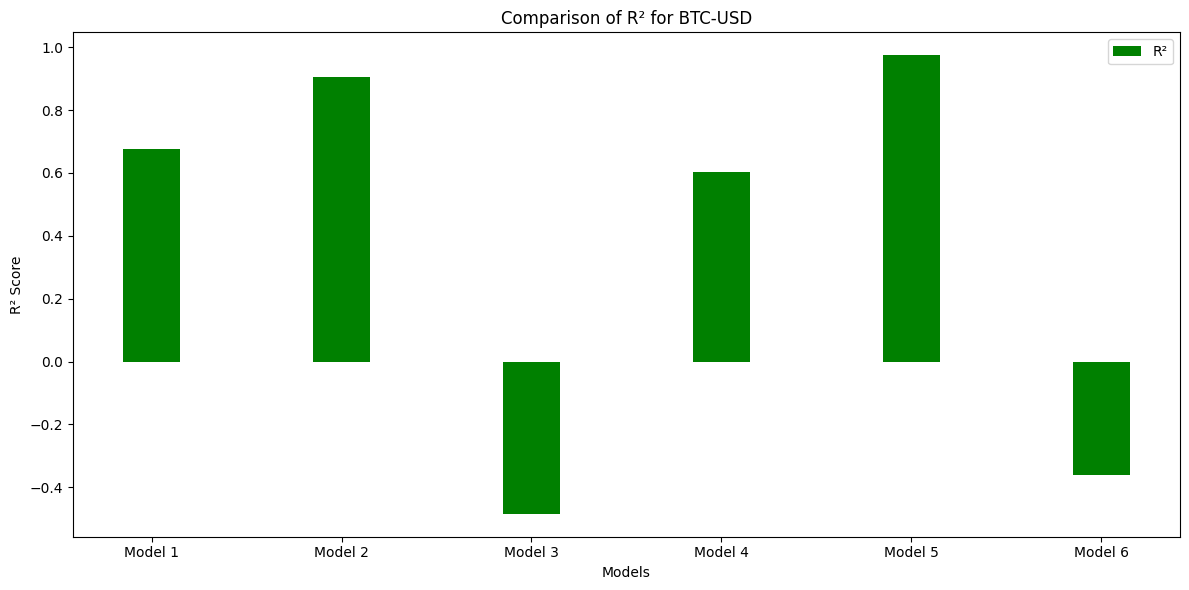

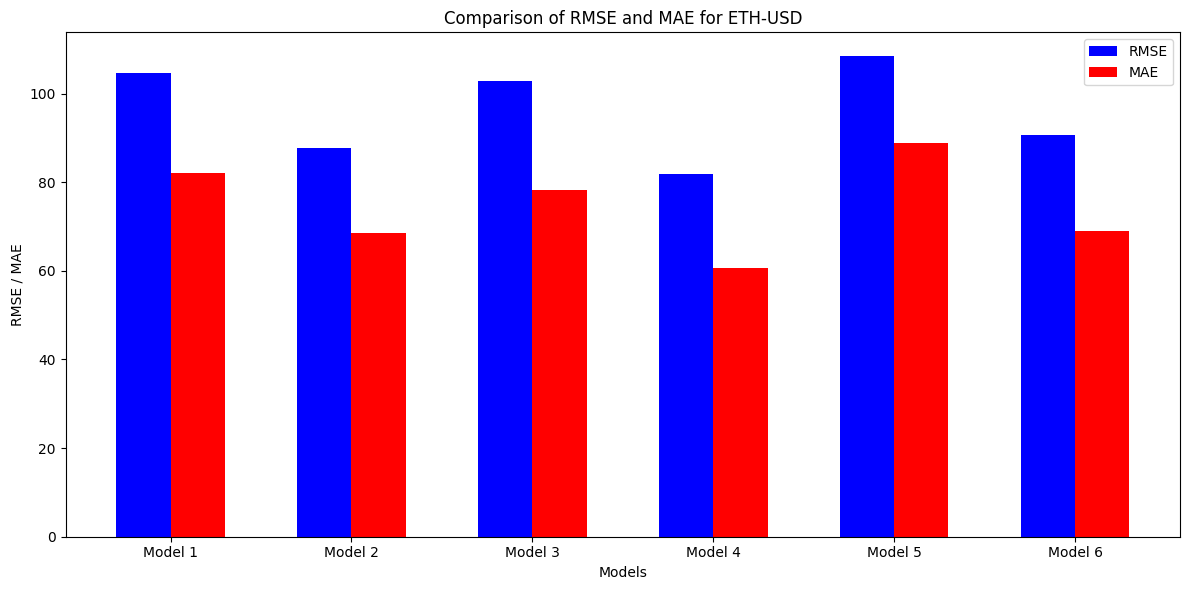

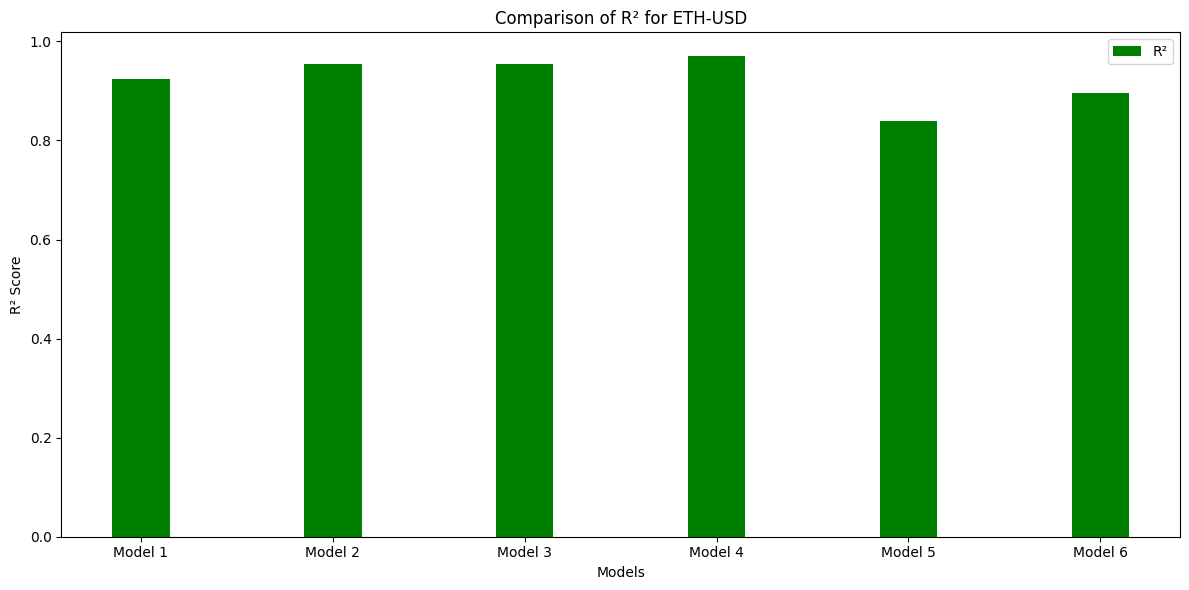

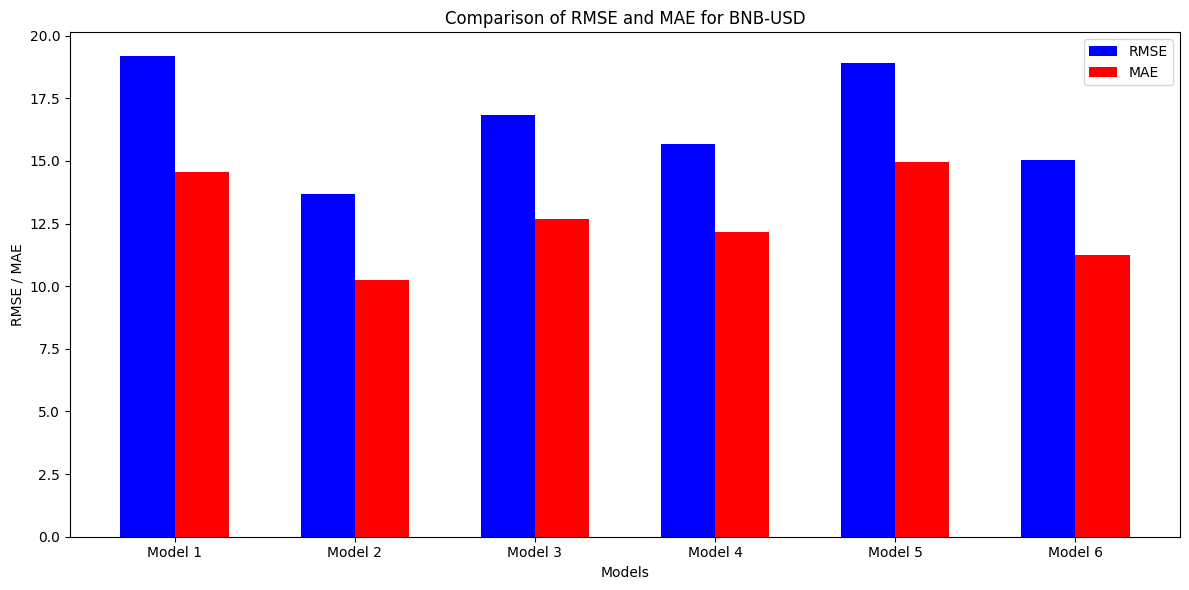

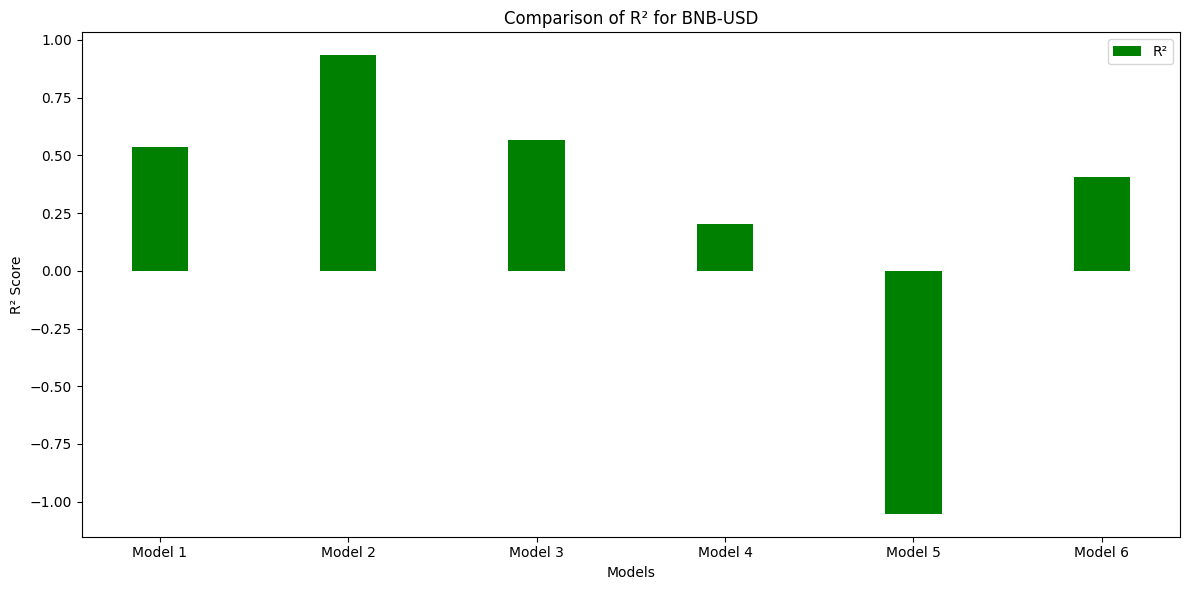

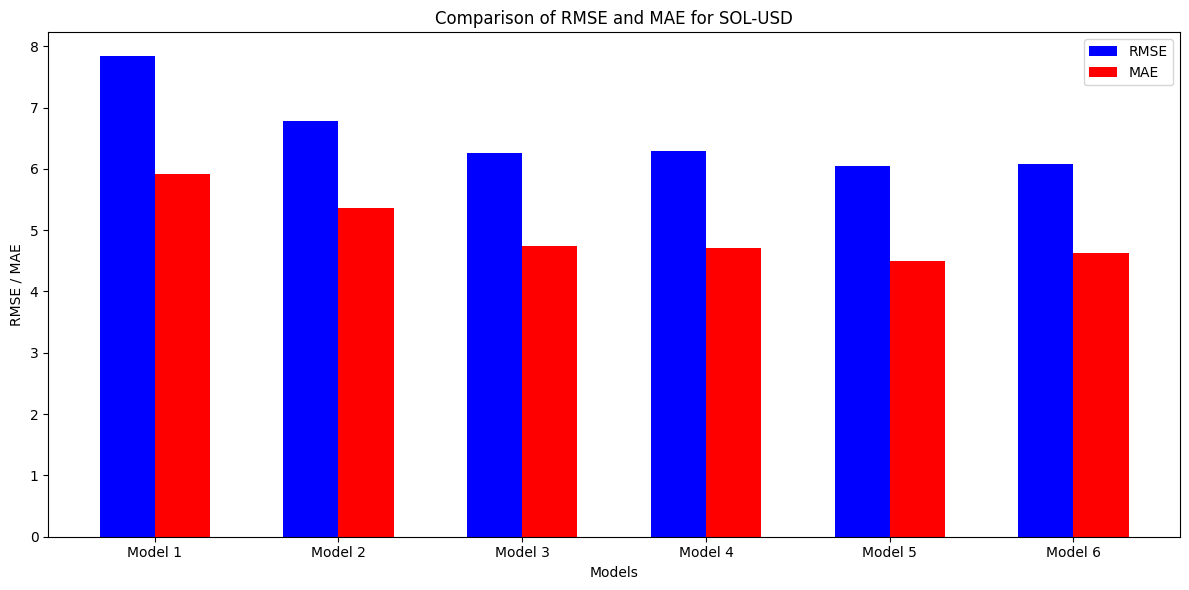

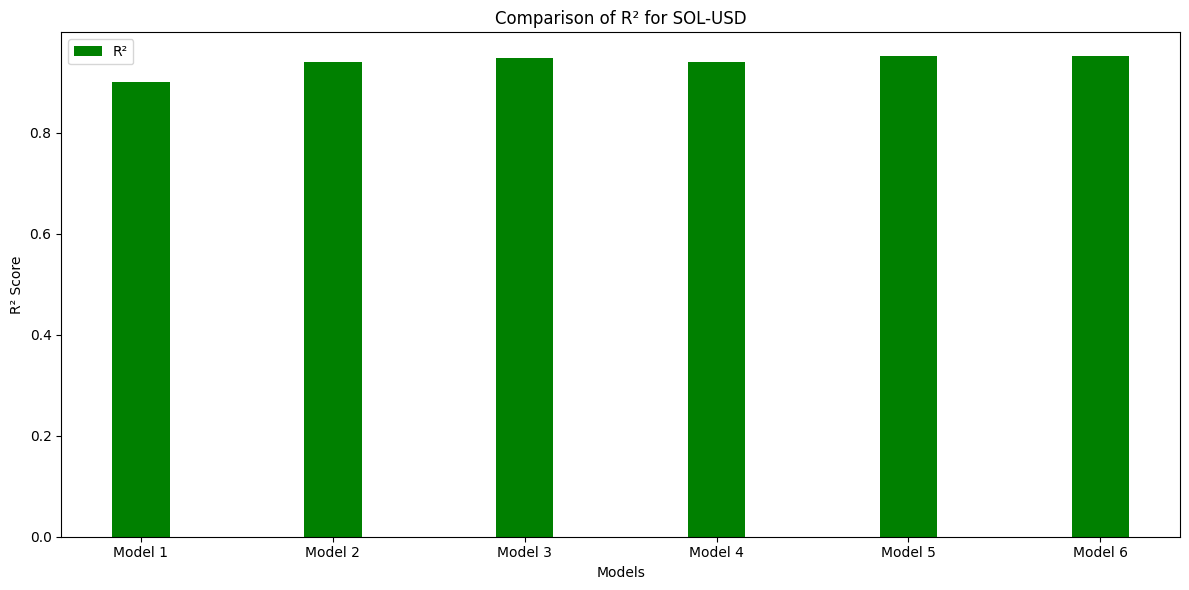

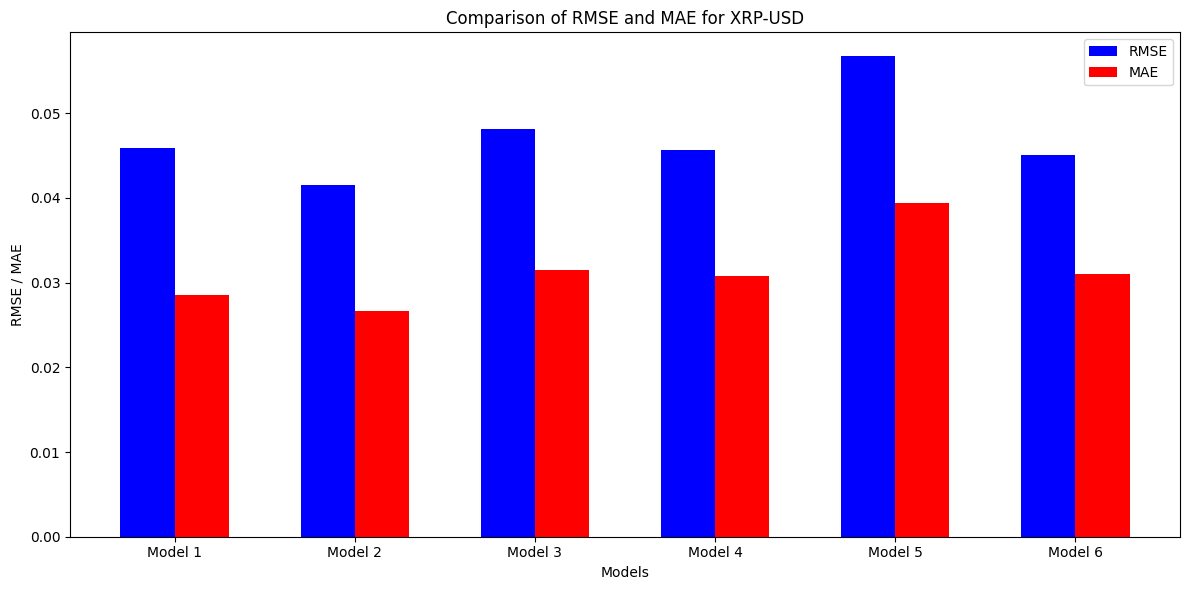

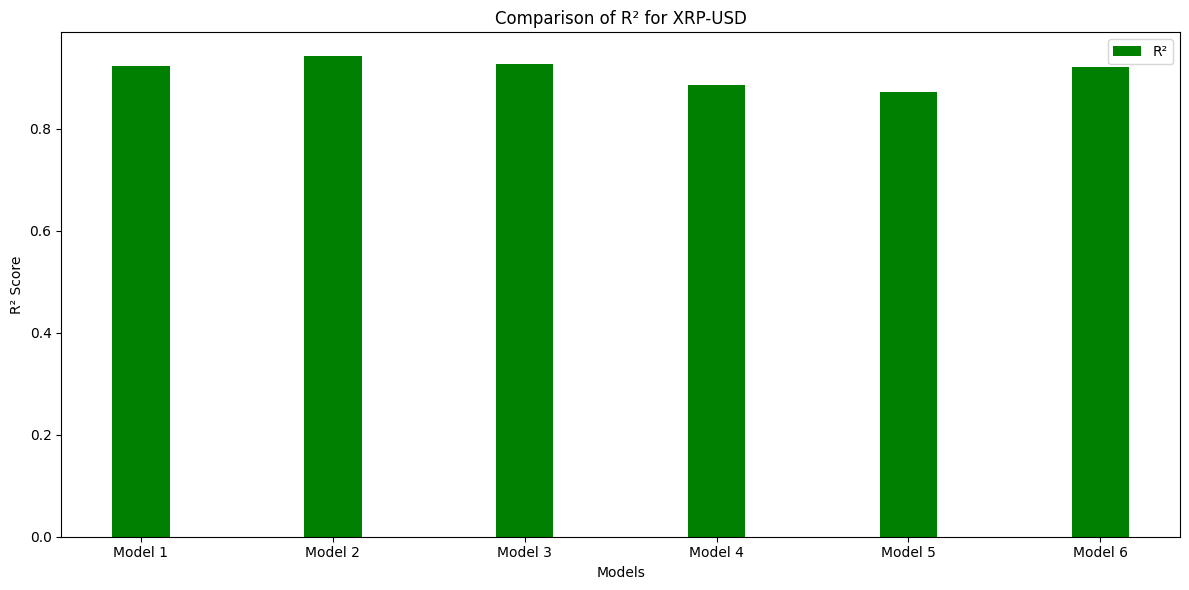

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import json
import os

# Load evaluation results from JSON file
with open('modeling_results.json', 'r') as f:
    evaluation_results = json.load(f)

# List of cryptocurrencies
cryptos = ['BTC-USD', 'ETH-USD', 'BNB-USD', 'SOL-USD', 'XRP-USD']

# Prepare directory to save plots
plots_dir = 'plots'
os.makedirs(plots_dir, exist_ok=True)

# Iterate through each cryptocurrency
for crypto in cryptos:
    # Initialize lists to store error metrics
    rmse_values = []
    mae_values = []
    r2_values = []
    model_names = []

    # Extract metrics for each model
    for i in range(6):  # Assuming 6 models per cryptocurrency
        model_name = f'{crypto}_model_{i + 1}'
        if model_name in evaluation_results:
            metrics = evaluation_results[model_name]['fold_results']
            avg_rmse = np.mean([fold['RMSE'] for fold in metrics])
            avg_mae = np.mean([fold['MAE'] for fold in metrics])
            avg_r2 = np.mean([fold['R²'] for fold in metrics])

            rmse_values.append(avg_rmse)
            mae_values.append(avg_mae)
            r2_values.append(avg_r2)
            model_names.append(f'Model {i + 1}')

    x = np.arange(len(model_names))  # X-axis positions
    width = 0.3  # Bar width

    # Plot RMSE and MAE
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax1.bar(x - width/2, rmse_values, width, label='RMSE', color='b')
    ax1.bar(x + width/2, mae_values, width, label='MAE', color='r')

    ax1.set_xlabel('Models')
    ax1.set_ylabel('RMSE / MAE')
    ax1.set_title(f'Comparison of RMSE and MAE for {crypto}')
    ax1.set_xticks(x)
    ax1.set_xticklabels(model_names)
    ax1.legend()
    plt.tight_layout()

    # Save the plot
    plot_path = os.path.join(plots_dir, f'{crypto}_rmse_mae_comparison.png')
    plt.savefig(plot_path)
    plt.show()

    # Plot R² separately
    fig, ax2 = plt.subplots(figsize=(12, 6))
    ax2.bar(x, r2_values, width, label='R²', color='g')

    ax2.set_xlabel('Models')
    ax2.set_ylabel('R² Score')
    ax2.set_title(f'Comparison of R² for {crypto}')
    ax2.set_xticks(x)
    ax2.set_xticklabels(model_names)
    ax2.legend()
    plt.tight_layout()

    # Save the plot
    plot_path = os.path.join(plots_dir, f'{crypto}_r2_comparison.png')
    plt.savefig(plot_path)
    plt.show()


[*********************100%***********************]  1 of 1 completed


115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


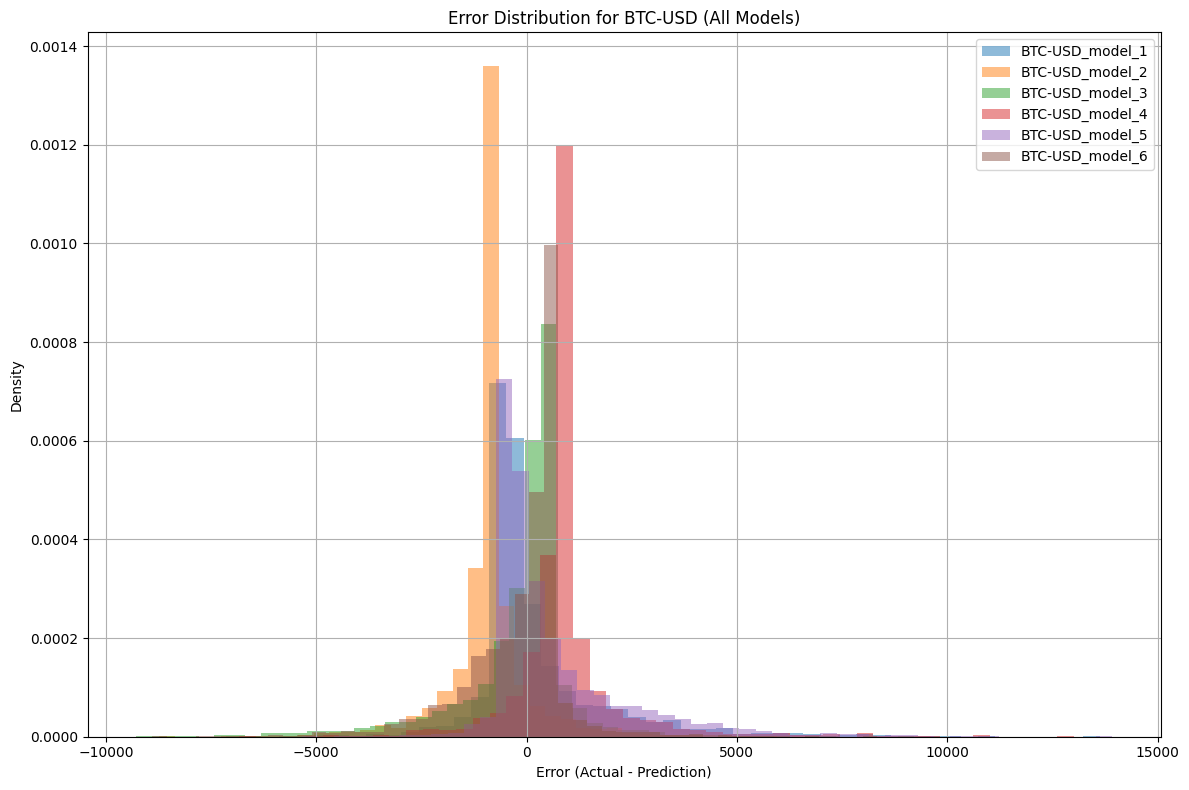

[*********************100%***********************]  1 of 1 completed


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


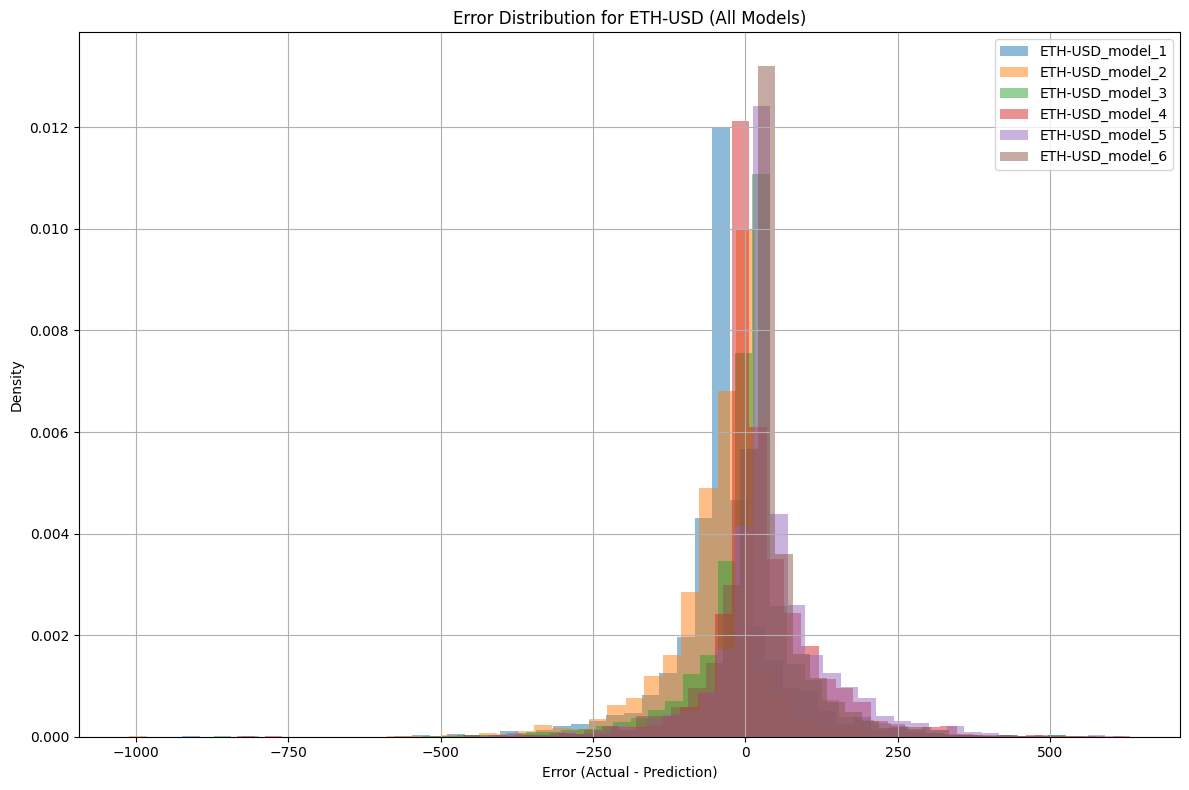

[*********************100%***********************]  1 of 1 completed


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


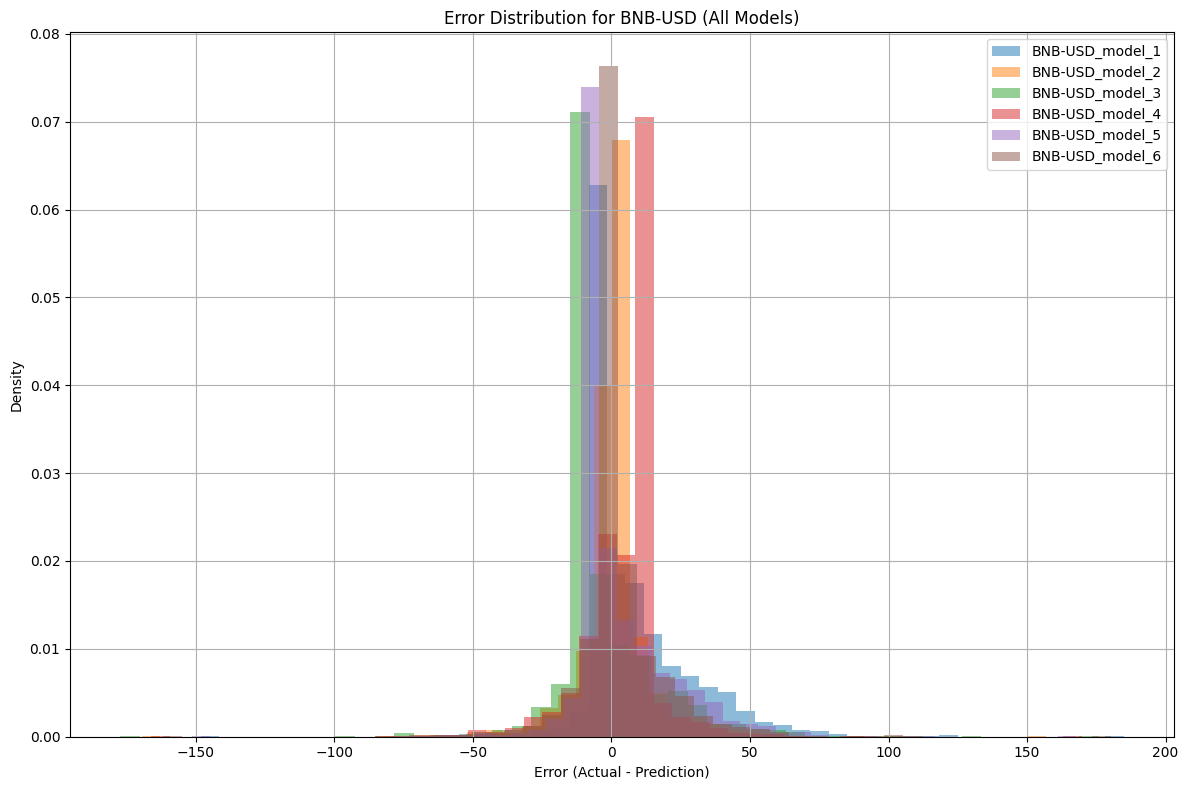

[*********************100%***********************]  1 of 1 completed


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


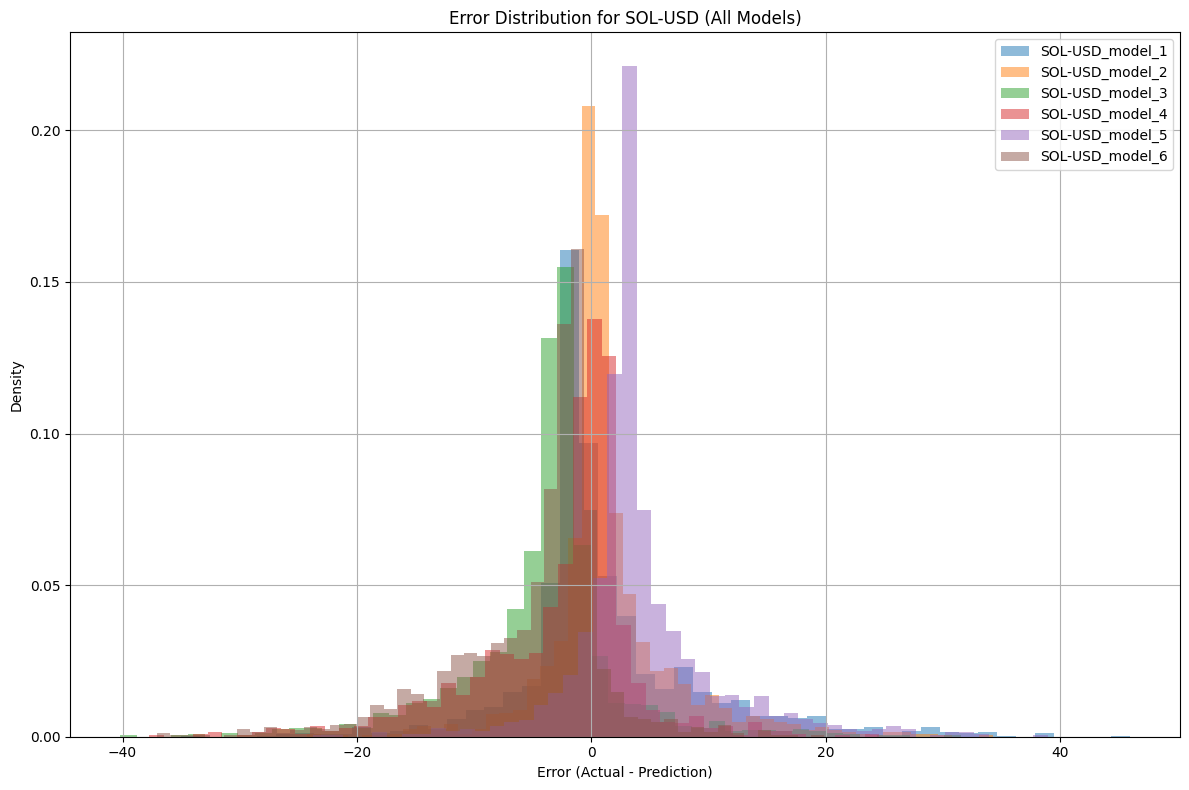

[*********************100%***********************]  1 of 1 completed


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


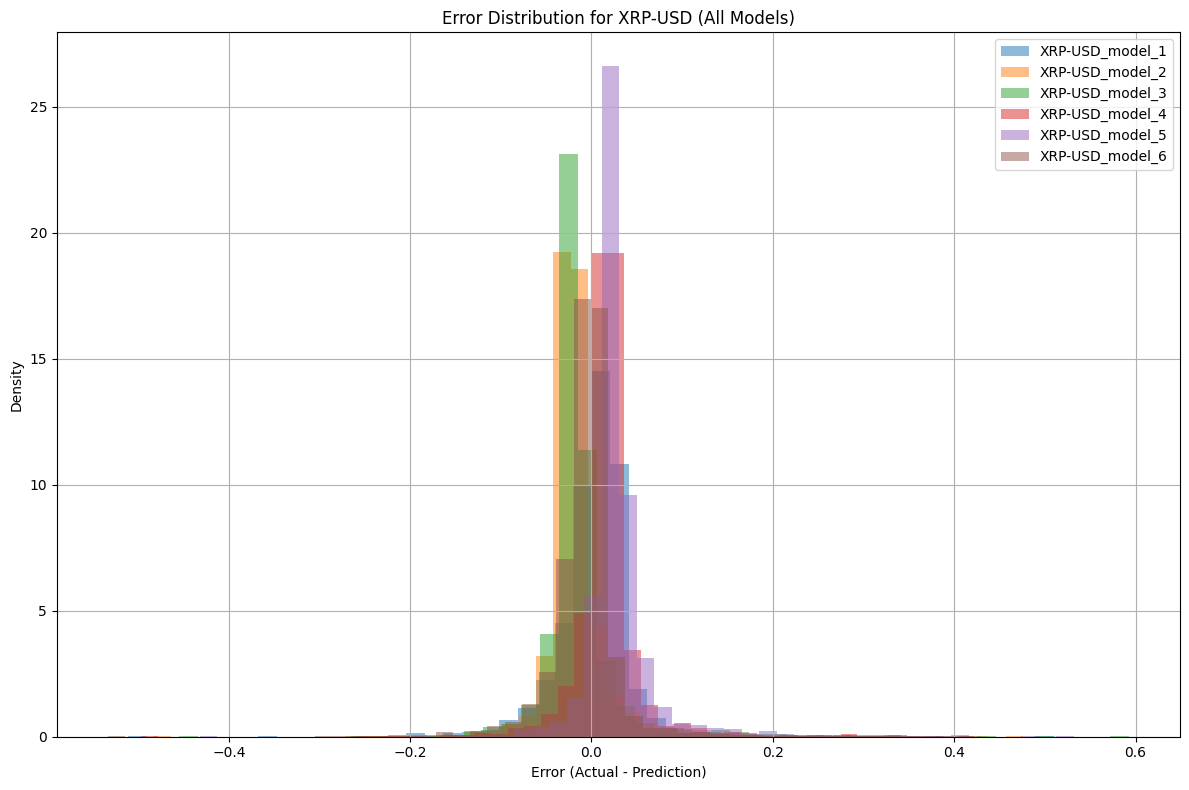

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import json
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
import os

# Prepare directory to save error distribution plots
plots_dir = 'error_distribution'
os.makedirs(plots_dir, exist_ok=True)

# Function to prepare data for evaluation
def prepare_data(data, time_step=120):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data[['Close']])
    X, y = [], []
    for i in range(len(scaled_data) - time_step - 1):
        X.append(scaled_data[i:(i + time_step), 0])
        y.append(scaled_data[i + time_step, 0])
    X = np.array(X).reshape(-1, time_step, 1)
    y = np.array(y)
    return scaler, X, y

# List of cryptocurrencies
cryptos = ['BTC-USD', 'ETH-USD', 'BNB-USD', 'SOL-USD', 'XRP-USD']

# Iterate through each cryptocurrency
for crypto in cryptos:
    # Load the dataset for the cryptocurrency
    crypto_data = yf.download(crypto, start='2014-01-01')
    crypto_data = crypto_data[['Close']]

    # Prepare data for evaluation
    scaler, X, y = prepare_data(crypto_data)

    # Initialize a dictionary to store errors for all models
    all_errors = {}

    # Iterate through all models for the cryptocurrency
    for i in range(6):  # Assuming 6 models per cryptocurrency
        model_name = f'{crypto}_model_{i + 1}'
        model_path = os.path.join('models', f"{model_name}_best.h5")

        if not os.path.exists(model_path):
            print(f"Model not found for {model_name}, skipping...")
            continue

        # Load the model
        model = load_model(model_path)

        # Predict values
        predictions = model.predict(X)
        predictions = scaler.inverse_transform(predictions)
        actual_values = scaler.inverse_transform(y.reshape(-1, 1))

        # Calculate errors
        errors = actual_values - predictions
        all_errors[model_name] = errors.flatten()

    # Plot error distribution for all models
    plt.figure(figsize=(12, 8))
    for model_name, errors in all_errors.items():
        plt.hist(errors, bins=50, alpha=0.5, label=model_name, density=True)

    plt.title(f'Error Distribution for {crypto} (All Models)')
    plt.xlabel('Error (Actual - Prediction)')
    plt.ylabel('Density')
    plt.legend()
    plt.grid()

    # Save the plot
    plot_path = os.path.join(plots_dir, f'{crypto}_error_distribution.png')
    plt.tight_layout()
    plt.savefig(plot_path)
    plt.show()


[*********************100%***********************]  1 of 1 completed


115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


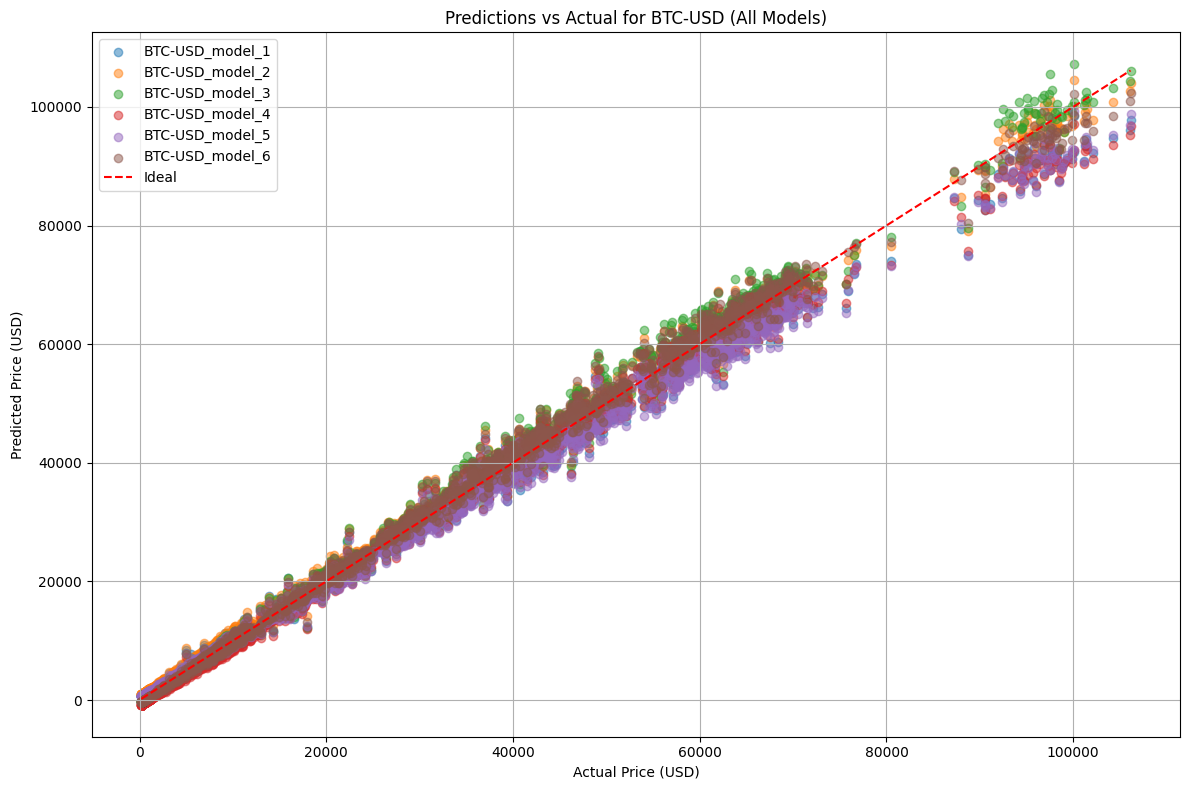

[*********************100%***********************]  1 of 1 completed


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


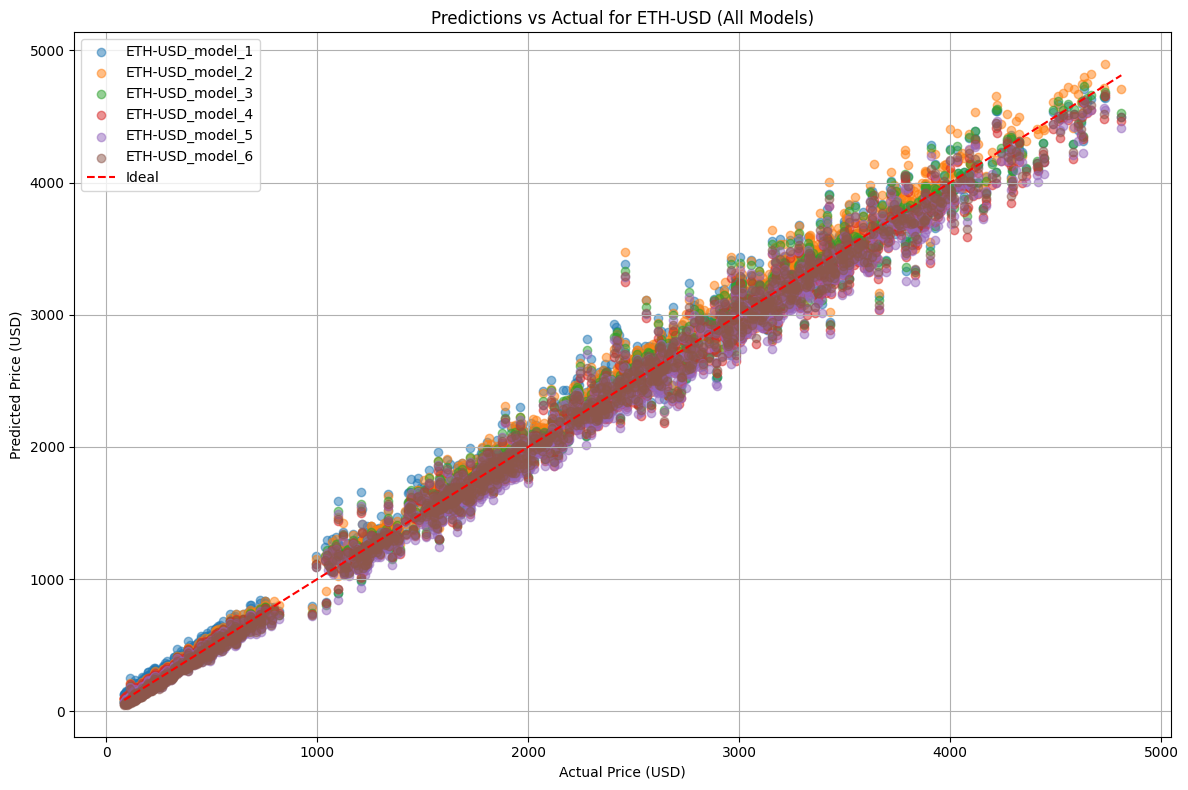

[*********************100%***********************]  1 of 1 completed


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


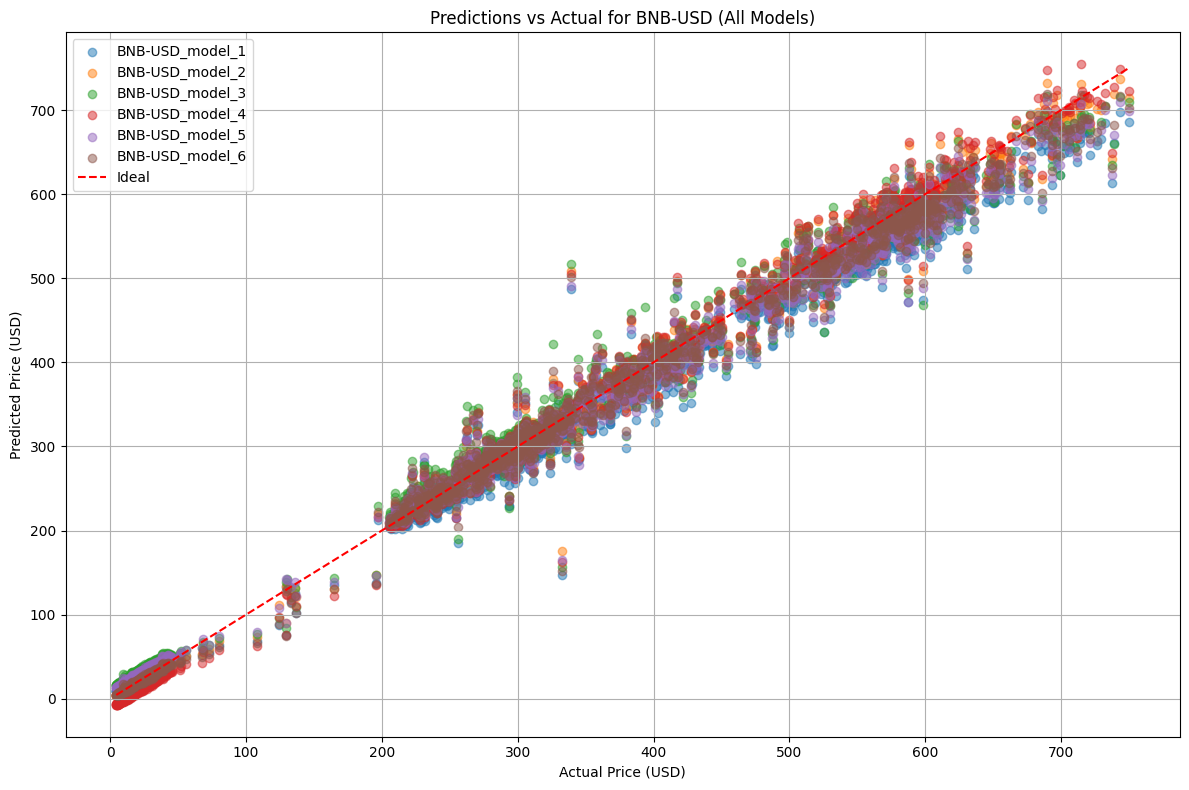

[*********************100%***********************]  1 of 1 completed


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


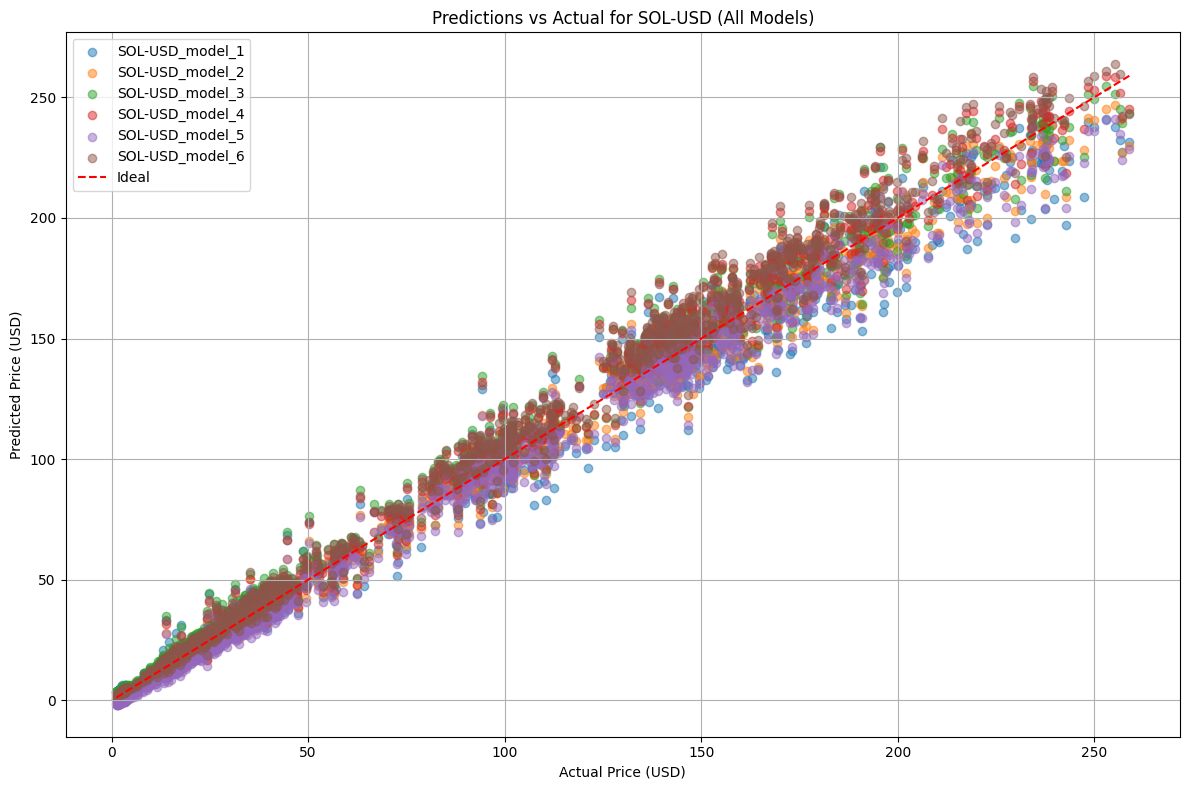

[*********************100%***********************]  1 of 1 completed


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


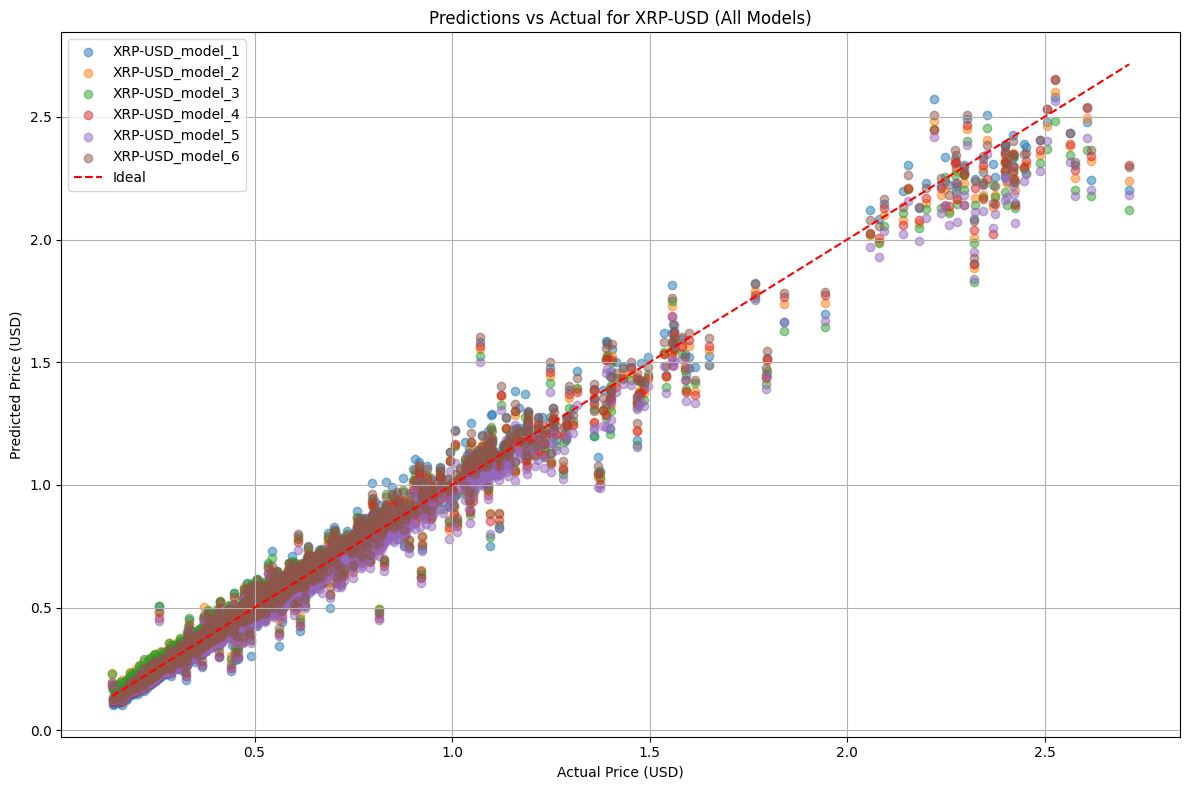

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import json
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
import os

# Prepare directory to save scatter plots
plots_dir = 'scatter_plots'
os.makedirs(plots_dir, exist_ok=True)

# Function to prepare data for evaluation
def prepare_data(data, time_step=120):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data[['Close']])
    X, y = [], []
    for i in range(len(scaled_data) - time_step - 1):
        X.append(scaled_data[i:(i + time_step), 0])
        y.append(scaled_data[i + time_step, 0])
    X = np.array(X).reshape(-1, time_step, 1)
    y = np.array(y)
    return scaler, X, y

# List of cryptocurrencies
cryptos = ['BTC-USD', 'ETH-USD', 'BNB-USD', 'SOL-USD', 'XRP-USD']

# Iterate through each cryptocurrency
for crypto in cryptos:
    # Load the dataset for the cryptocurrency
    crypto_data = yf.download(crypto, start='2014-01-01')
    crypto_data = crypto_data[['Close']]

    # Prepare data for evaluation
    scaler, X, y = prepare_data(crypto_data)

    # Initialize a dictionary to store predictions and actual values
    all_predictions = {}

    # Iterate through all models for the cryptocurrency
    for i in range(6):  # Assuming 6 models per cryptocurrency
        model_name = f'{crypto}_model_{i + 1}'
        model_path = os.path.join('models', f"{model_name}_best.h5")

        if not os.path.exists(model_path):
            print(f"Model not found for {model_name}, skipping...")
            continue

        # Load the model
        model = load_model(model_path)

        # Predict values
        predictions = model.predict(X)
        predictions = scaler.inverse_transform(predictions)
        actual_values = scaler.inverse_transform(y.reshape(-1, 1))

        # Store predictions and actual values
        all_predictions[model_name] = (actual_values.flatten(), predictions.flatten())

    # Plot scatter plot for all models
    plt.figure(figsize=(12, 8))
    for model_name, (actual, predicted) in all_predictions.items():
        plt.scatter(actual, predicted, alpha=0.5, label=model_name)

    # Plot diagonal line (ideal predictions)
    min_val = min([min(actual) for actual, _ in all_predictions.values()])
    max_val = max([max(actual) for actual, _ in all_predictions.values()])
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal')

    plt.title(f'Predictions vs Actual for {crypto} (All Models)')
    plt.xlabel('Actual Price (USD)')
    plt.ylabel('Predicted Price (USD)')
    plt.legend()
    plt.grid()

    # Save the plot
    plot_path = os.path.join(plots_dir, f'{crypto}_scatter_plot.png')
    plt.tight_layout()
    plt.savefig(plot_path)
    plt.show()


In [ ]:
import shutil

# Define the directories to be zipped
folders_to_zip = ['error_distribution', 'long_term_forecast']

# Create zip files for each folder
for folder in folders_to_zip:
    if os.path.exists(folder):
        zip_filename = f'{folder}.zip'
        shutil.make_archive(folder, 'zip', folder)
        print(f'{zip_filename} created successfully!')
    else:
        print(f"Folder '{folder}' does not exist and cannot be zipped.")


Folder 'error_distribution' does not exist and cannot be zipped.
Folder 'long_term_forecast' does not exist and cannot be zipped.


In [ ]:
# Import libraries
import os
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import json
import yfinance as yf  # Import yfinance

# Load evaluation results from JSON file
with open('modeling_results.json', 'r') as f:
    evaluation_results = json.load(f)

# Prepare directories
models_dir = 'models'

# Function to prepare data for prediction
def prepare_data_for_prediction(data, time_step=120):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data[['Close']])
    X, last_date = [], data.index[-1]
    X.append(scaled_data[-time_step:, 0])
    X = np.array(X).reshape(-1, time_step, 1)
    return scaler, X, last_date

# List of cryptocurrencies
cryptos = ['BTC-USD', 'ETH-USD', 'BNB-USD', 'SOL-USD', 'XRP-USD']

# Initialize a DataFrame to store results
results = []

# Iterate through each cryptocurrency
for crypto in cryptos:
    # Load the dataset for the cryptocurrency
    crypto_data = yf.download(crypto, start='2014-01-01')
    crypto_data = crypto_data[['Close']]

    # Prepare data for the model
    scaler, X, last_date = prepare_data_for_prediction(crypto_data)

    # Iterate through 6 models for this cryptocurrency
    for i in range(6):
        model_name = f'{crypto}_model_{i + 1}'
        model_path = os.path.join(models_dir, f"{model_name}_best.h5")

        if os.path.exists(model_path):
            # Load the model
            model = load_model(model_path)

            # Get the model structure from evaluation results
            structure = evaluation_results.get(model_name, {}).get('structure', [])

            # Make prediction for yesterday based on the last 120 days
            prediction = model.predict(X)

            # Inverse transform the prediction
            prediction = scaler.inverse_transform(prediction)[0, 0]
            actual_value = float(crypto_data['Close'].iloc[-2])  # Use the value for yesterday as float

            # Calculate percentage error
            percentage_error = abs((actual_value - prediction) / actual_value) * 100

            # Append the result to the list
            results.append({
                'Crypto': crypto,
                'Model': f'Model {i + 1}',
                'Date': crypto_data.index[-2].strftime('%Y-%m-%d'),
                'Actual': actual_value,
                'Predicted': prediction,
                'Percentage Error': percentage_error
            })

# Convert the list of results to a DataFrame
results_df = pd.DataFrame(results)

# Display the results as a table
print(results_df)

# Optionally, save the results to a CSV file
results_df.to_csv('crypto_predictions_results.csv', index=False)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Empty DataFrame
Columns: []
Index: []
